In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import cv2
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import tensorflow as tf
from datetime import datetime
import utils
from utils import augment
import model
from unetEnums import DataType, MaskType
import copy

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Set some parameters
_imgWidth = 512
_imgHeight = 512
_imgChannels = 3
_trainPath = './stage1_train_fixed/'
_valPath = './extra_data/'
_testPath = './stage2_test_final/'

# Root directory of the project
_rootDir = os.getcwd()

# Directory to save logs and trained model
_modelDir = os.path.join(_rootDir, "logs")

_batchSize = 4
_validationSplit = 0.1
_epochs = 100

#train_ids = next(os.walk(_trainPath))[1]
#_augmentedImagesNum = 2*len(train_ids)
_numberOfAugmentedImages = 20

_contourThickness = 1

# Get the data

In [3]:
train_ids, X_train, Y_train, spaceBetweenTrain, concatenatedMasksTrain = utils.load_dataset(_trainPath, _imgWidth, _imgHeight, _imgChannels, datasetType = DataType.trainData, contourThickness = _contourThickness)
val_ids, X_val, Y_val, spaceBetweenVal, concatenatedMasksVal = utils.load_dataset(_valPath, _imgWidth, _imgHeight, _imgChannels, datasetType=DataType.valData, contourThickness = _contourThickness)
test_ids, X_test, sizes_test = utils.load_dataset(_testPath, _imgWidth, _imgHeight, _imgChannels, datasetType=DataType.testData)

trying to load the numpy arrays from binary files
Done!
trying to load the numpy arrays from binary files
Done!
trying to load the numpy arrays from binary files
Done!


In [4]:
print(len(train_ids))
print(X_train.shape)
print(Y_train.shape)
print(spaceBetweenTrain.shape)
print(concatenatedMasksTrain.shape)

664
(664, 512, 512, 3)
(664, 512, 512, 1)
(664, 512, 512, 1)
(664, 512, 512, 2)


0


/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


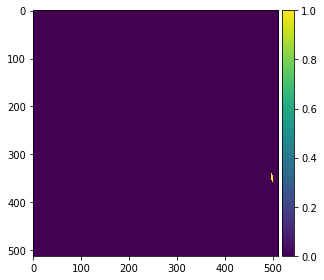

1


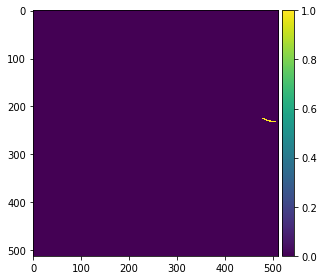

2


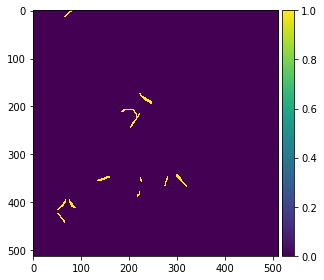

3


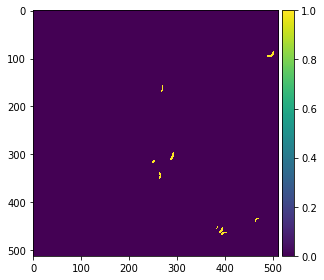

4


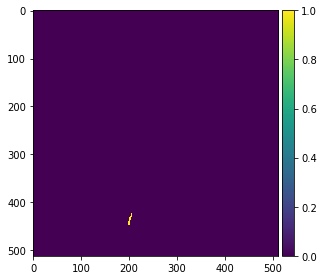

5


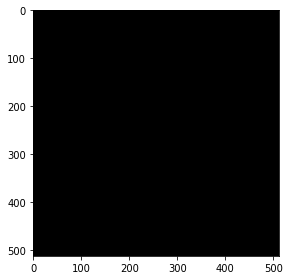

6


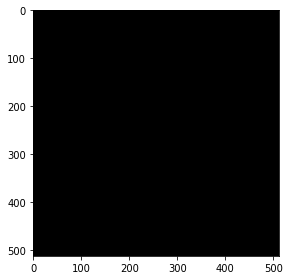

7


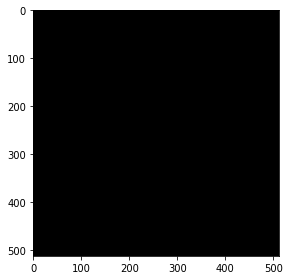

8


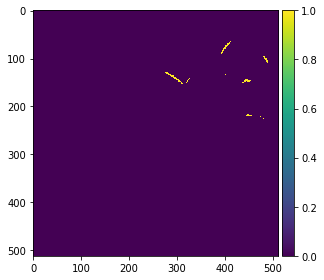

9


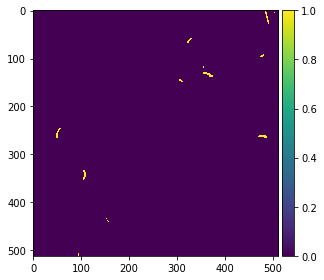

10


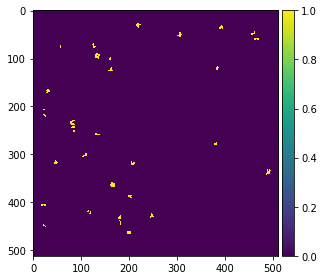

11


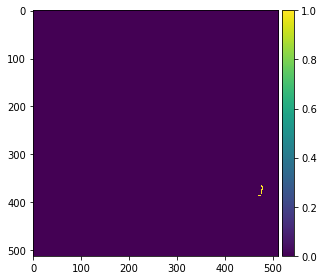

12


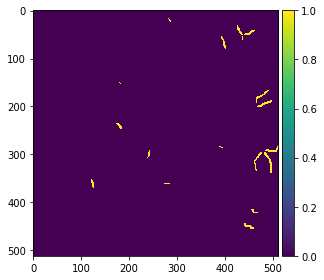

13


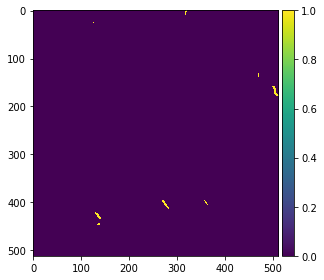

14


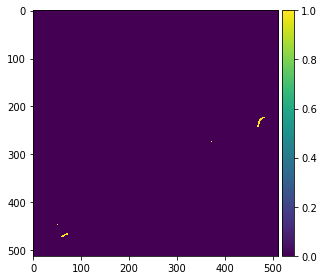

15


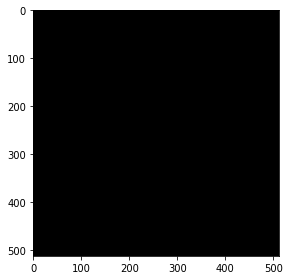

16


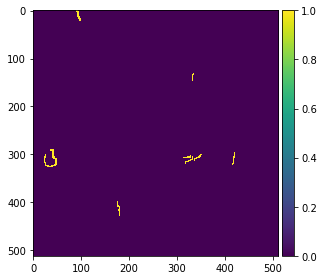

17


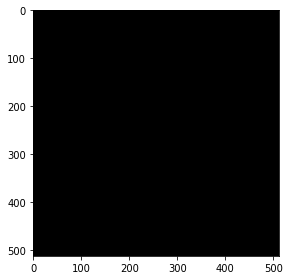

18


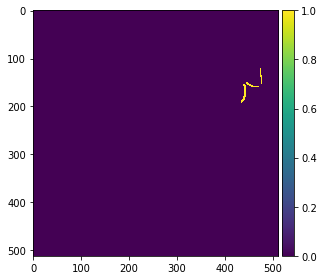

19


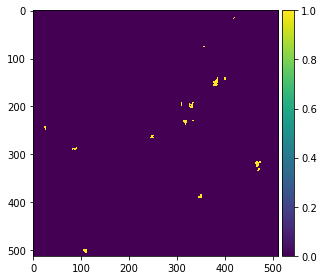

20


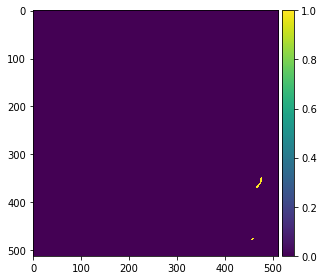

21


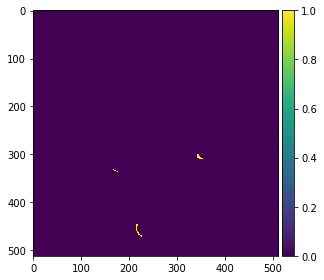

22


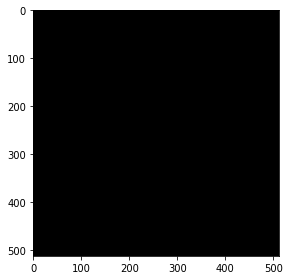

23


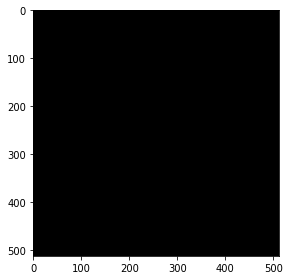

24


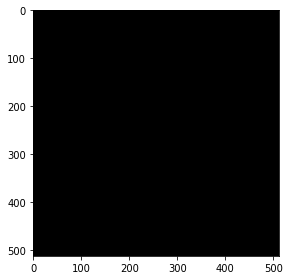

25


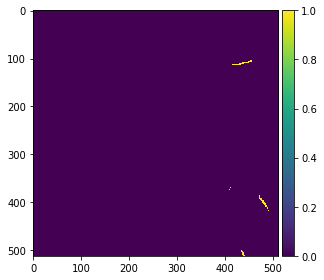

26


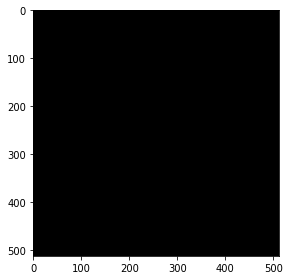

27


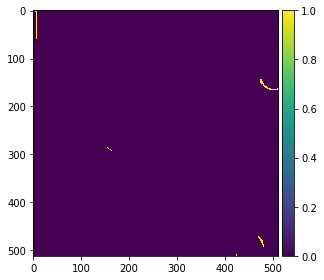

28


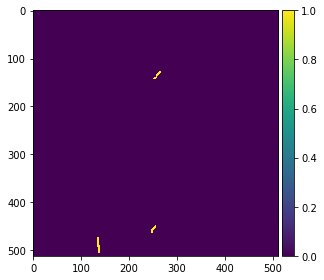

29


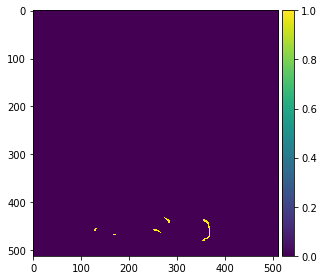

30


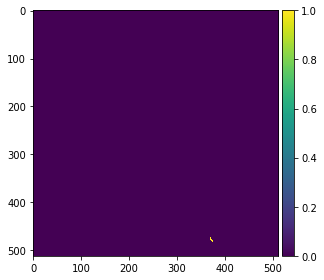

31


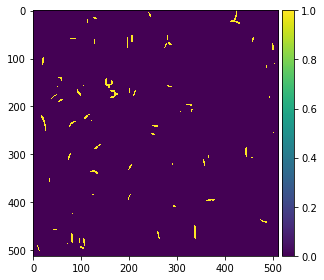

32


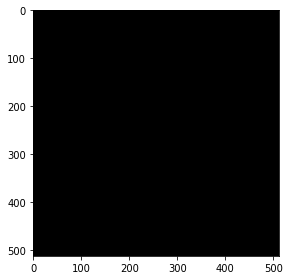

33


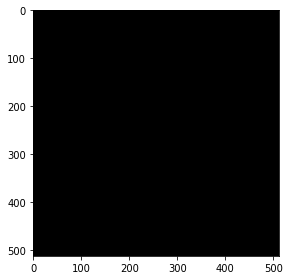

34


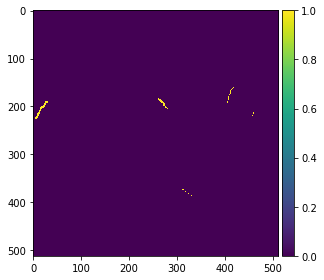

35


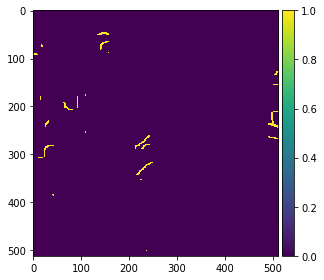

36


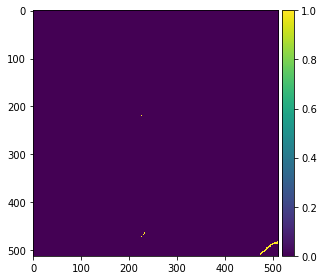

37


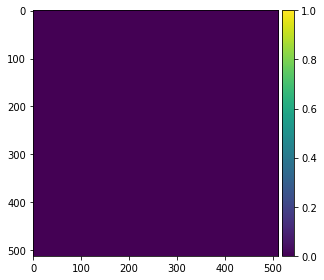

38


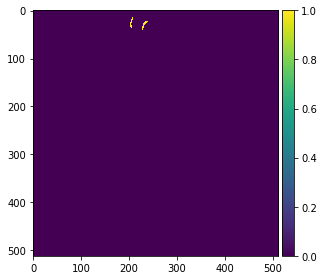

39


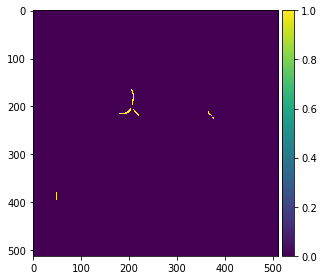

40


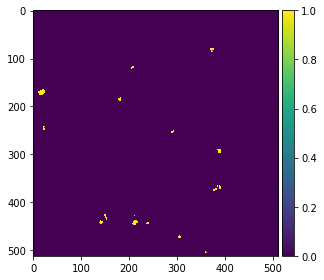

41


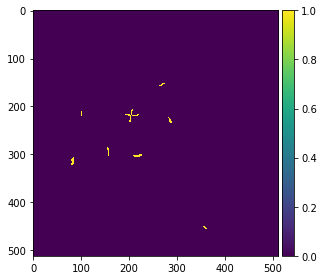

42


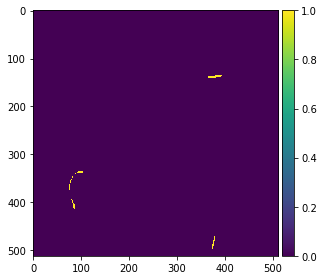

43


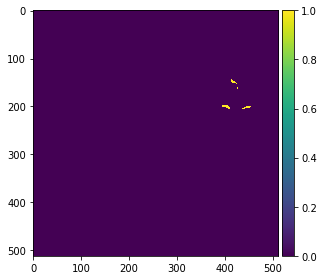

44


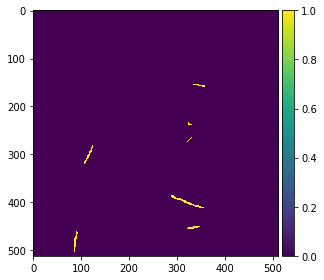

45


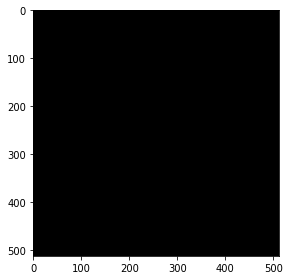

46


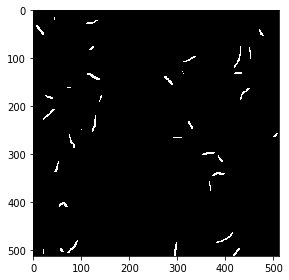

47


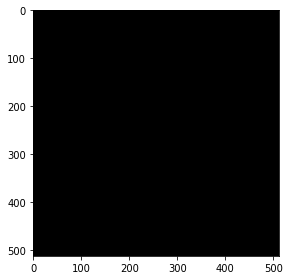

48


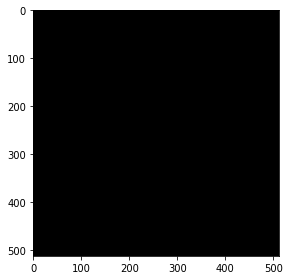

49


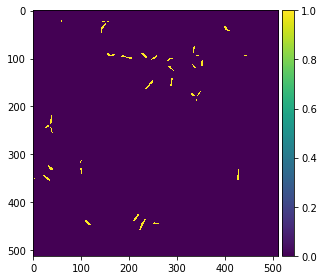

50


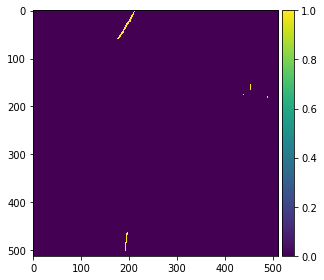

51


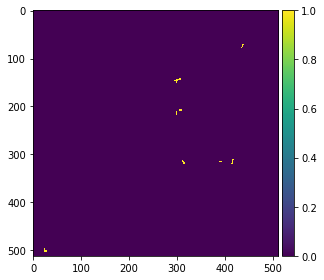

52


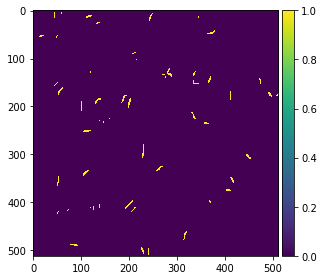

53


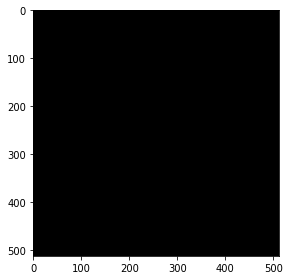

54


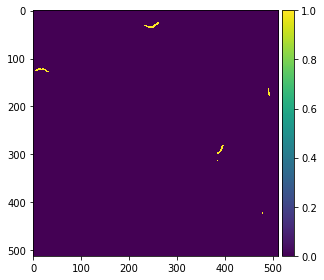

55


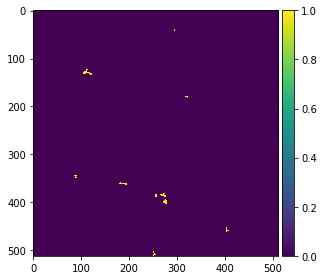

56


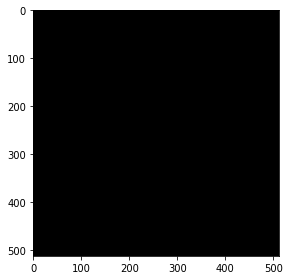

57


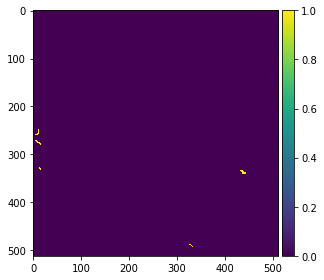

58


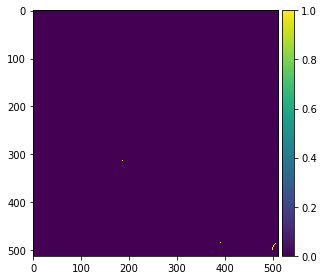

59


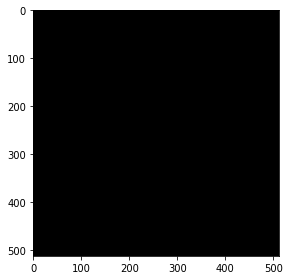

60


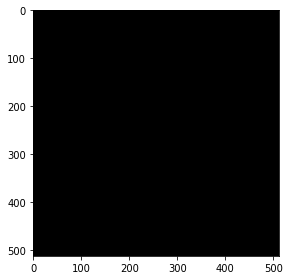

61


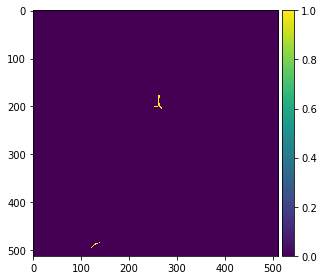

62


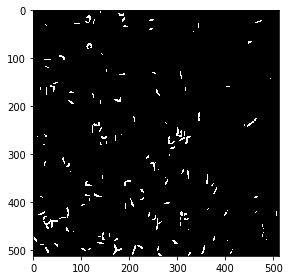

63


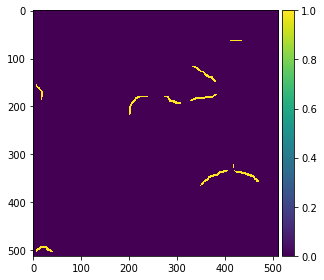

64


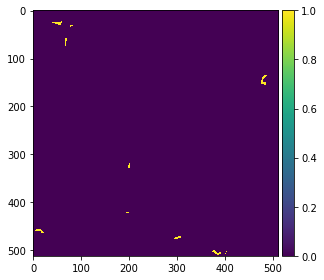

65


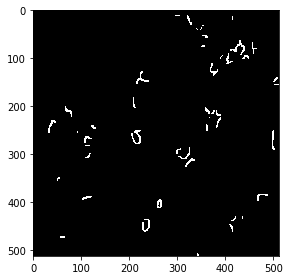

66


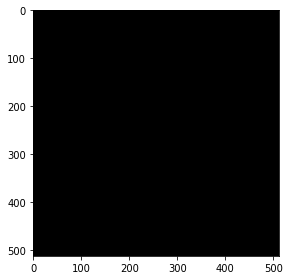

67


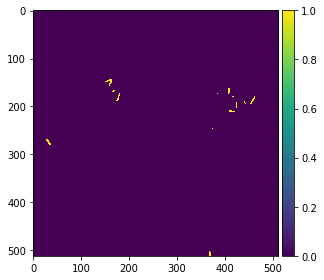

68


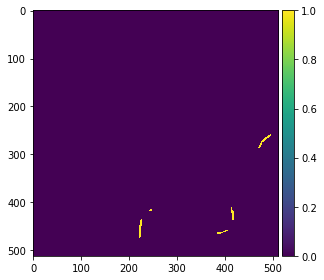

69


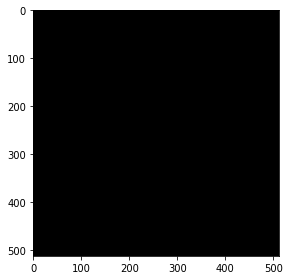

70


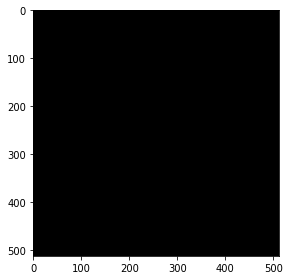

71


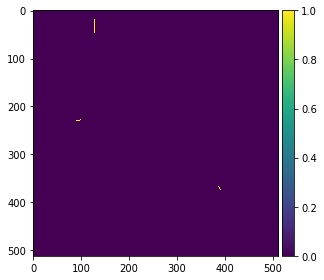

72


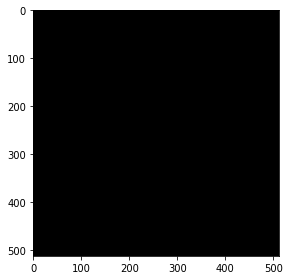

73


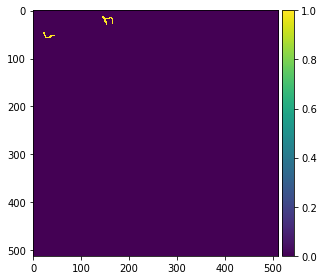

74


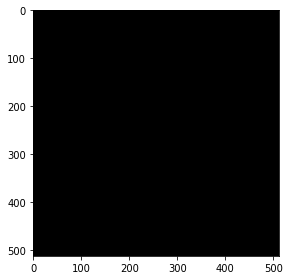

75


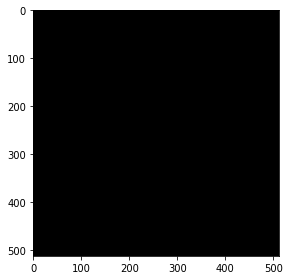

76


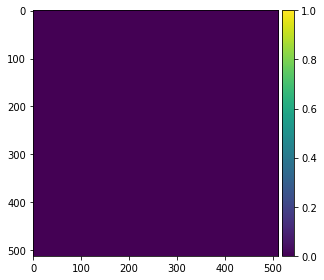

77


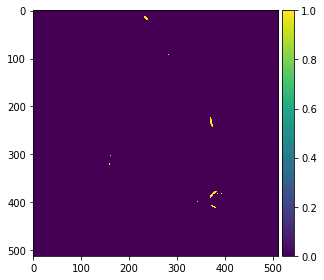

78


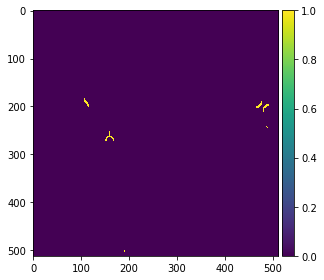

79


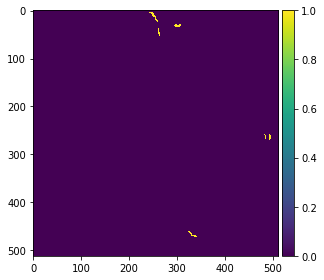

80


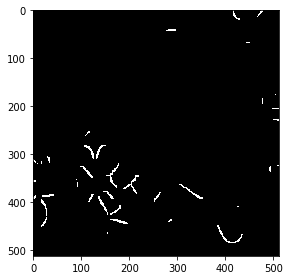

81


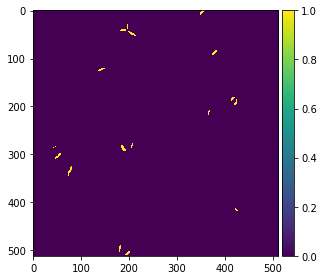

82


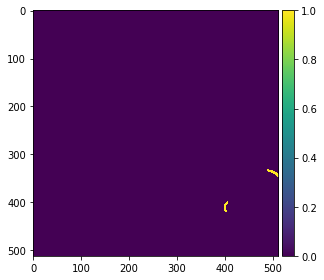

83


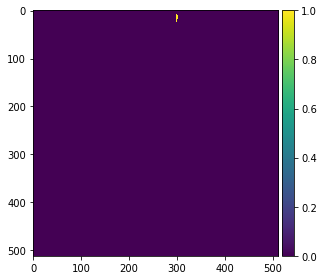

84


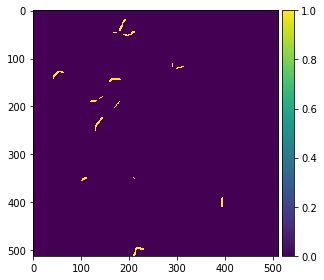

85


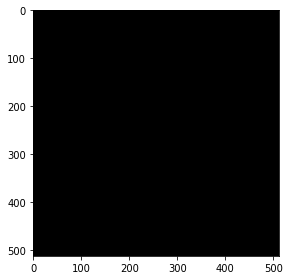

86


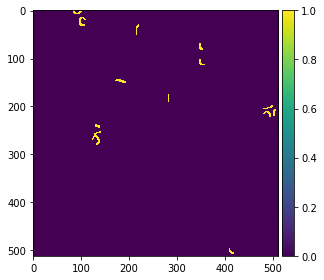

87


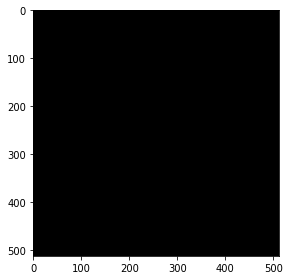

88


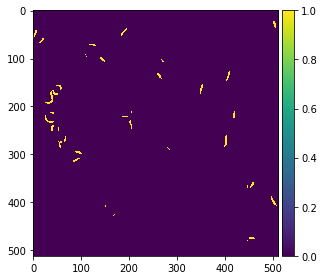

89


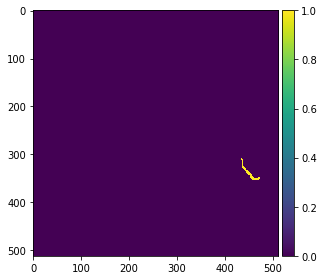

90


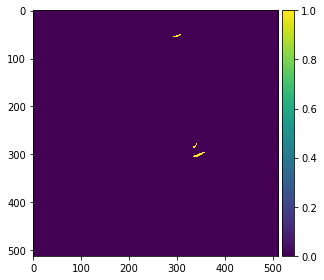

91


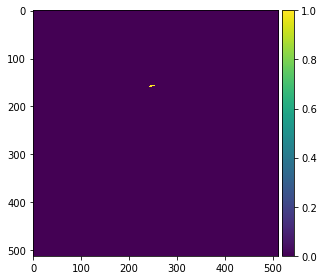

92


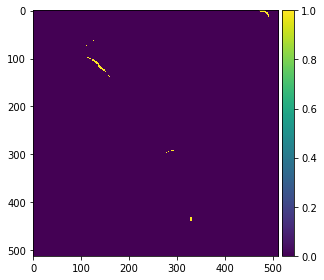

93


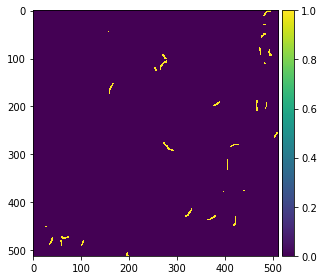

94


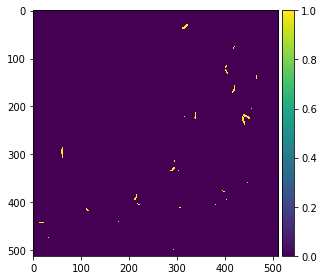

95


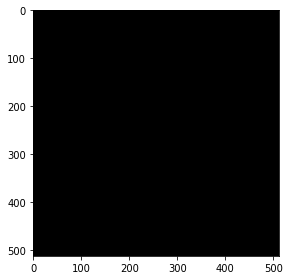

96


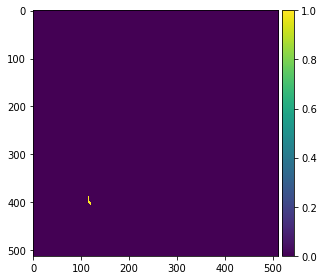

97


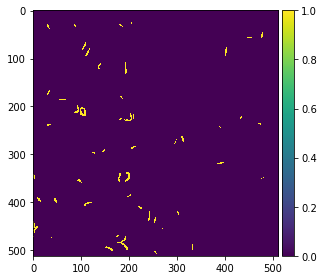

98


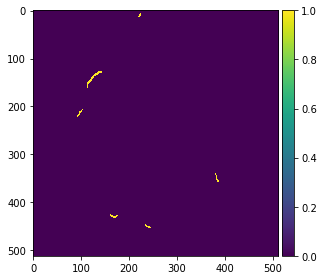

99


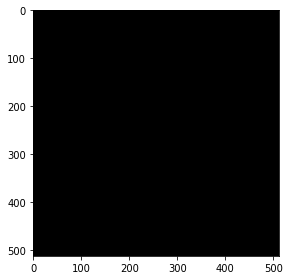

100


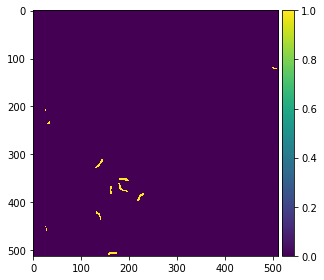

101


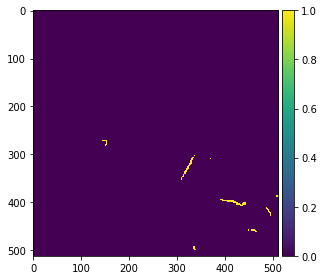

102


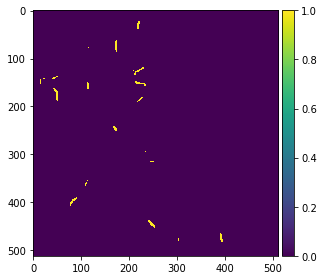

103


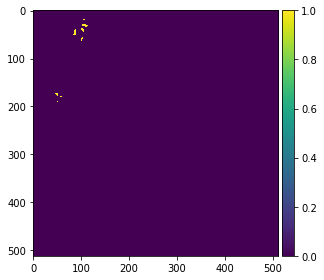

104


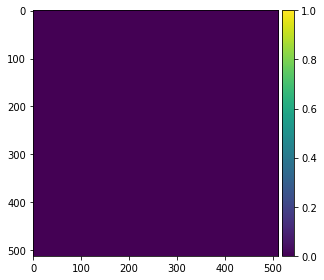

105


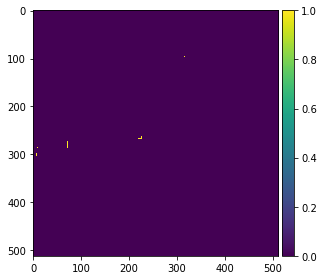

106


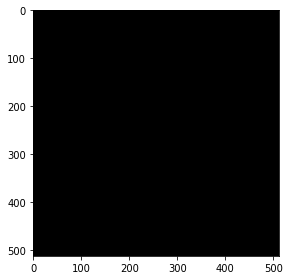

107


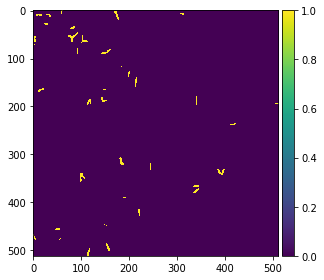

108


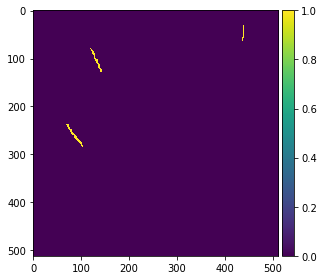

109


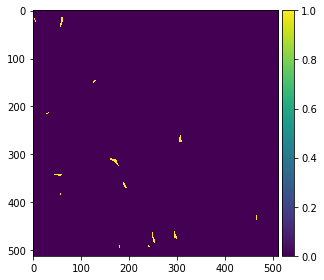

110


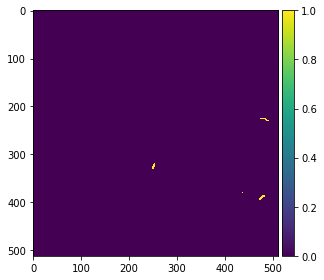

111


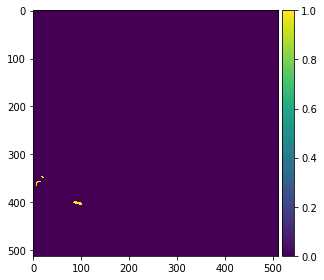

112


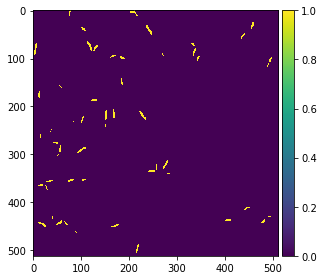

113


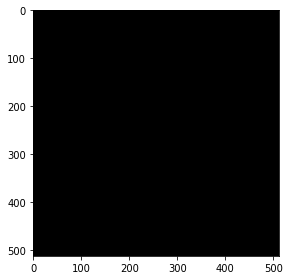

114


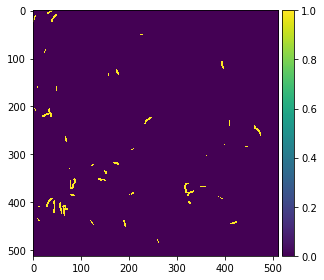

115


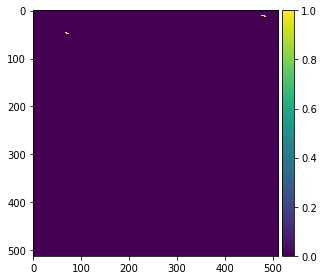

116


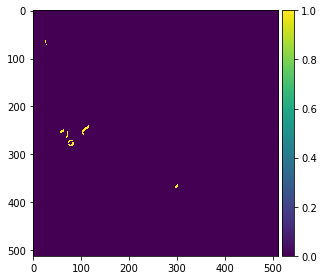

117


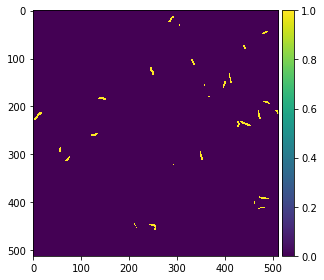

118


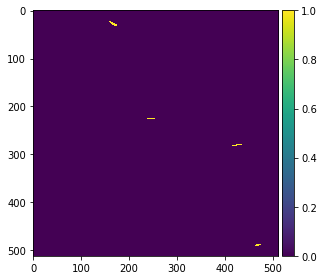

119


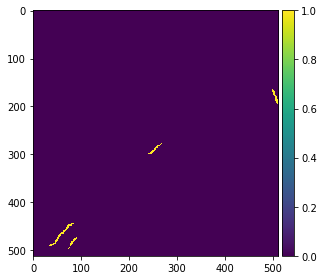

120


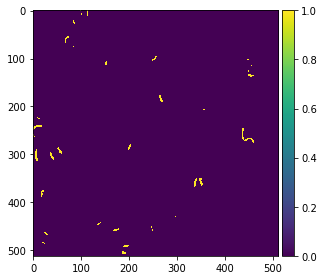

121


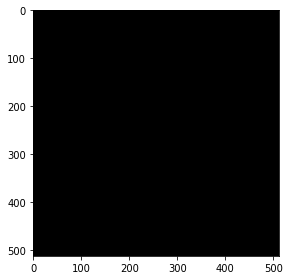

122


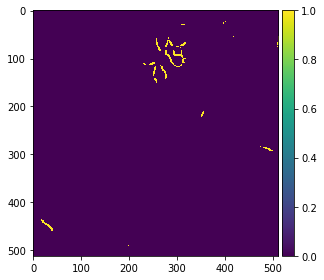

123


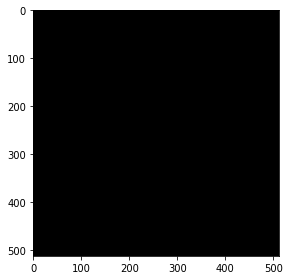

124


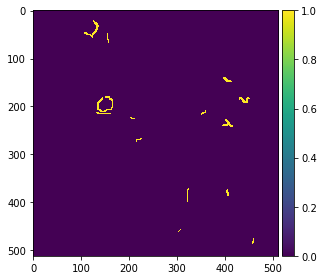

125


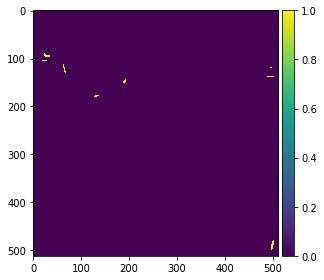

126


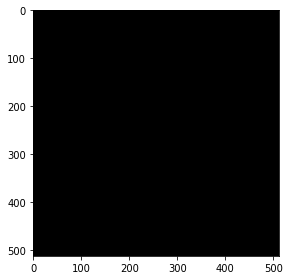

127


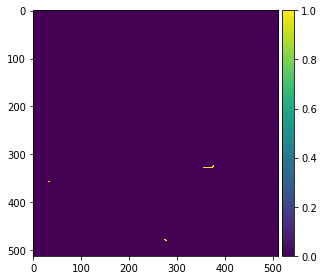

128


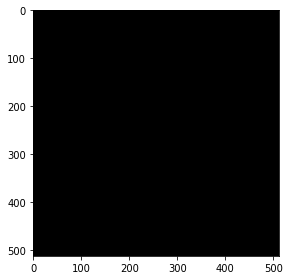

129


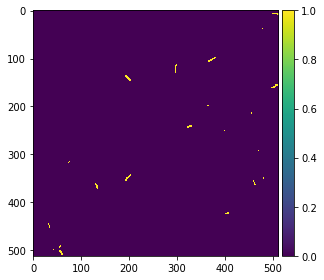

130


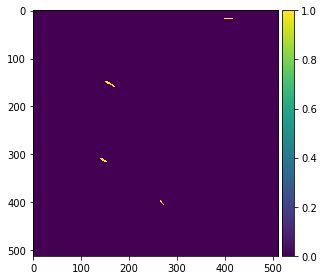

131


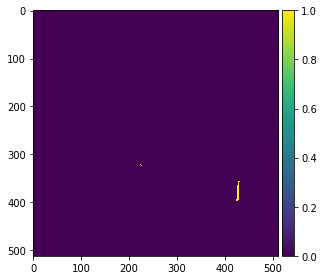

132


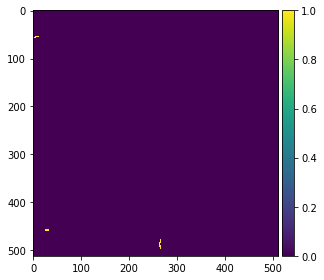

133


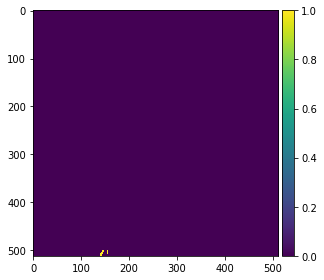

134


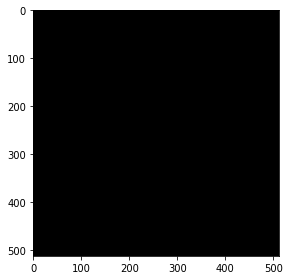

135


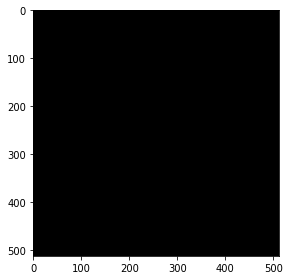

136


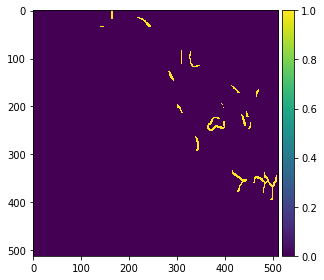

137


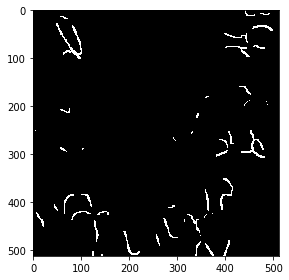

138


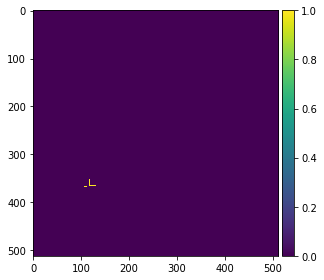

139


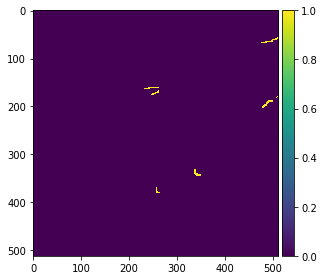

140


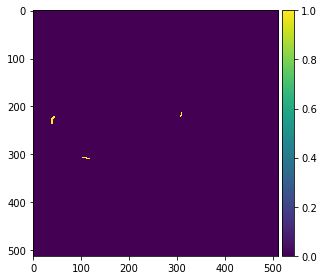

141


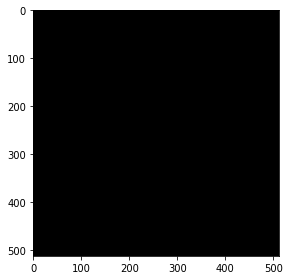

142


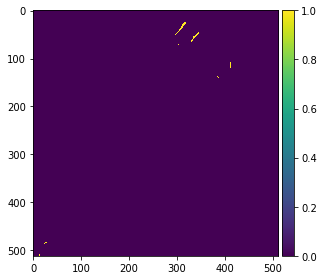

143


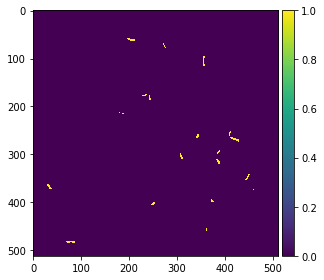

144


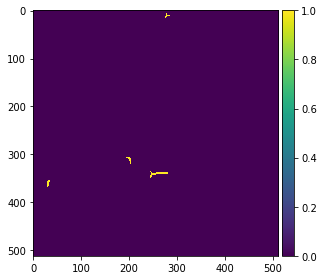

145


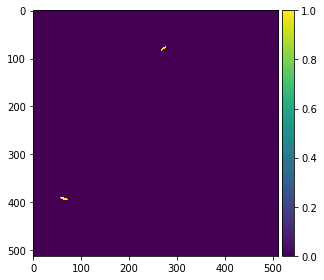

146


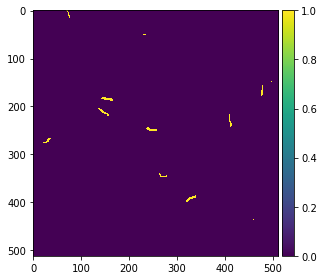

147


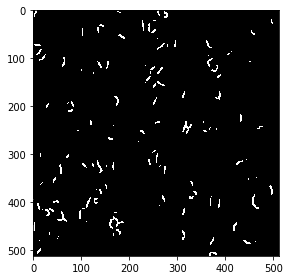

148


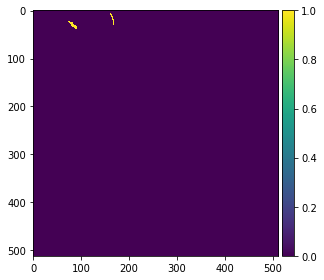

149


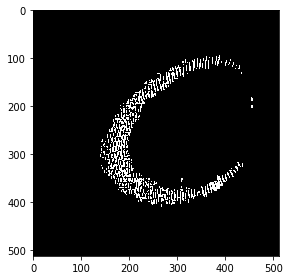

150


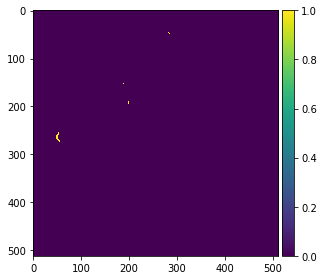

151


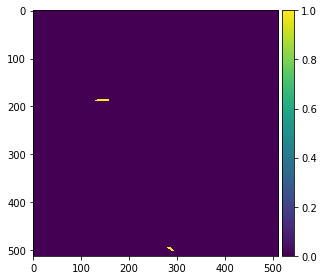

152


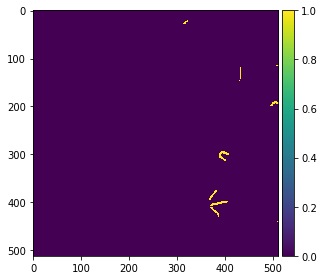

153


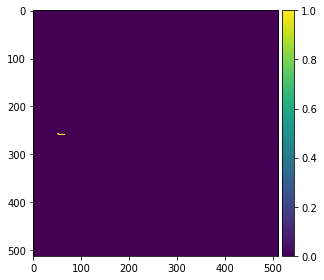

154


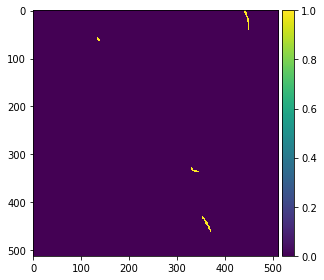

155


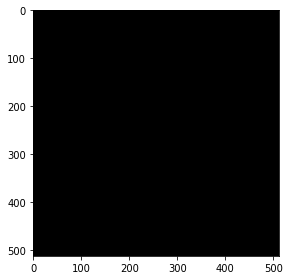

156


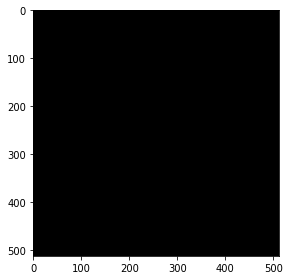

157


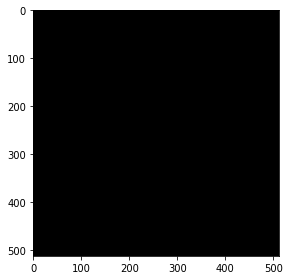

158


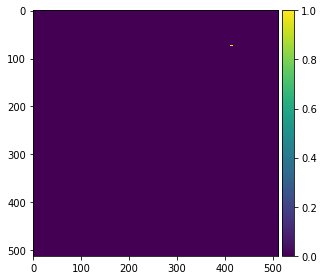

159


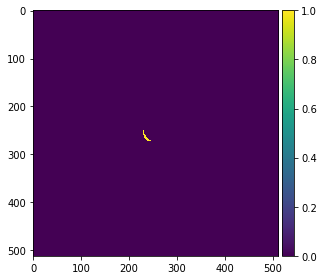

160


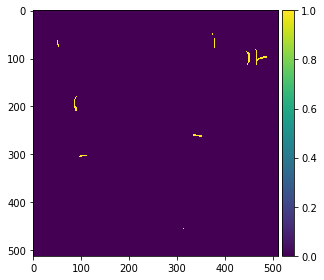

161


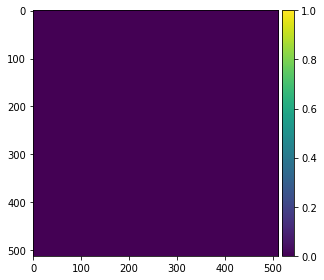

162


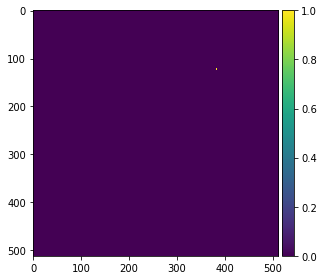

163


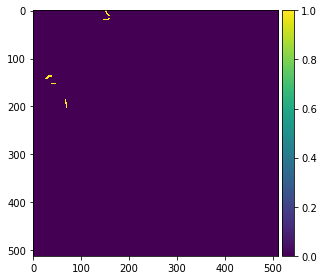

164


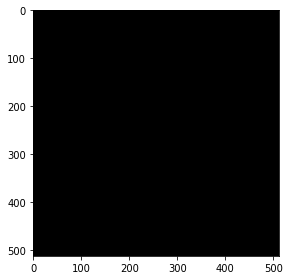

165


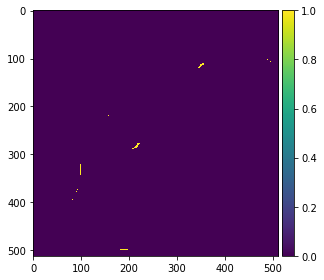

166


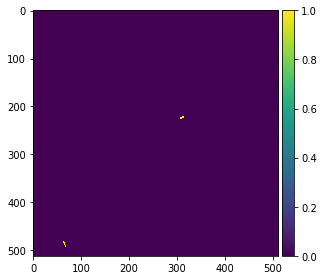

167


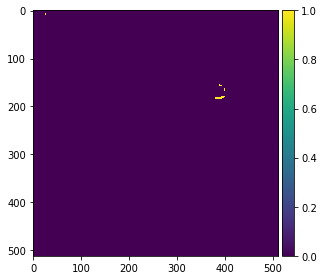

168


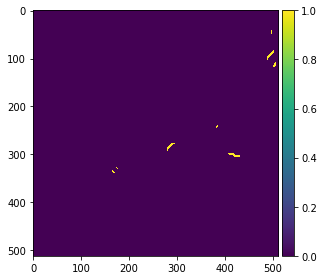

169


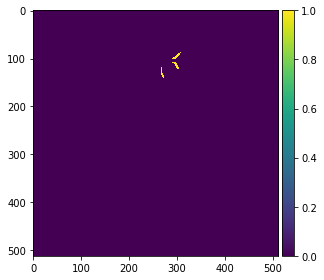

170


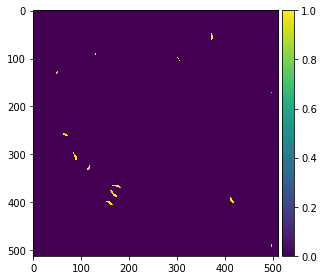

171


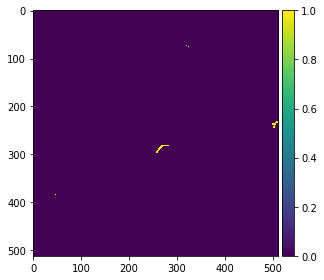

172


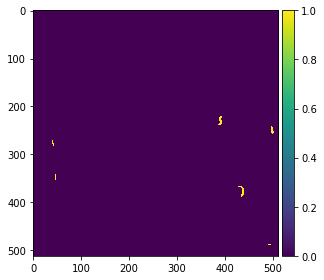

173


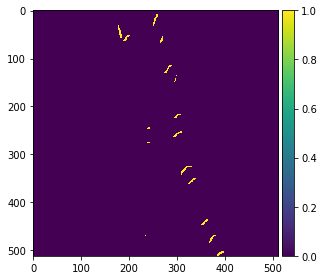

174


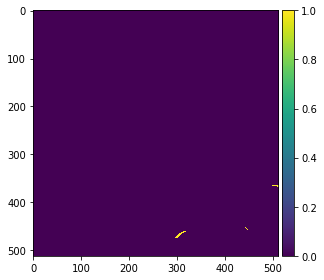

175


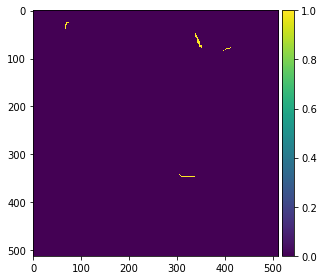

176


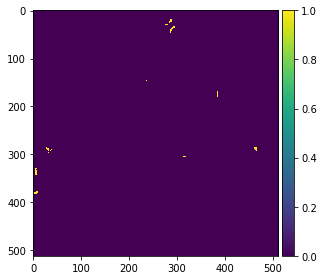

177


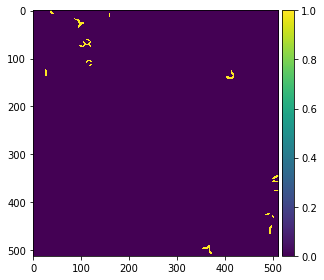

178


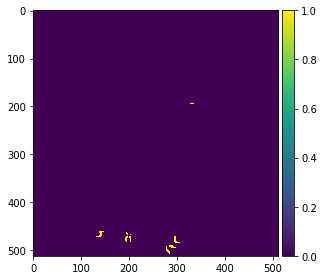

179


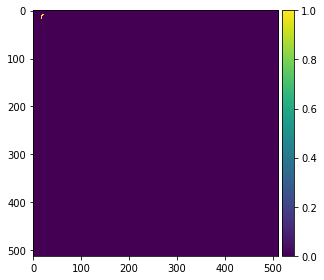

180


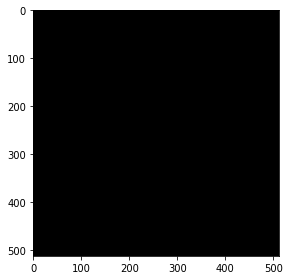

181


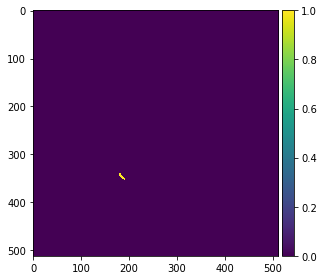

182


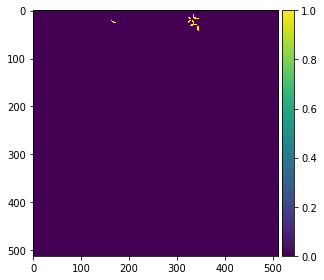

183


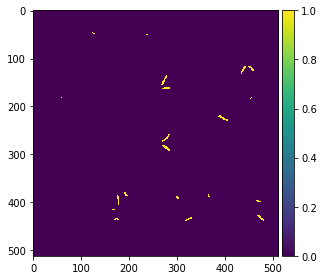

184


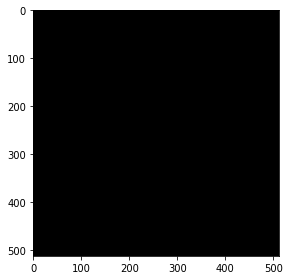

185


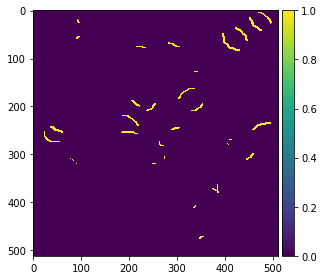

186


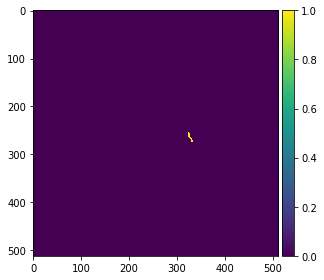

187


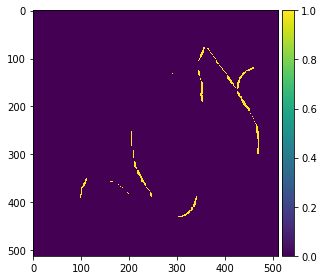

188


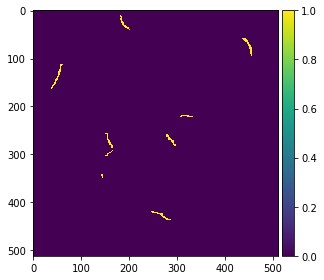

189


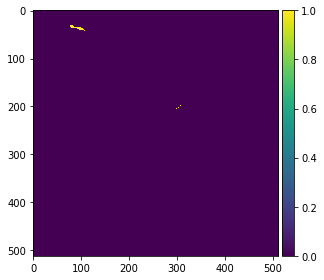

190


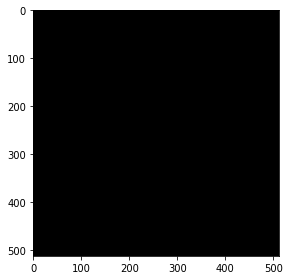

191


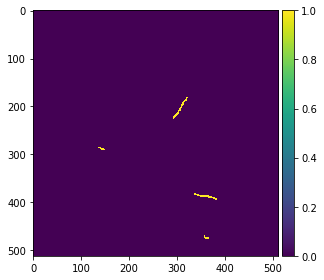

192


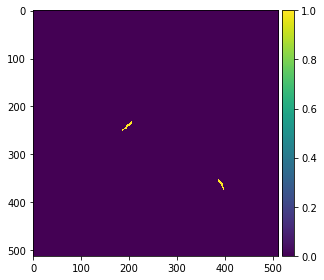

193


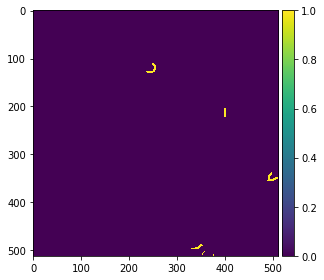

194


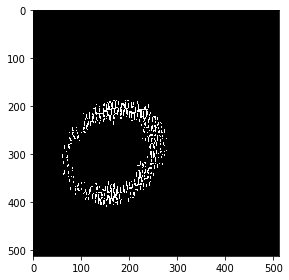

195


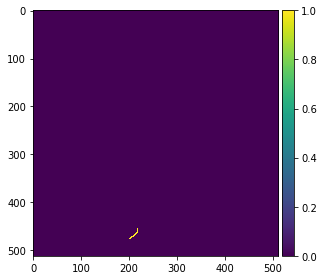

196


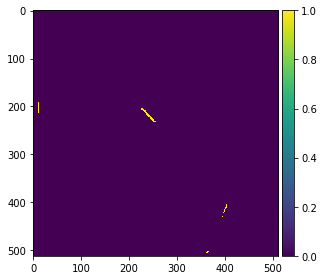

197


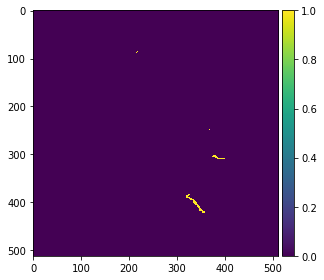

198


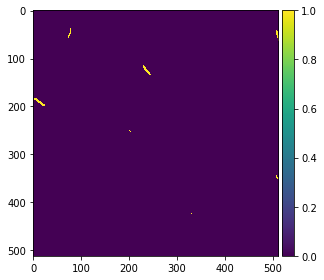

199


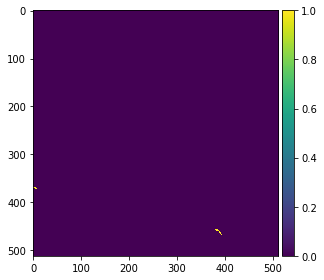

200


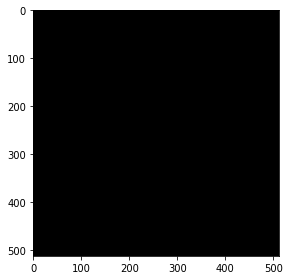

201


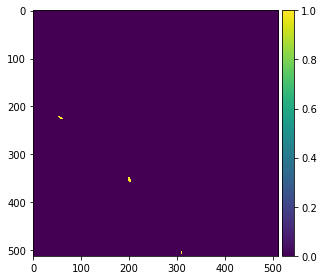

202


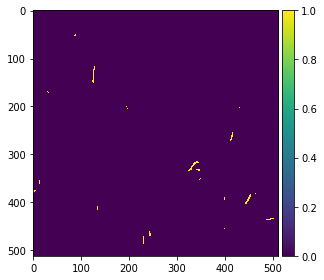

203


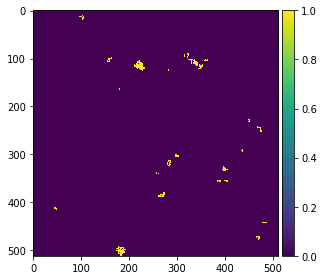

204


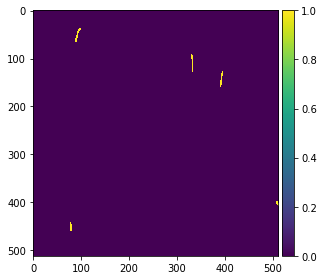

205


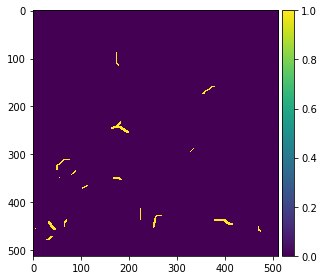

206


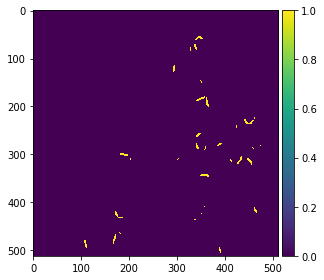

207


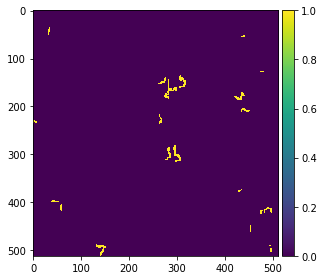

208


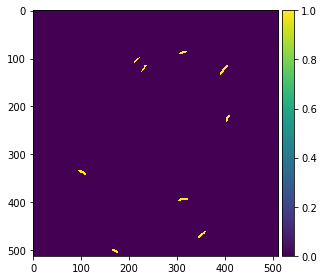

209


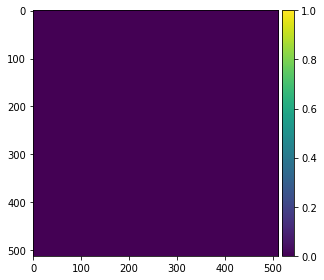

210


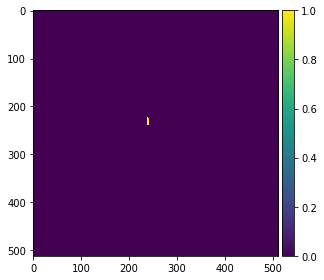

211


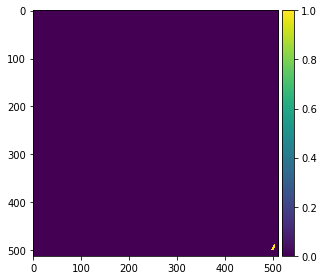

212


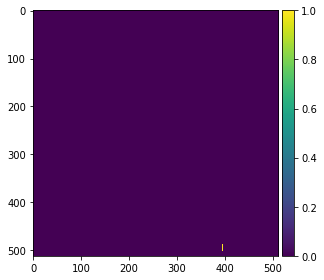

213


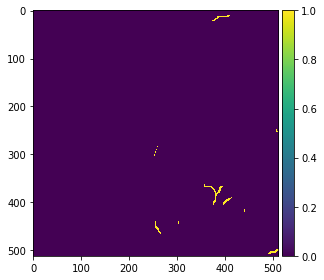

214


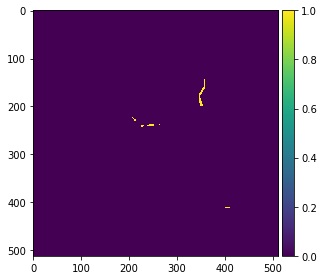

215


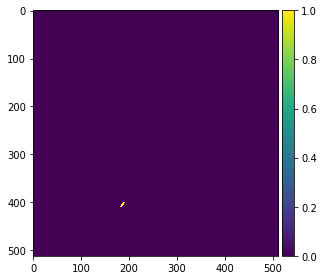

216


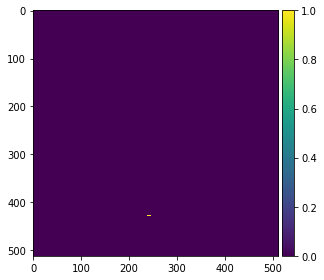

217


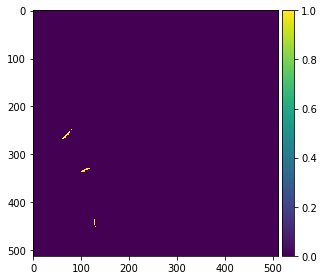

218


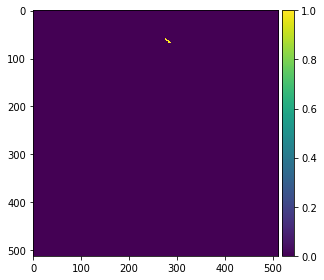

219


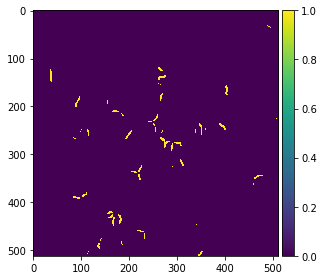

220


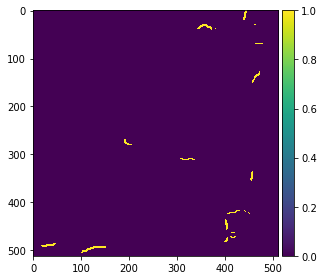

221


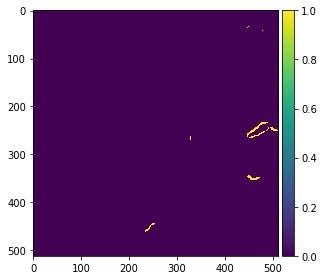

222


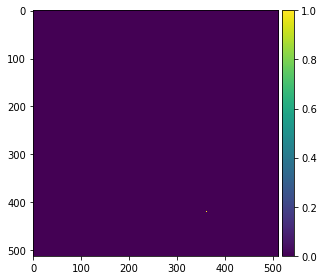

223


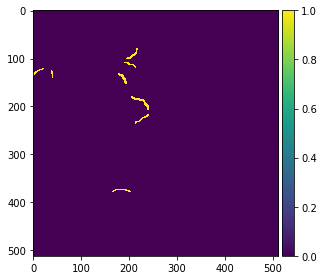

224


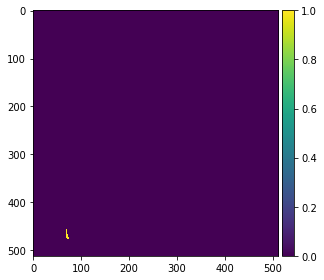

225


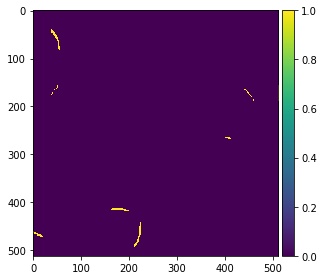

226


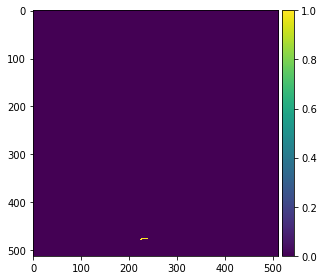

227


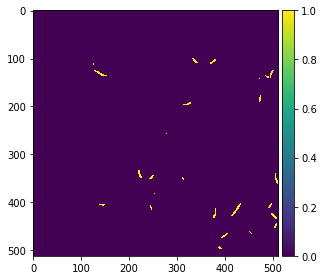

228


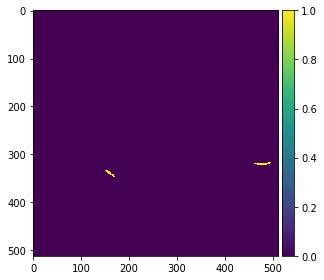

229


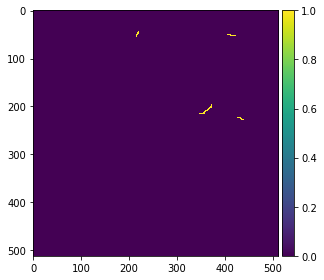

230


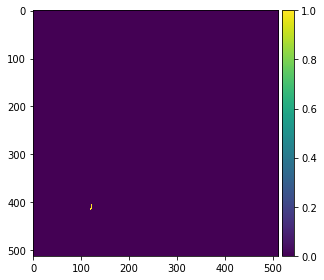

231


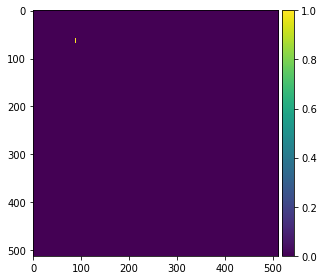

232


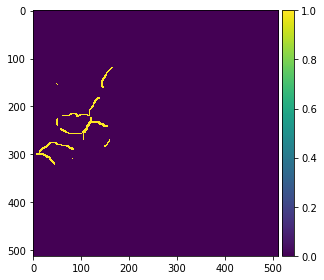

233


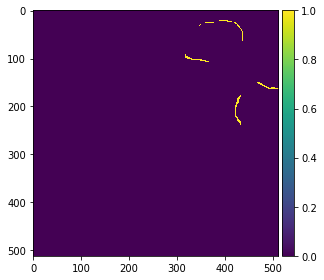

234


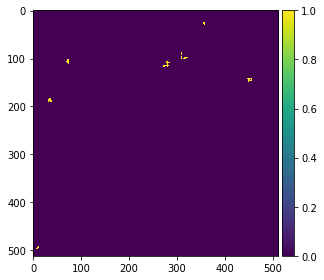

235


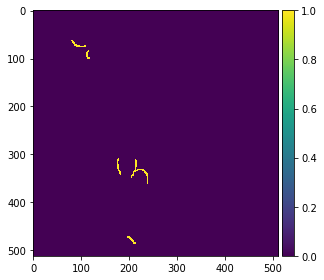

236


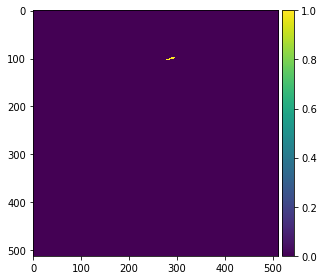

237


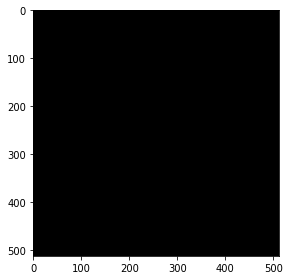

238


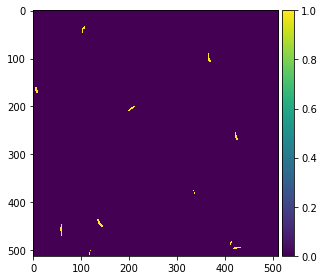

239


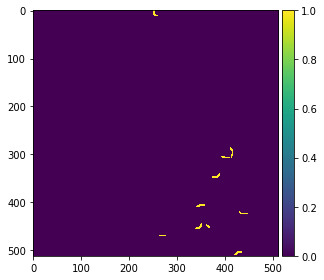

240


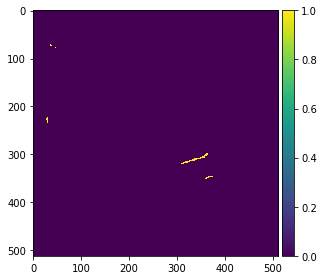

241


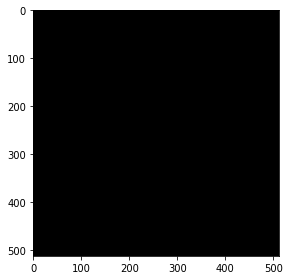

242


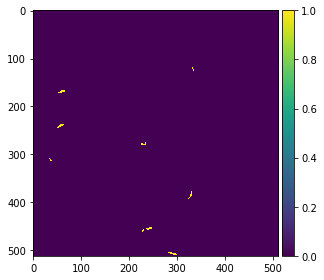

243


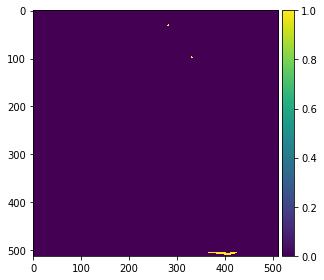

244


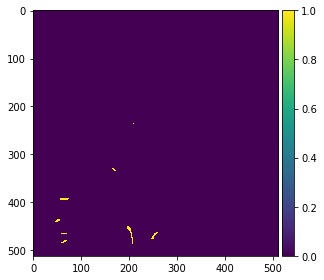

245


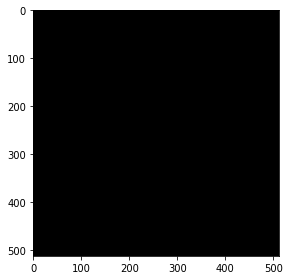

246


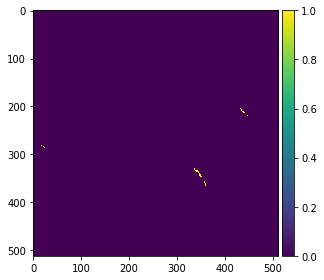

247


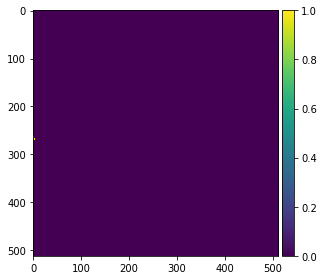

248


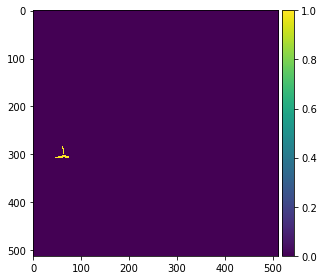

249


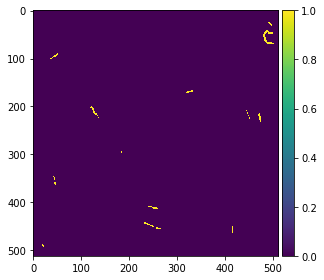

250


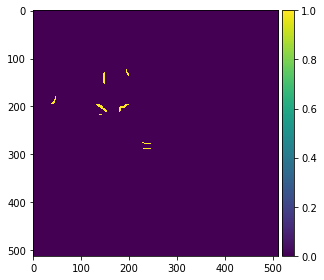

251


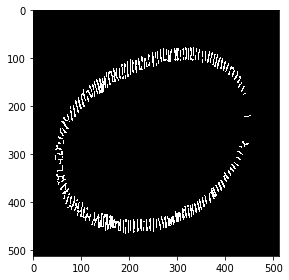

252


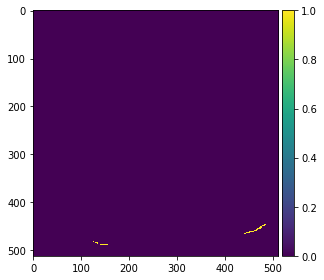

253


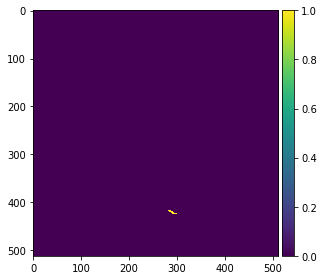

254


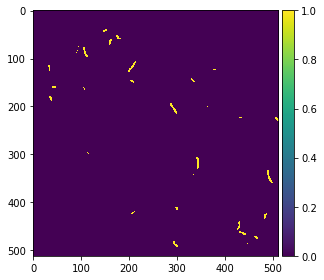

255


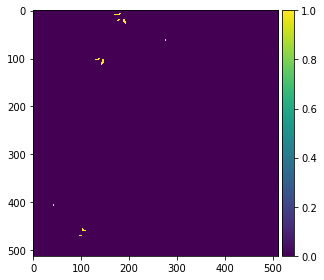

256


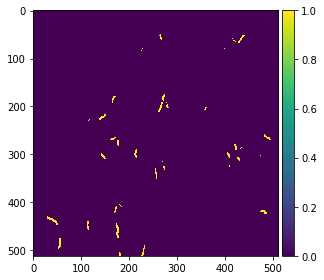

257


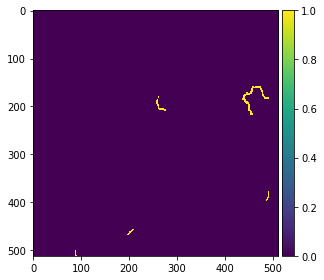

258


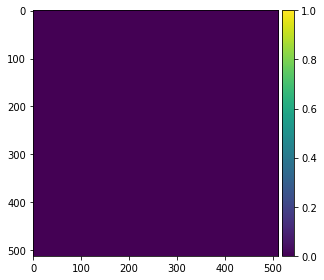

259


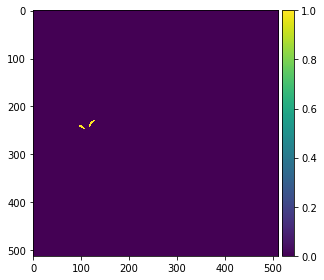

260


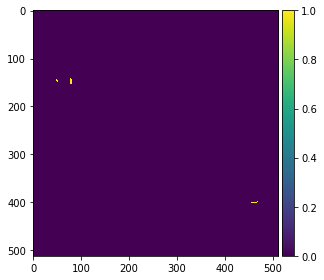

261


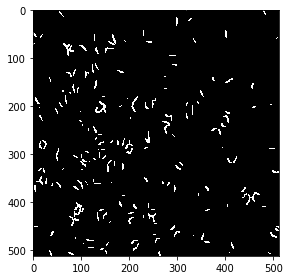

262


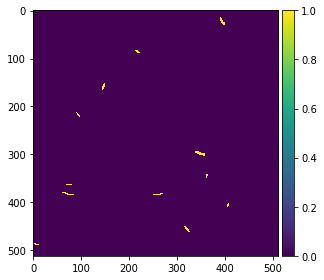

263


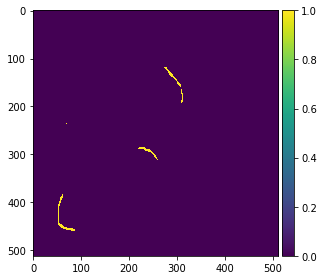

264


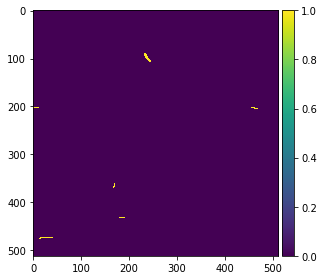

265


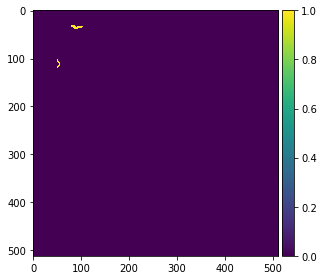

266


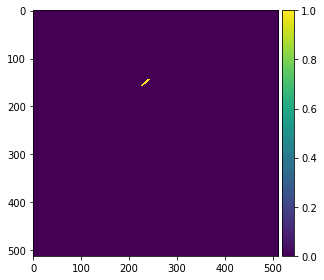

267


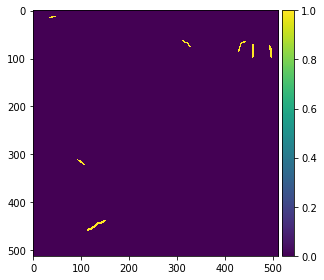

268


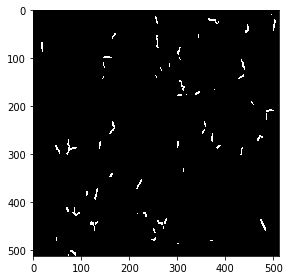

269


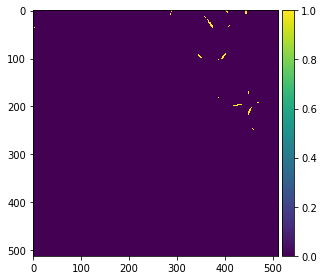

270


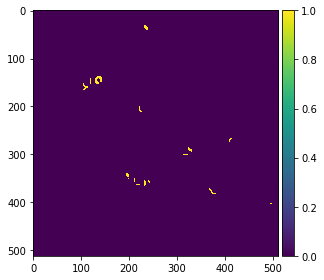

271


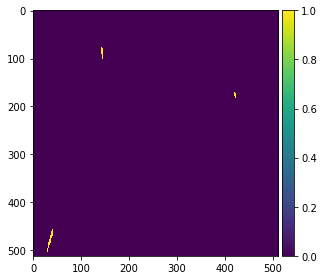

272


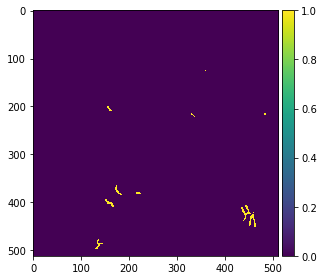

273


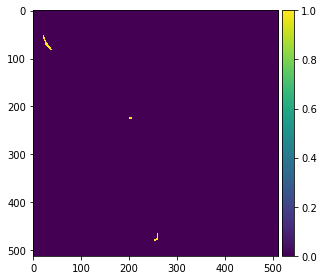

274


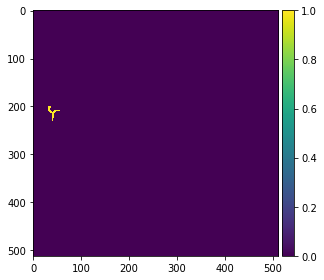

275


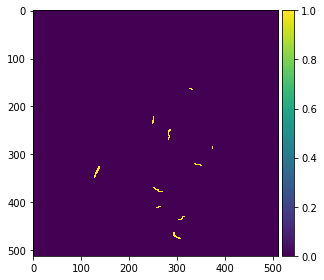

276


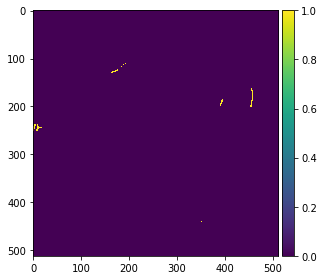

277


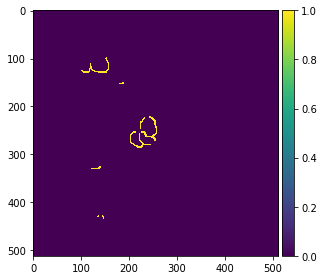

278


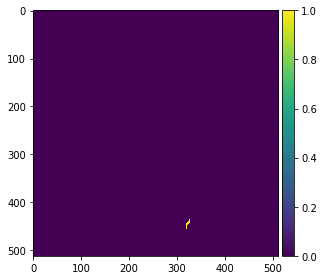

279


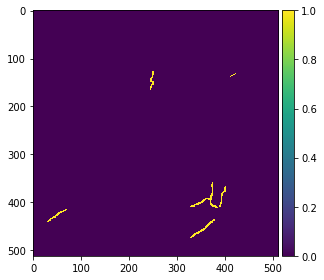

280


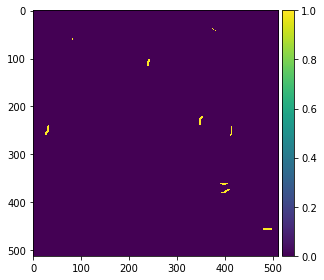

281


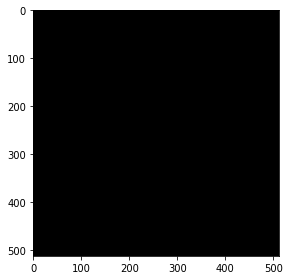

282


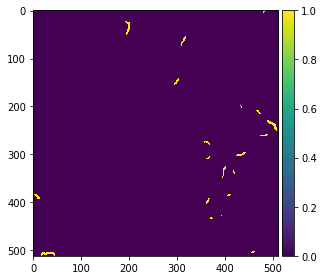

283


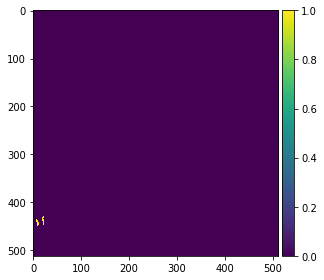

284


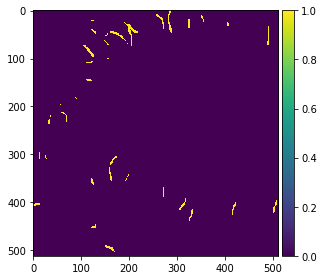

285


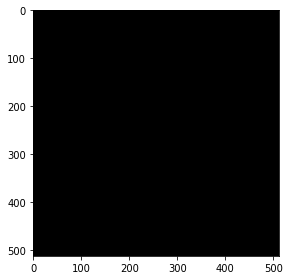

286


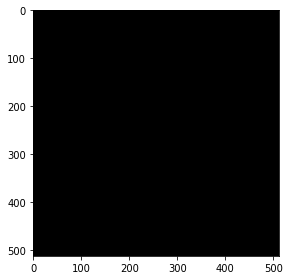

287


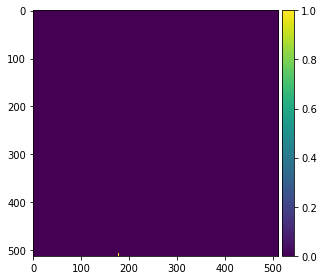

288


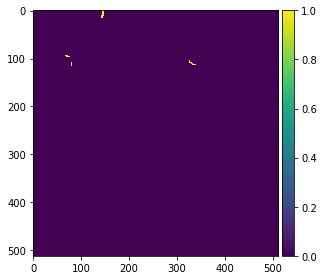

289


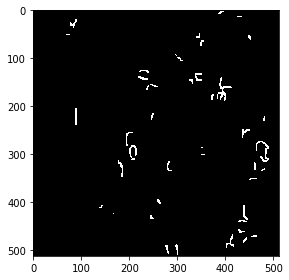

290


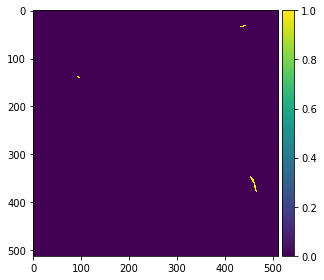

291


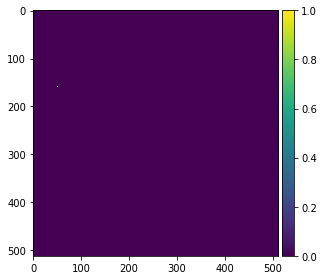

292


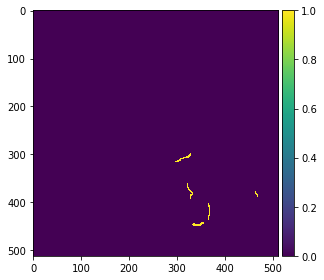

293


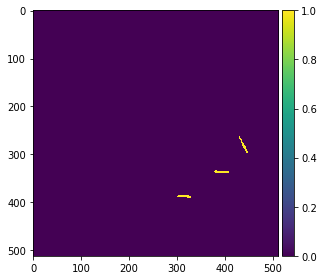

294


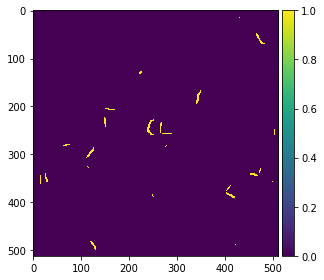

295


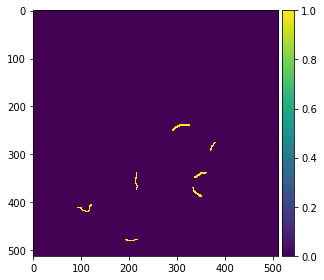

296


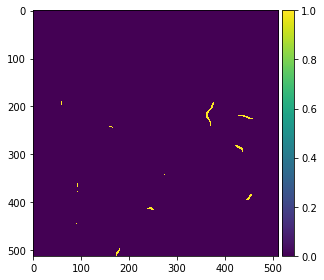

297


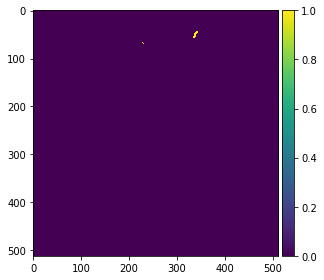

298


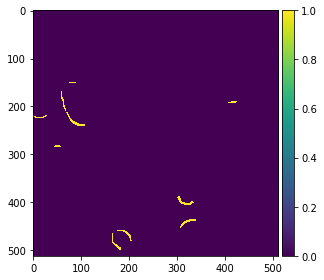

299


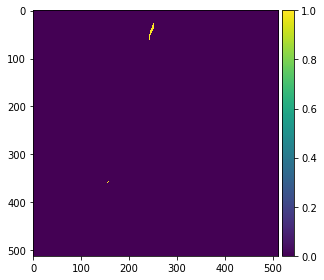

300


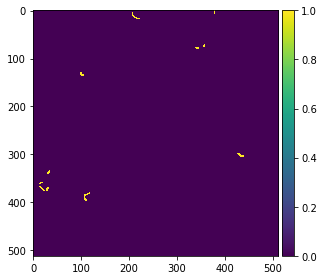

301


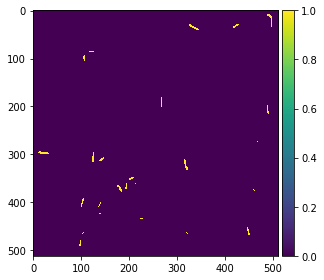

302


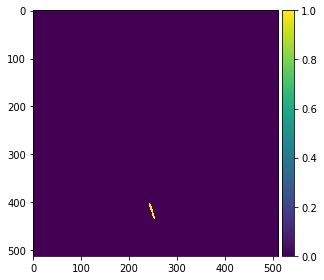

303


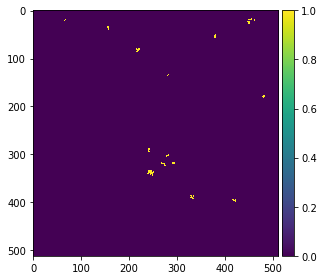

304


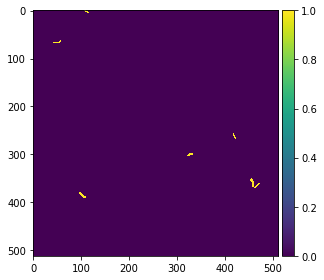

305


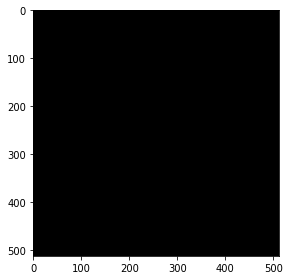

306


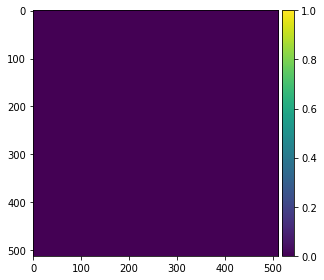

307


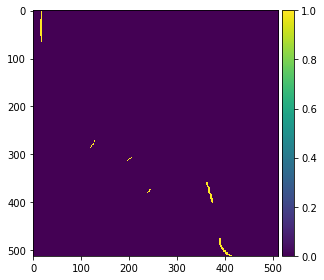

308


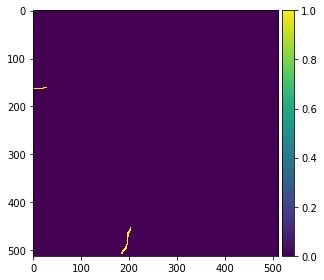

309


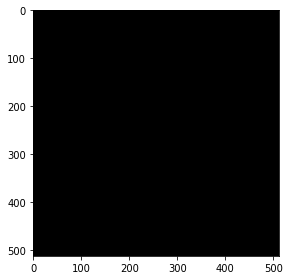

310


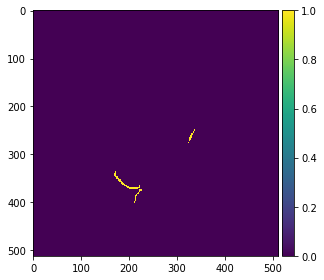

311


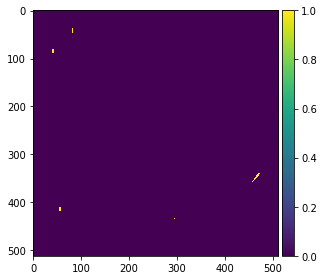

312


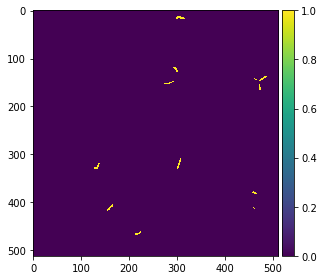

313


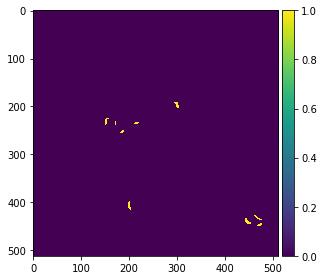

314


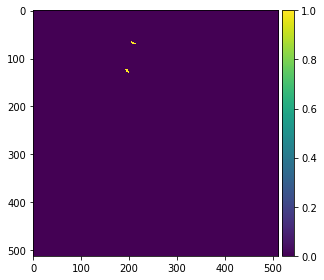

315


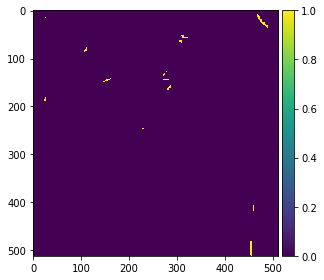

316


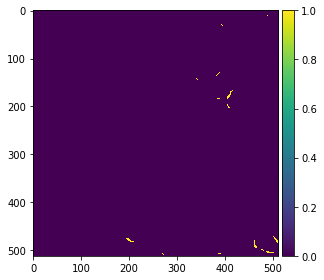

317


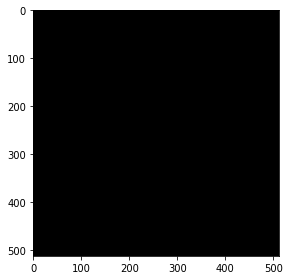

318


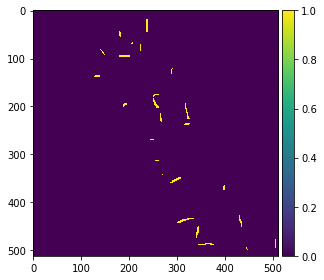

319


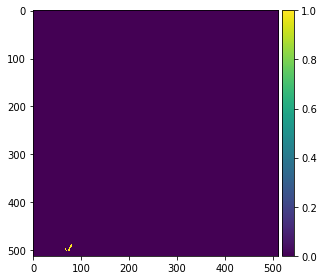

320


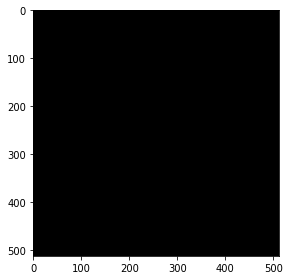

321


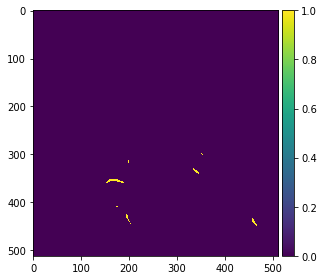

322


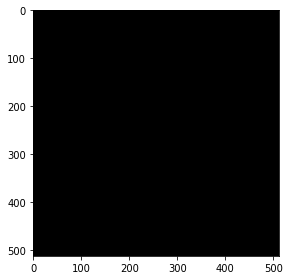

323


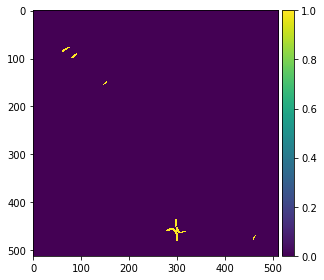

324


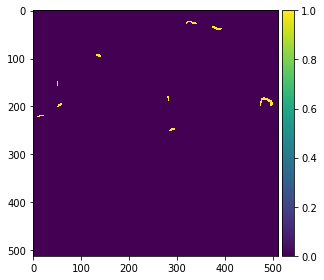

325


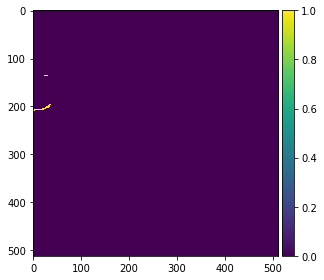

326


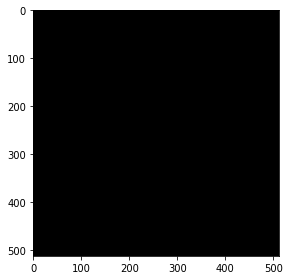

327


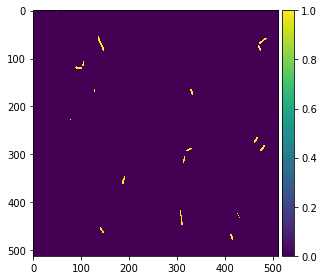

328


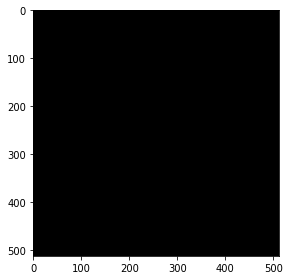

329


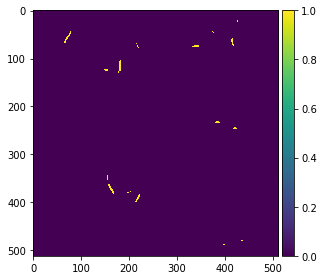

330


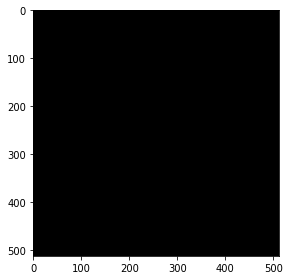

331


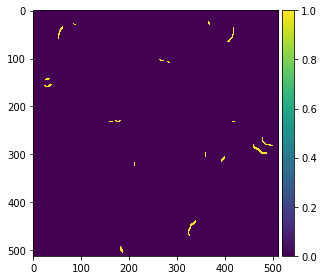

332


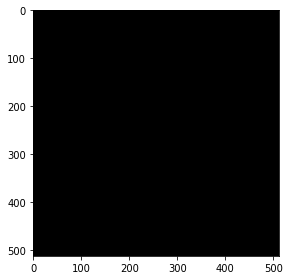

333


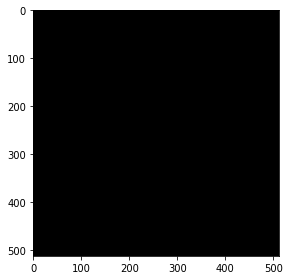

334


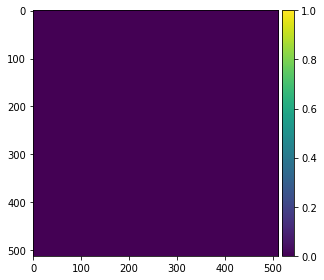

335


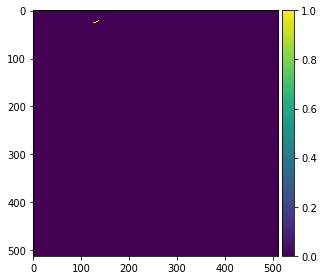

336


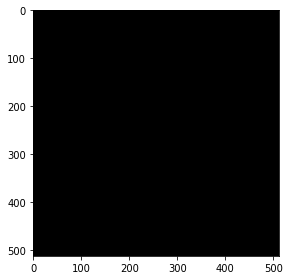

337


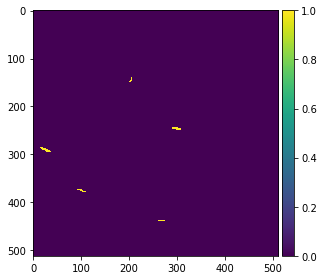

338


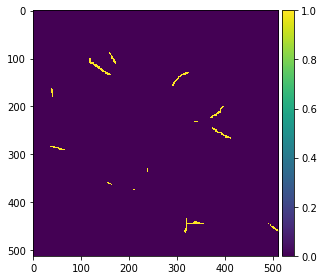

339


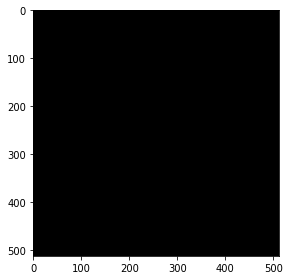

340


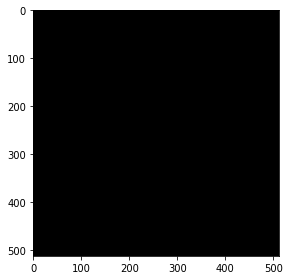

341


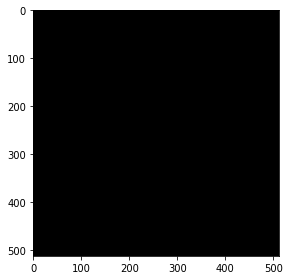

342


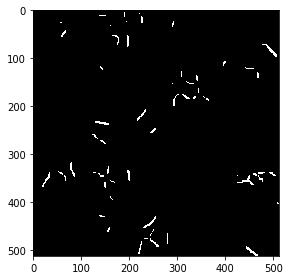

343


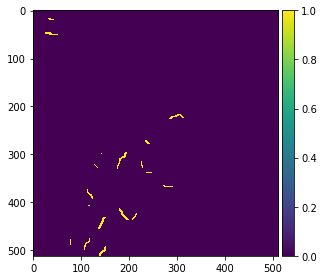

344


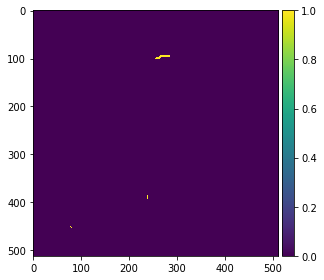

345


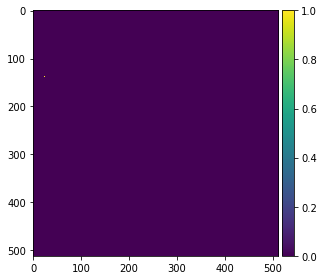

346


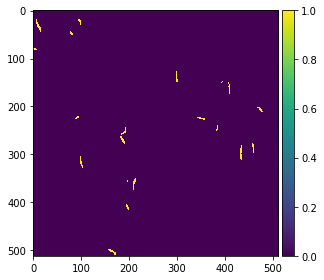

347


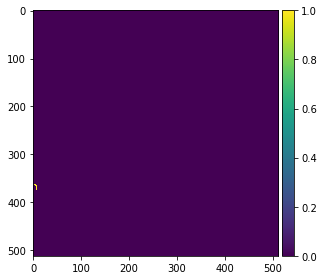

348


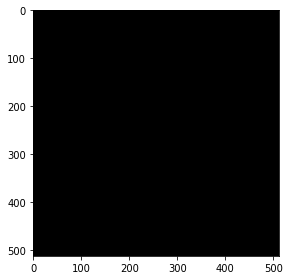

349


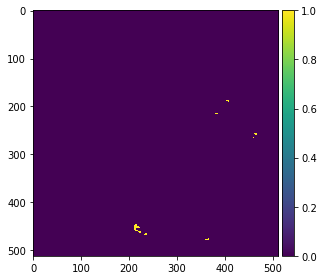

350


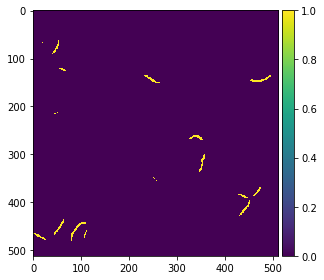

351


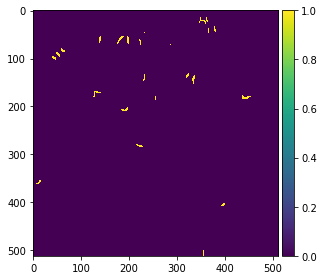

352


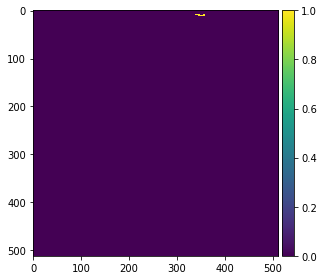

353


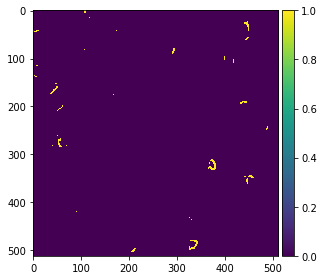

354


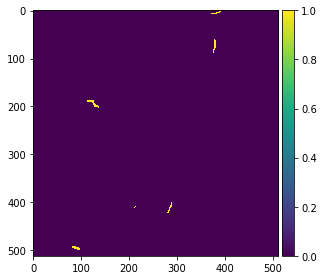

355


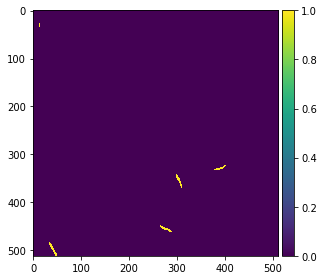

356


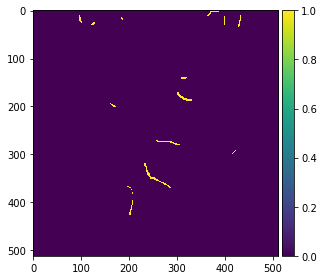

357


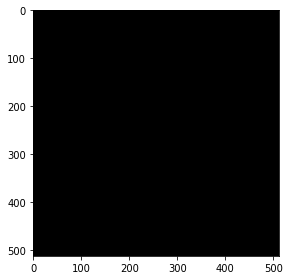

358


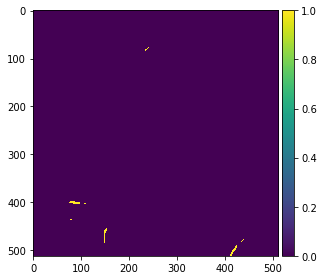

359


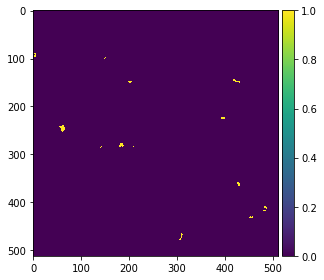

360


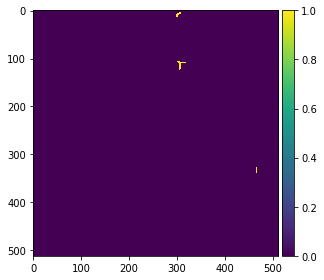

361


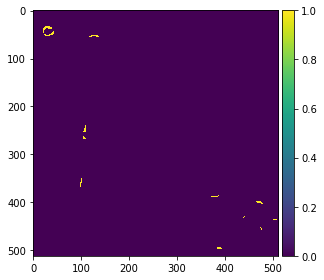

362


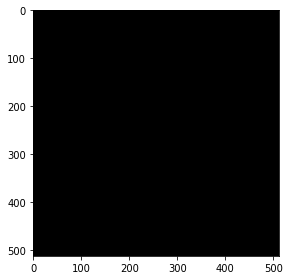

363


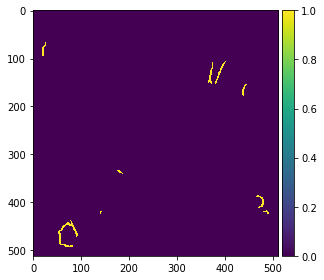

364


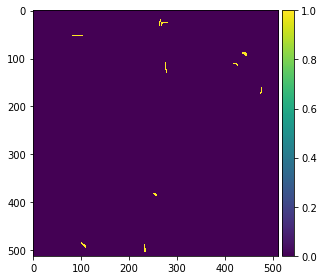

365


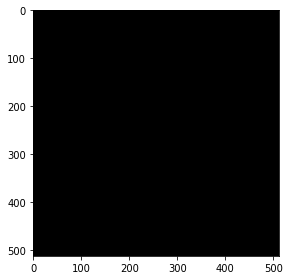

366


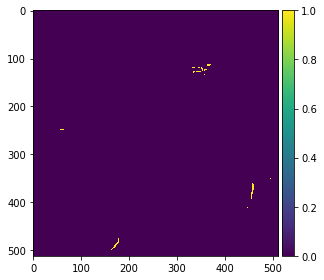

367


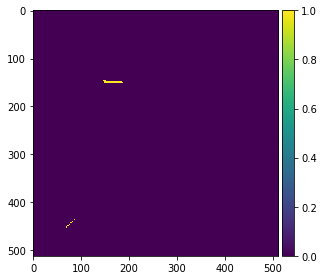

368


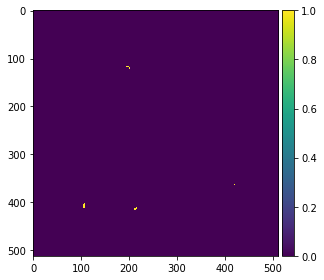

369


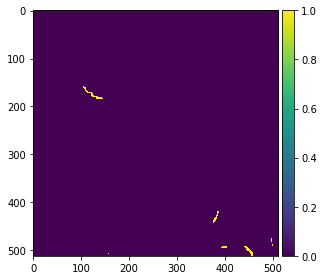

370


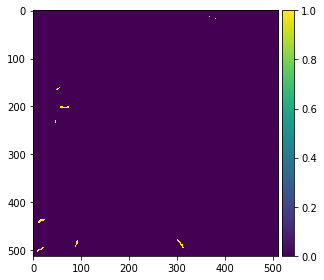

371


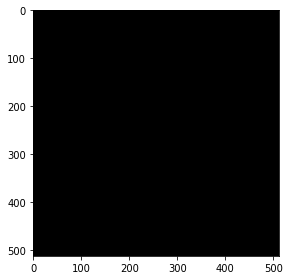

372


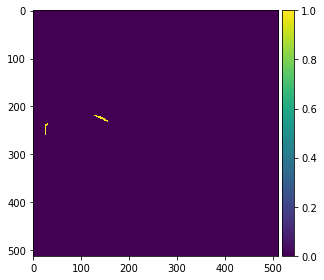

373


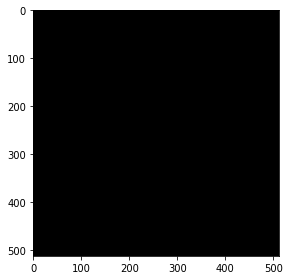

374


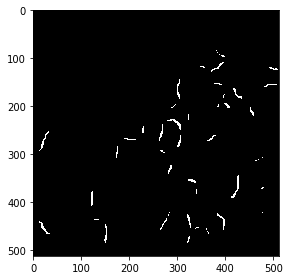

375


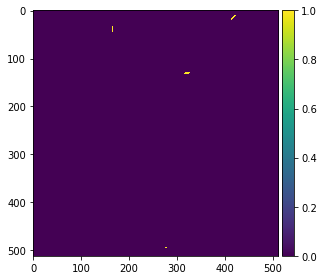

376


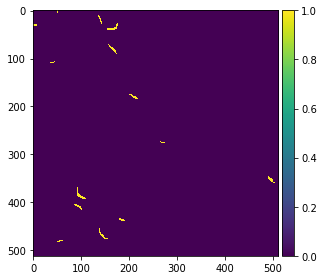

377


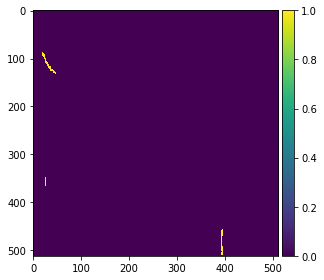

378


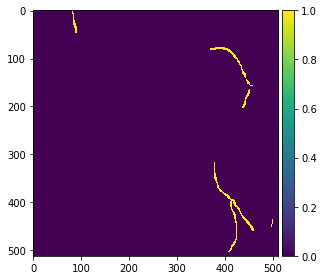

379


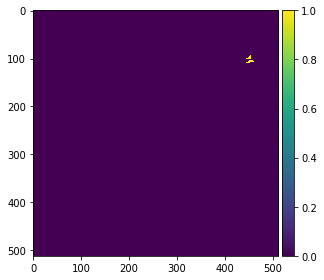

380


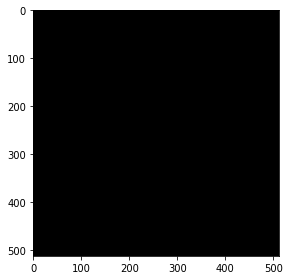

381


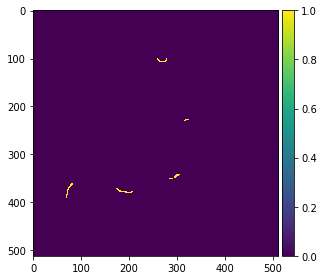

382


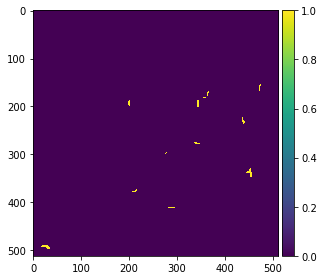

383


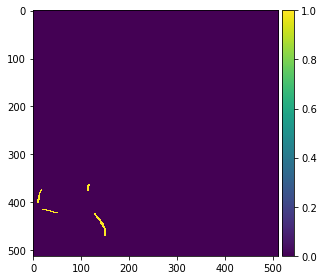

384


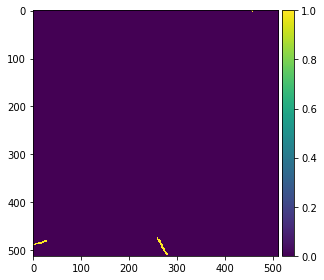

385


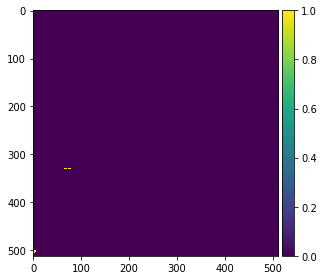

386


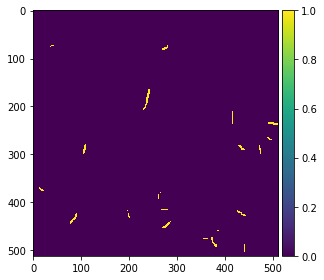

387


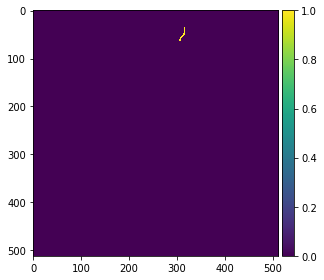

388


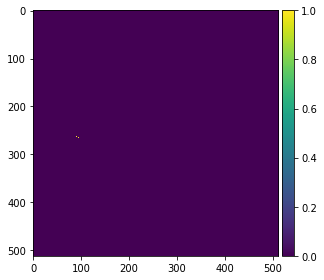

389


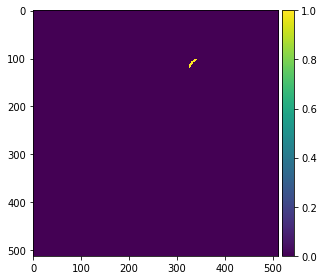

390


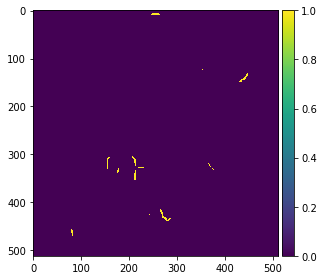

391


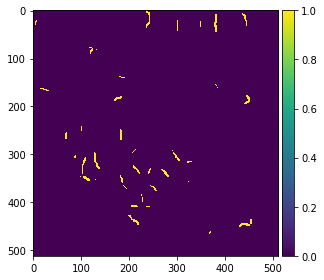

392


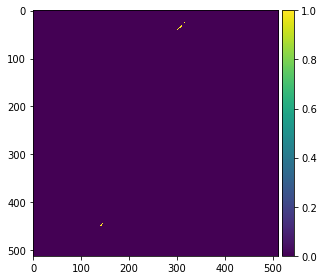

393


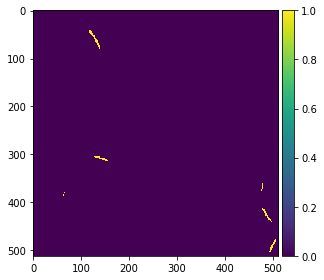

394


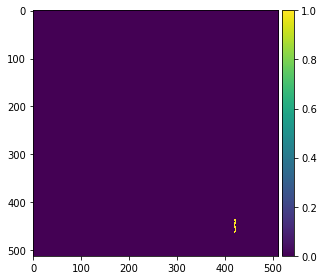

395


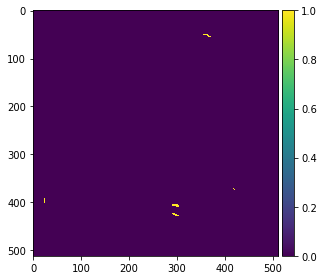

396


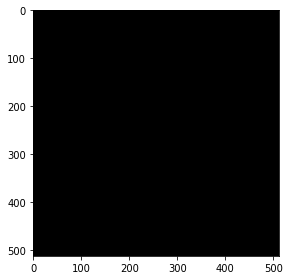

397


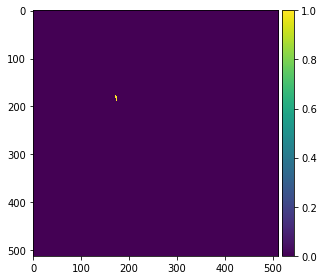

398


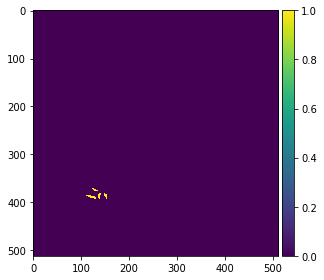

399


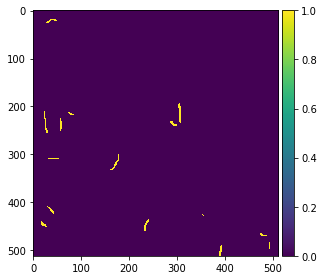

400


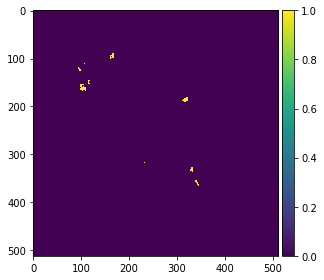

401


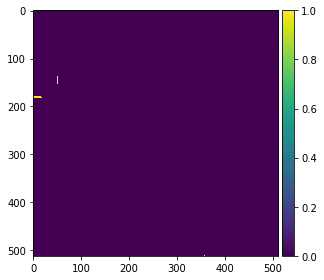

402


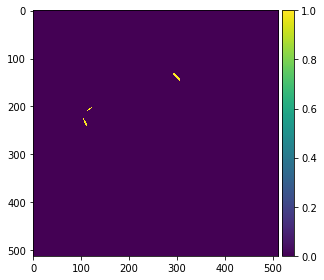

403


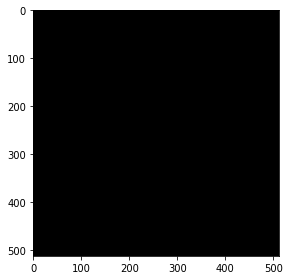

404


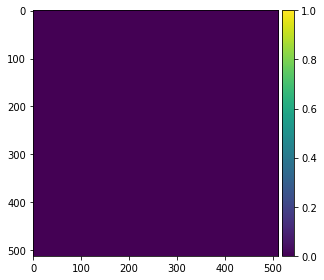

405


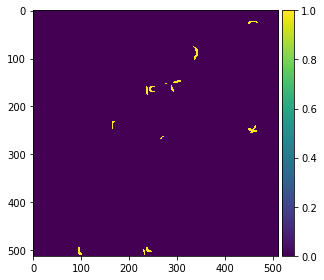

406


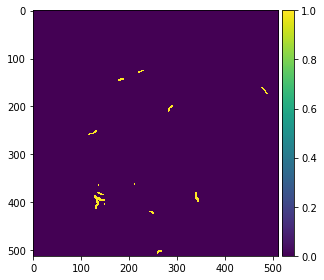

407


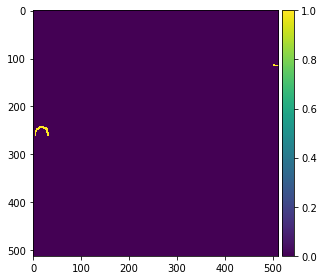

408


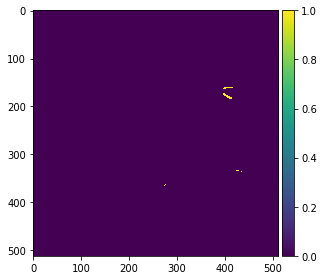

409


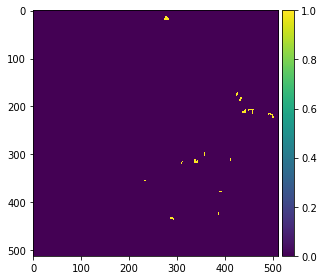

410


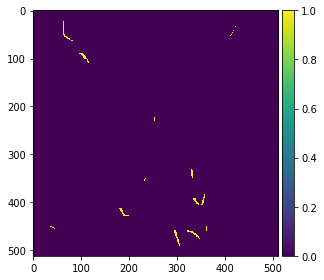

411


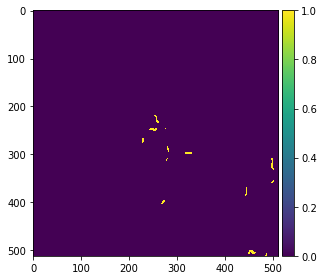

412


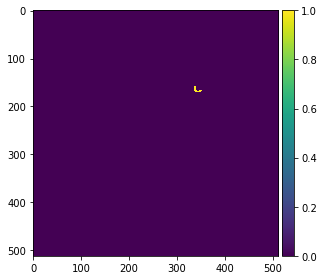

413


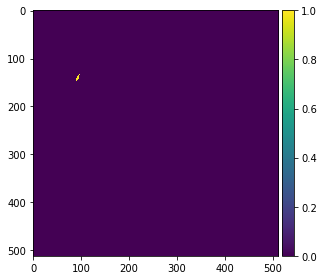

414


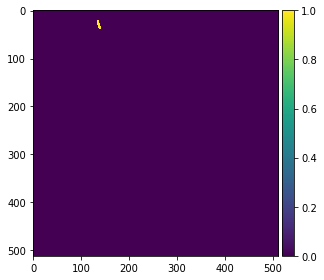

415


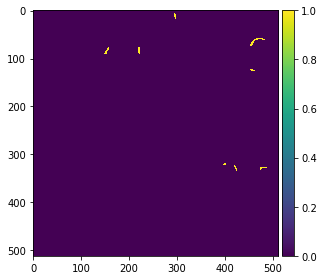

416


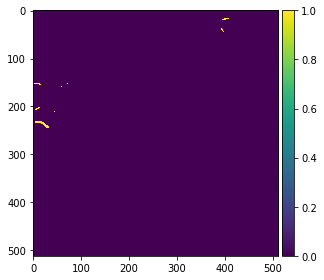

417


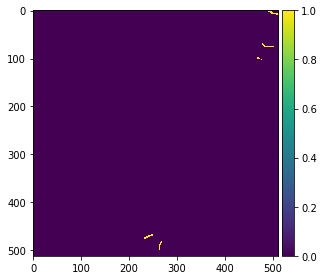

418


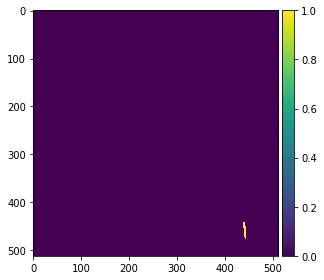

419


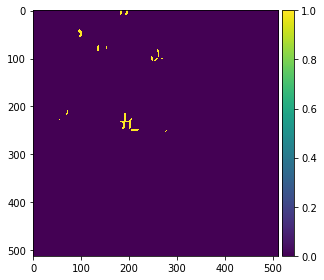

420


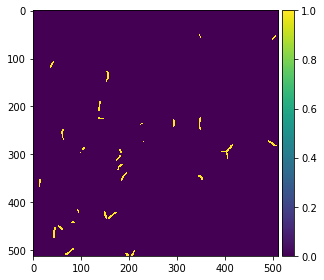

421


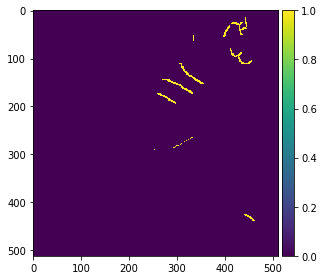

422


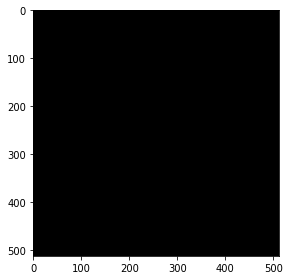

423


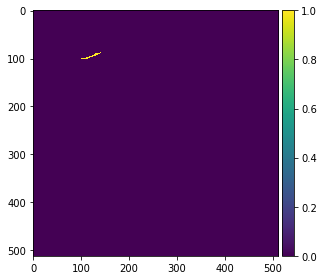

424


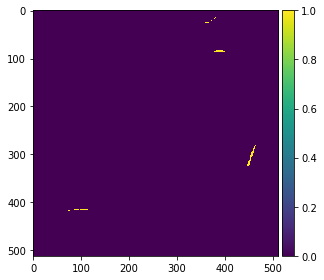

425


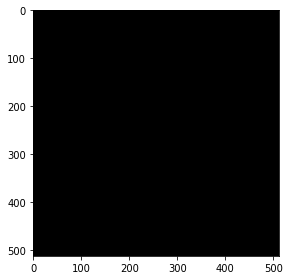

426


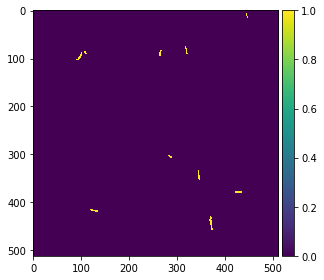

427


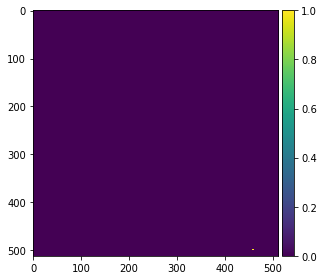

428


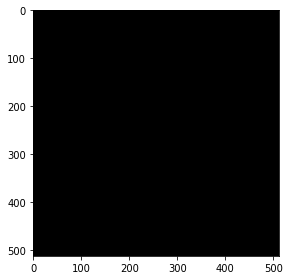

429


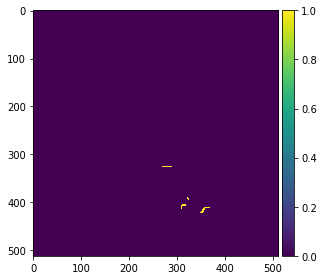

430


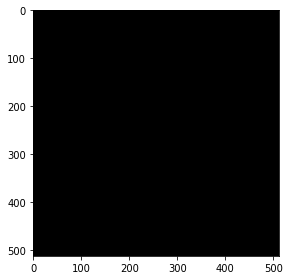

431


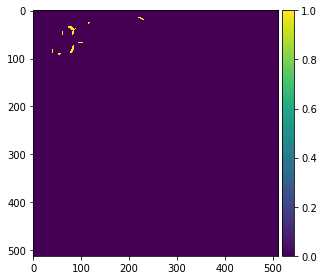

432


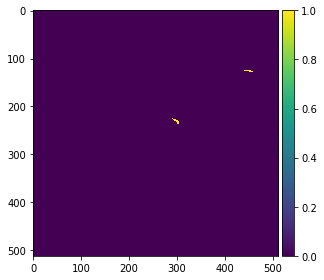

433


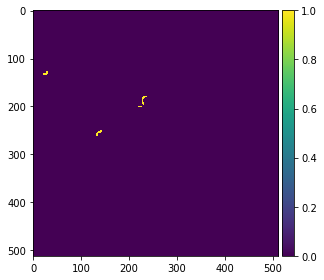

434


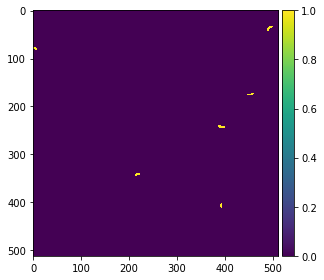

435


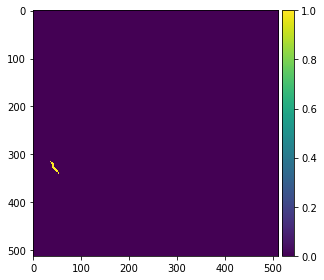

436


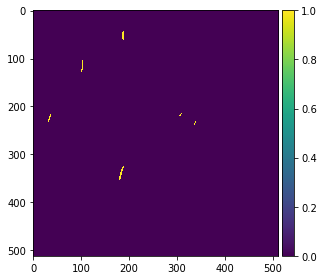

437


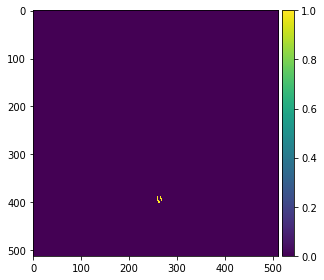

438


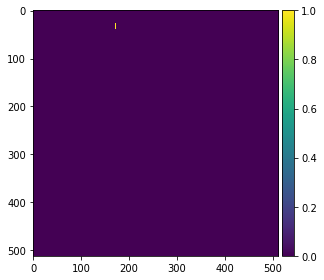

439


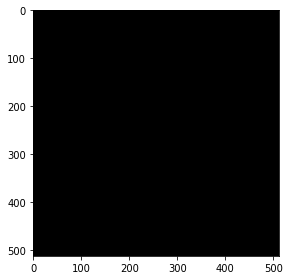

440


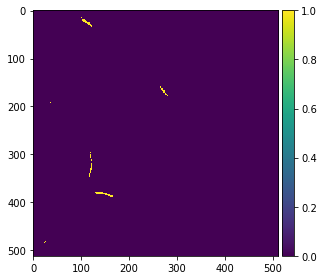

441


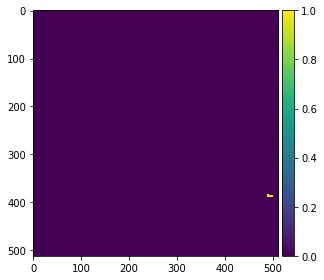

442


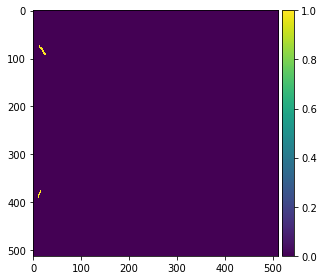

443


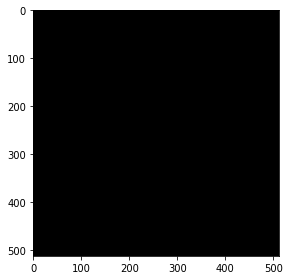

444


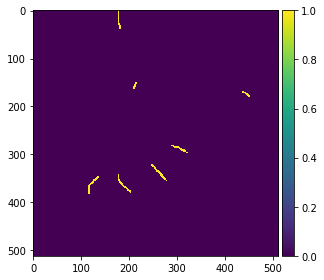

445


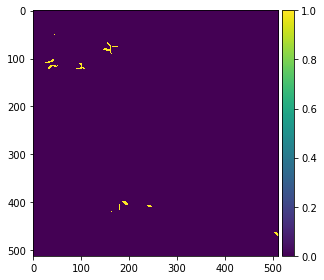

446


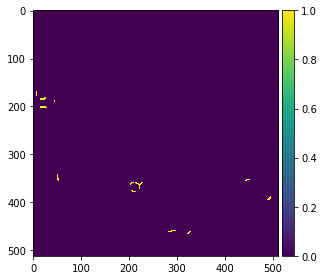

447


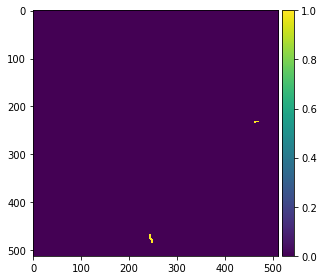

448


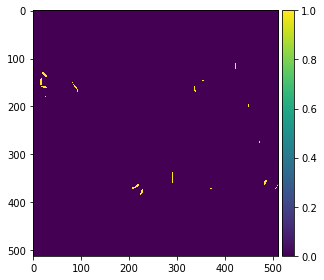

449


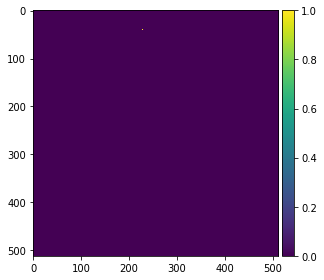

450


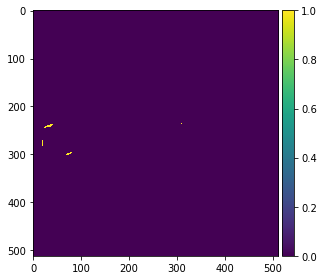

451


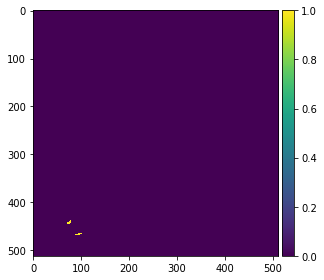

452


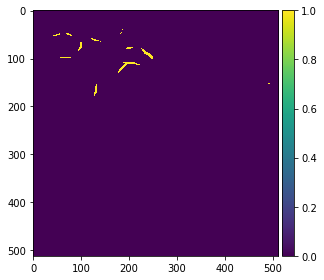

453


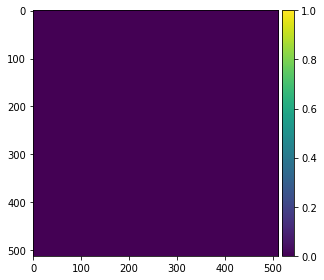

454


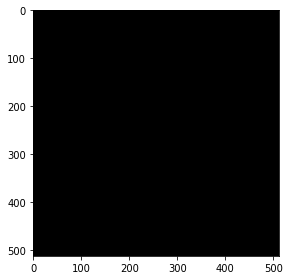

455


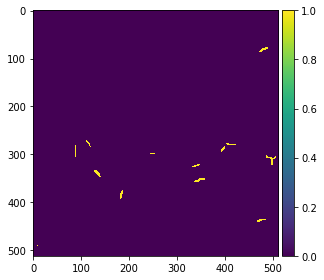

456


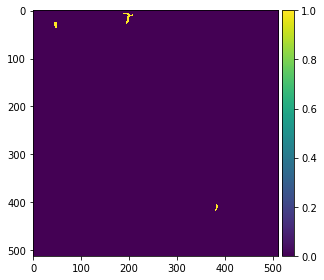

457


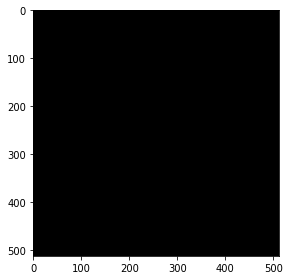

458


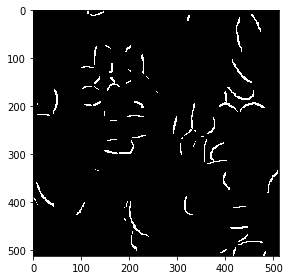

459


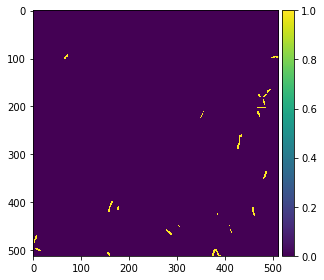

460


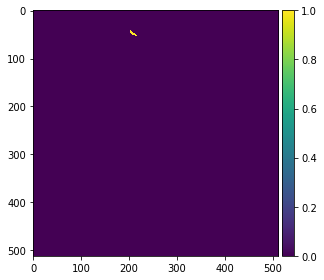

461


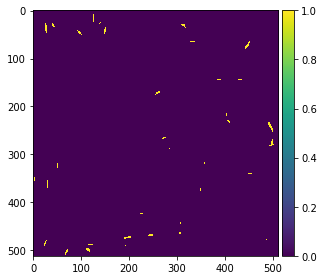

462


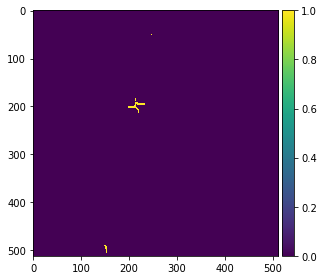

463


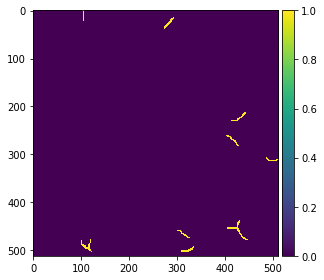

464


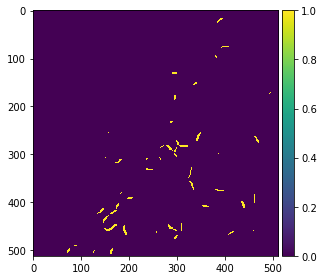

465


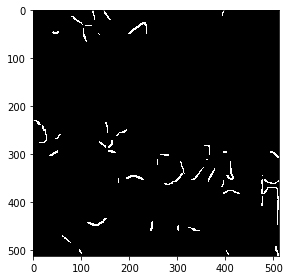

466


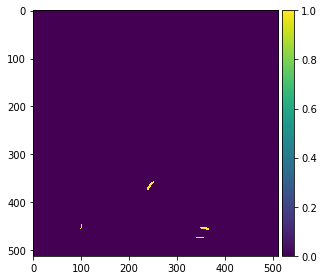

467


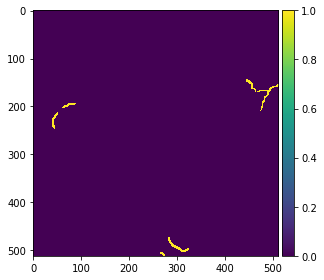

468


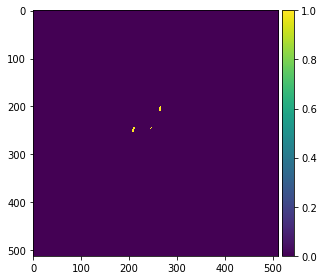

469


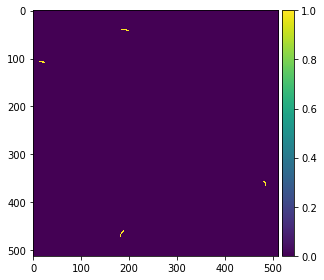

470


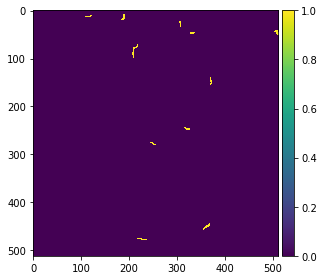

471


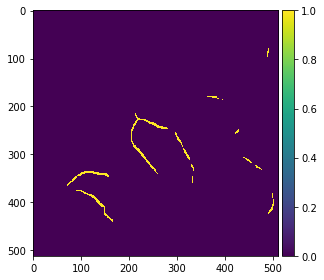

472


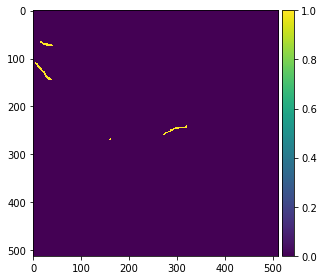

473


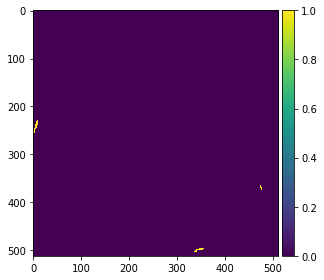

474


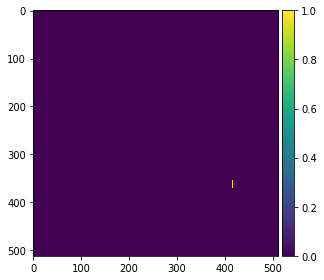

475


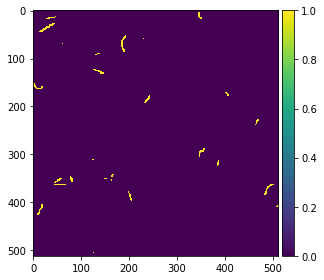

476


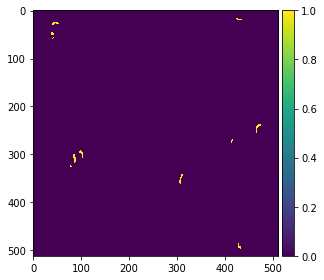

477


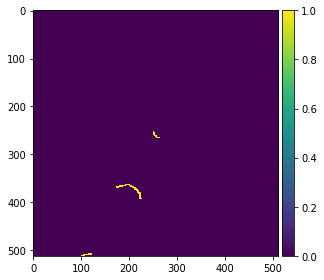

478


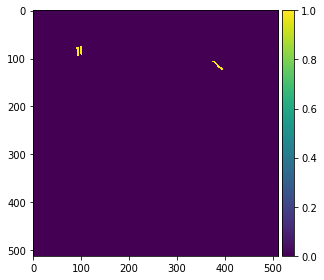

479


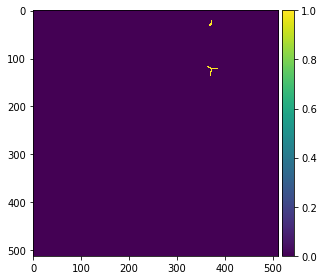

480


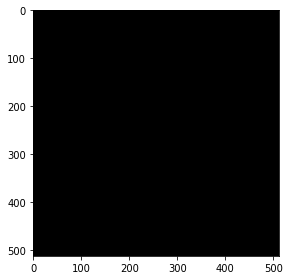

481


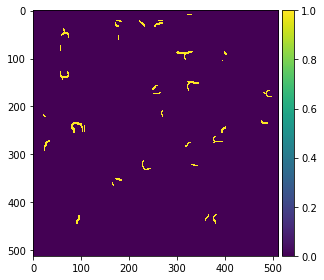

482


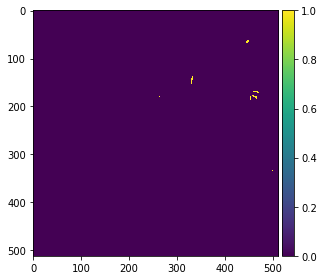

483


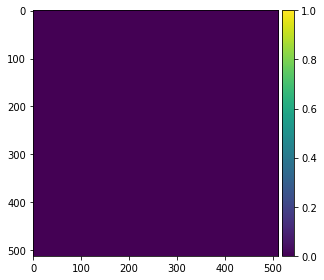

484


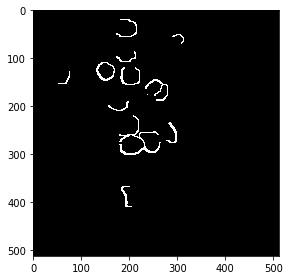

485


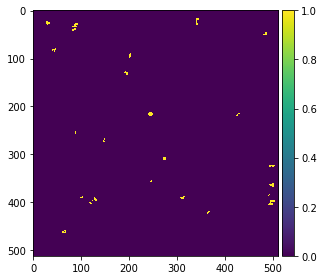

486


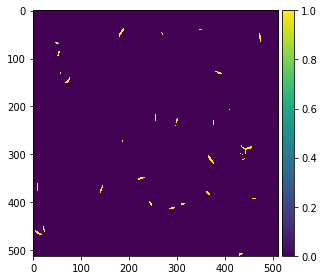

487


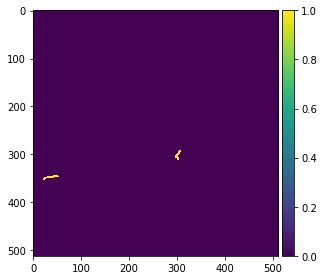

488


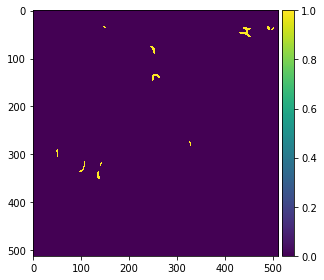

489


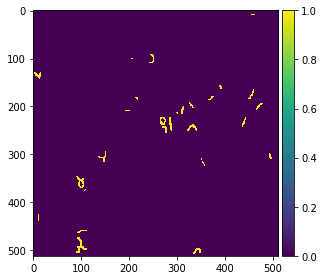

490


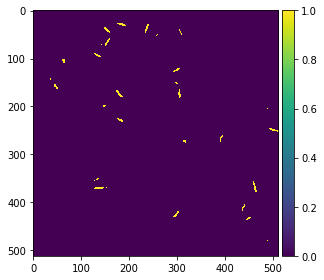

491


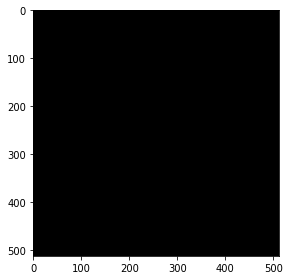

492


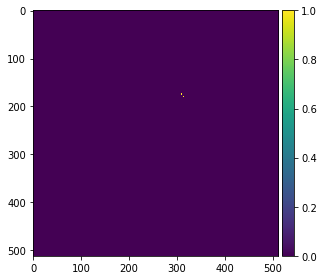

493


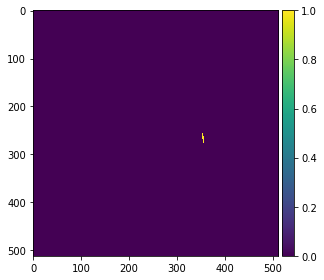

494


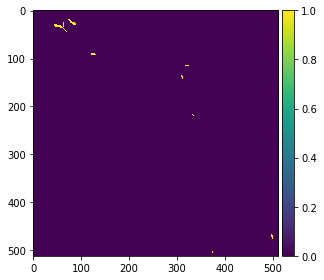

495


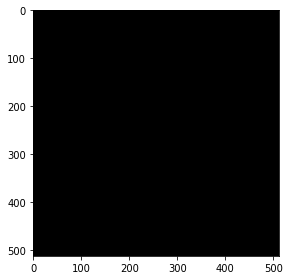

496


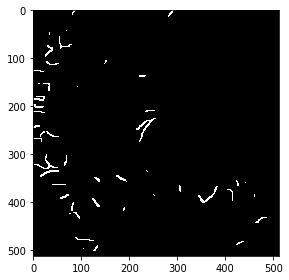

497


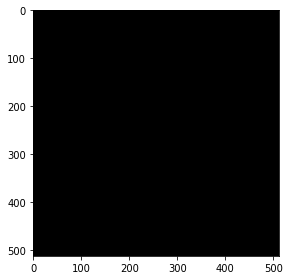

498


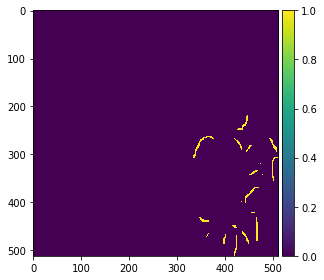

499


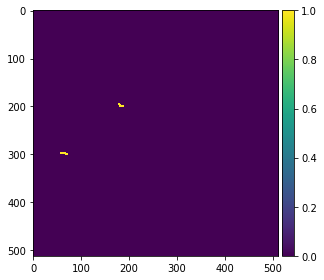

500


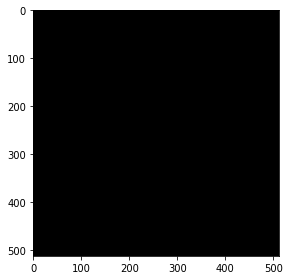

501


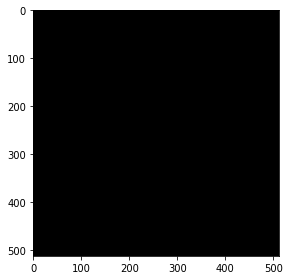

502


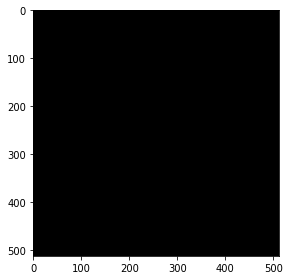

503


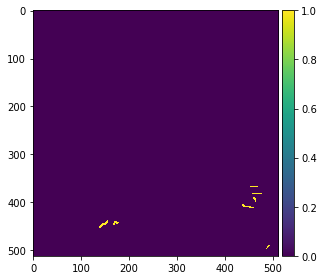

504


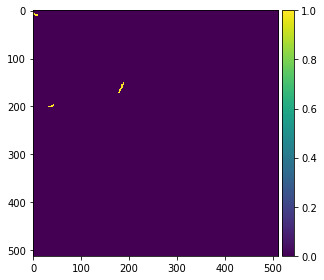

505


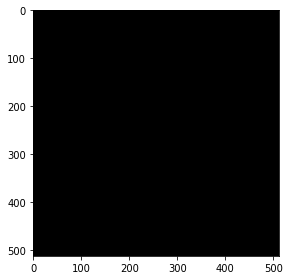

506


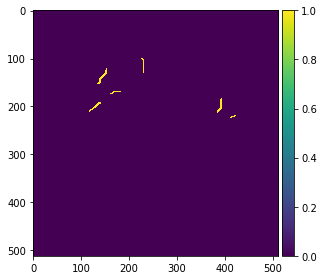

507


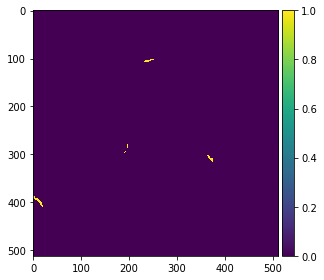

508


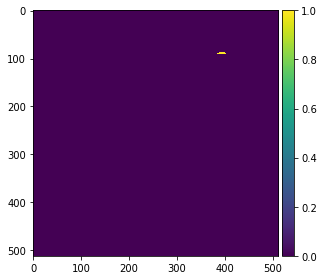

509


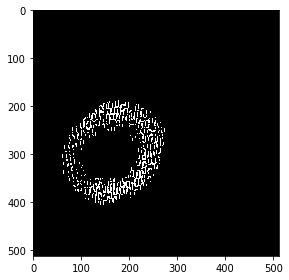

510


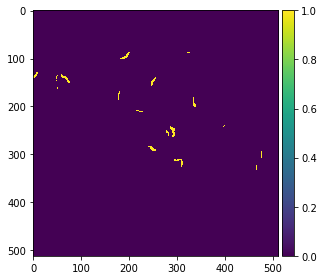

511


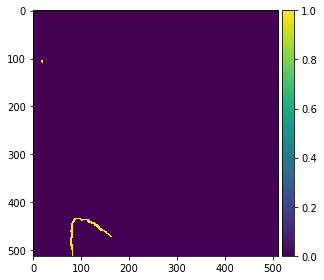

512


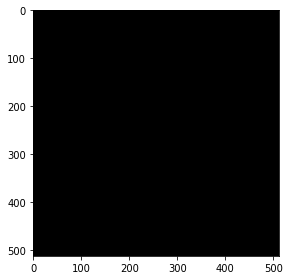

513


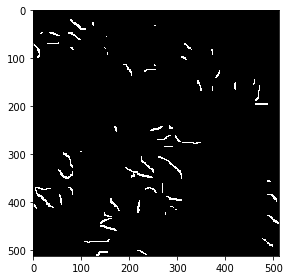

514


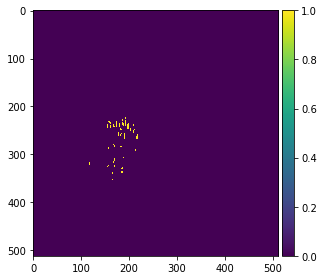

515


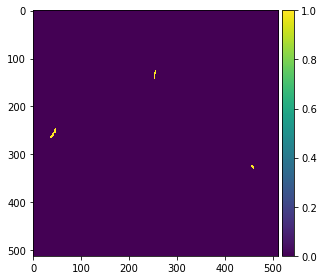

516


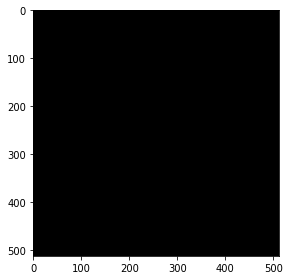

517


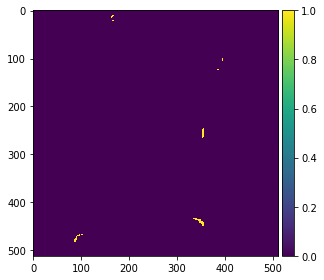

518


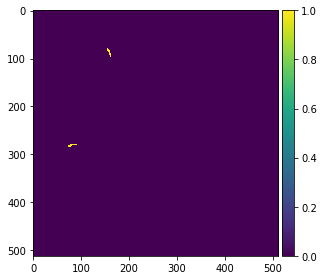

519


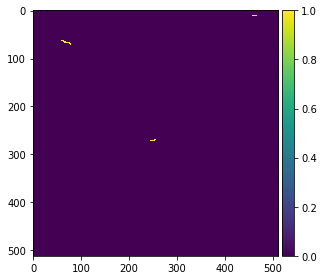

520


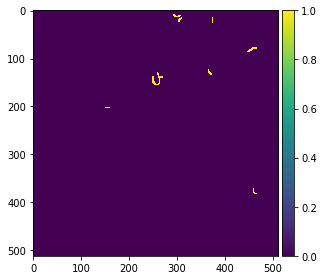

521


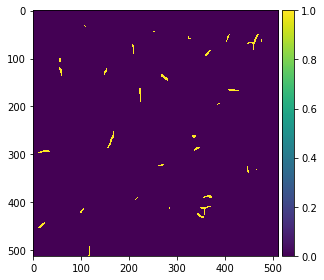

522


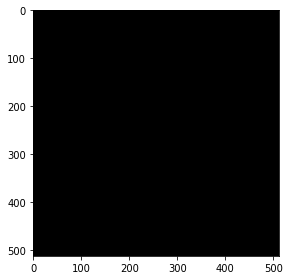

523


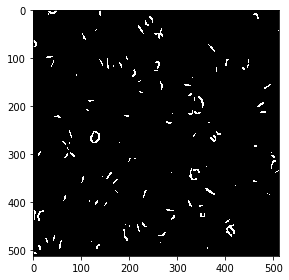

524


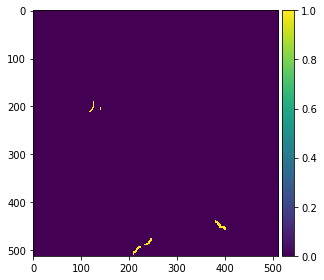

525


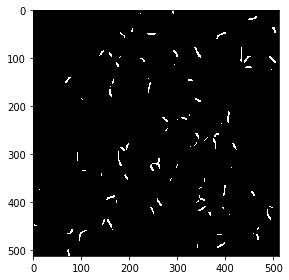

526


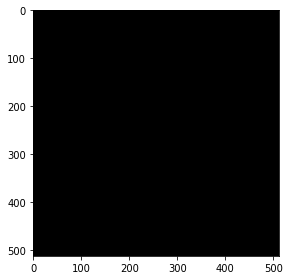

527


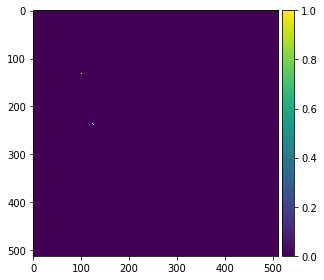

528


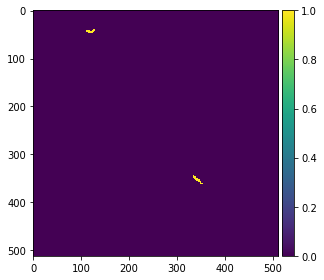

529


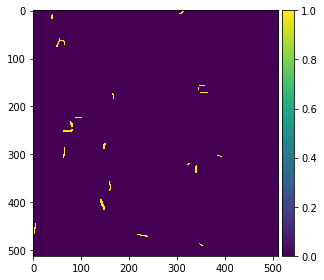

530


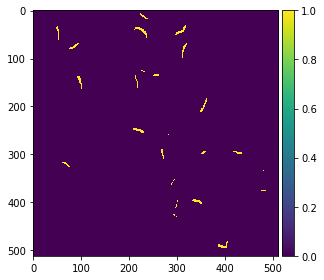

531


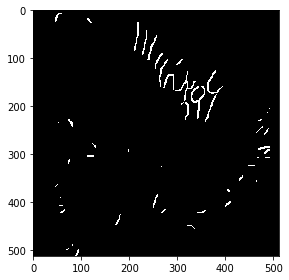

532


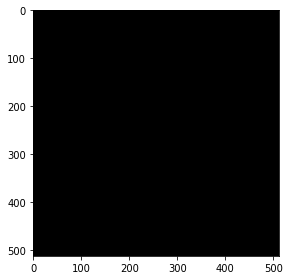

533


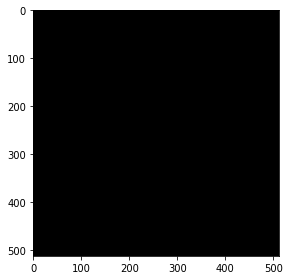

534


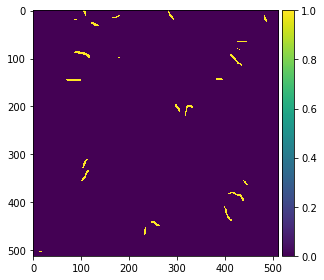

535


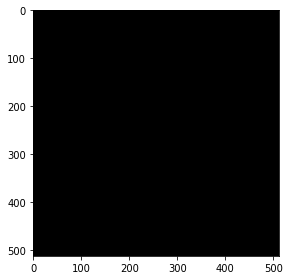

536


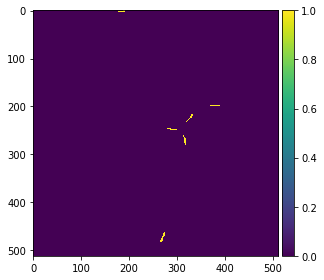

537


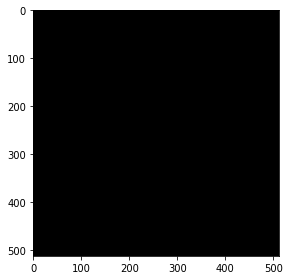

538


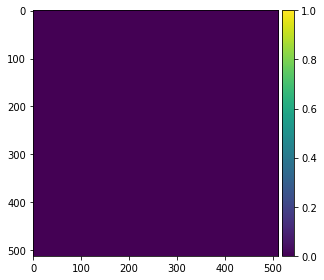

539


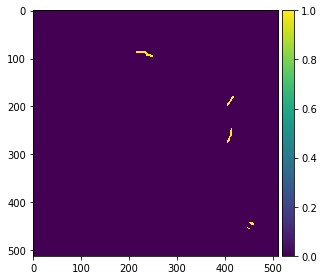

540


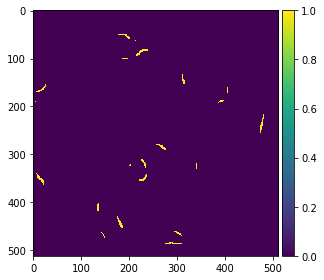

541


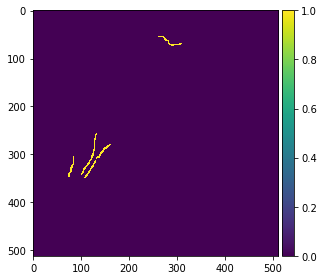

542


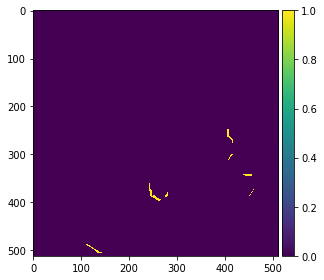

543


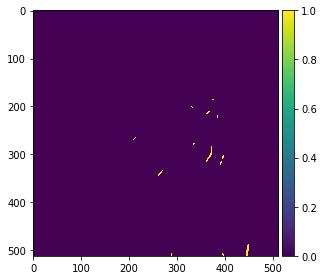

544


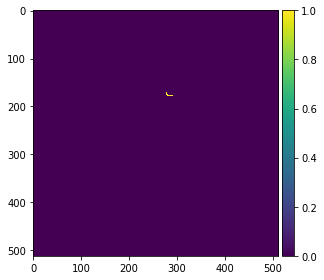

545


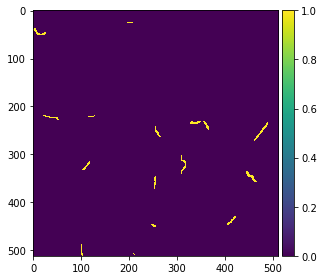

546


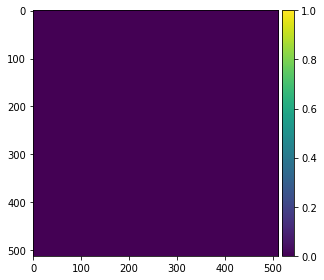

547


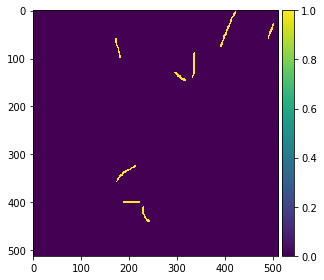

548


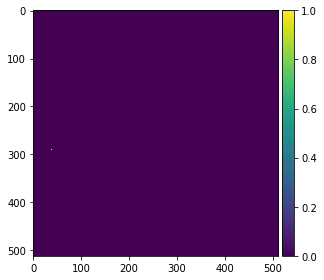

549


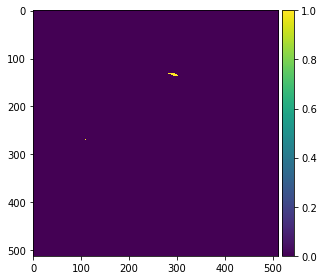

550


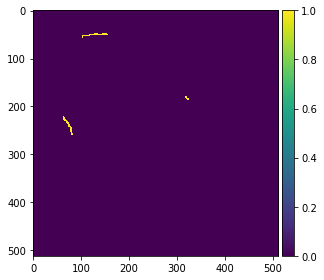

551


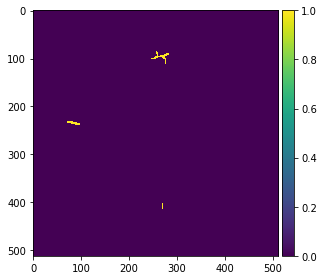

552


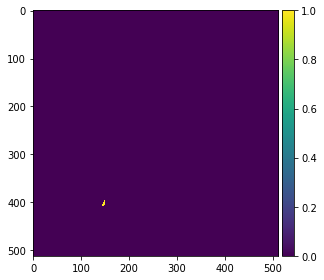

553


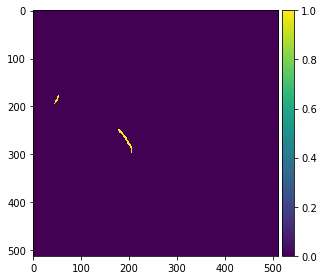

554


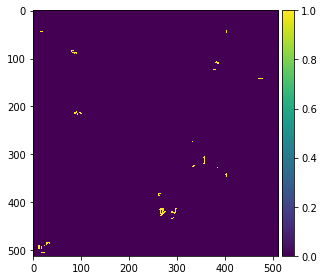

555


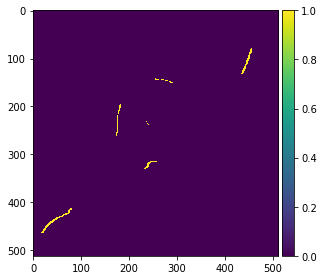

556


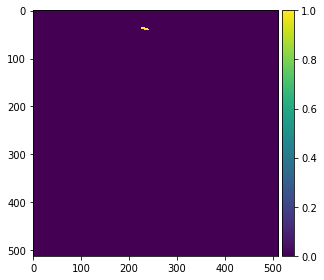

557


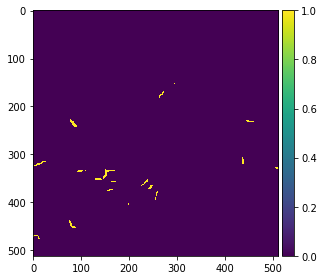

558


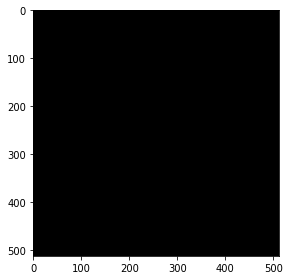

559


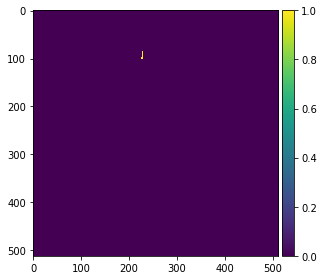

560


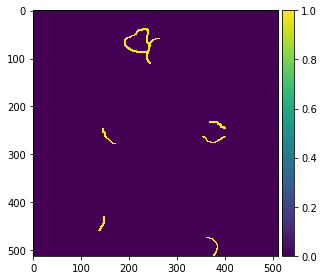

561


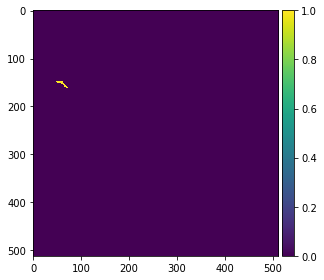

562


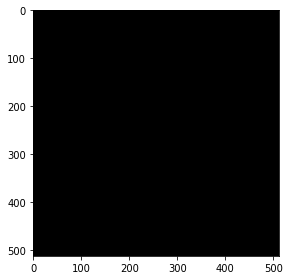

563


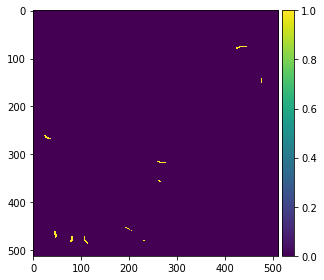

564


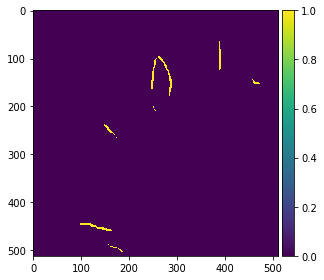

565


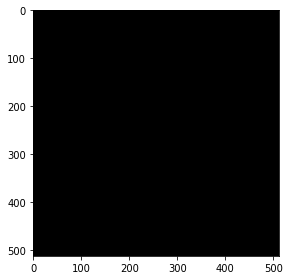

566


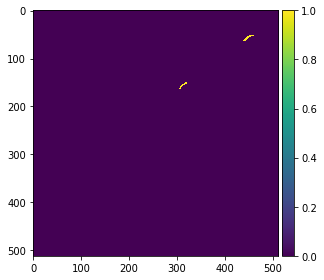

567


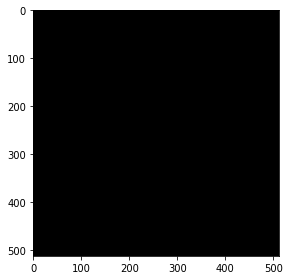

568


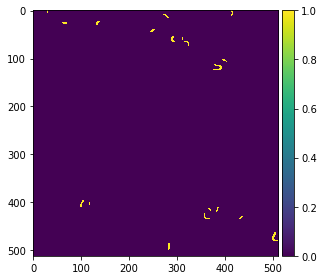

569


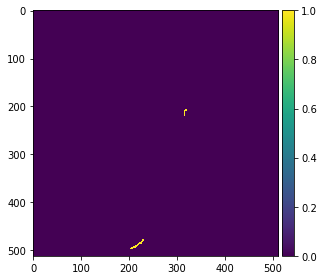

570


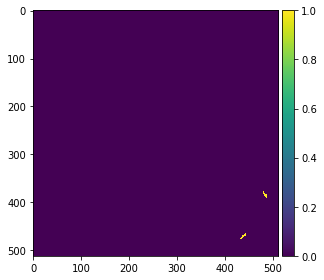

571


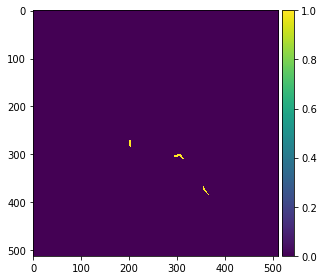

572


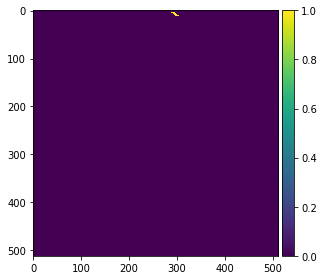

573


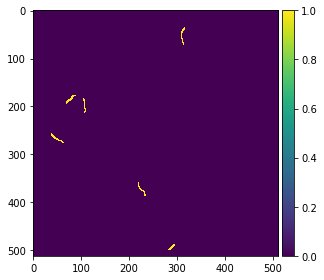

574


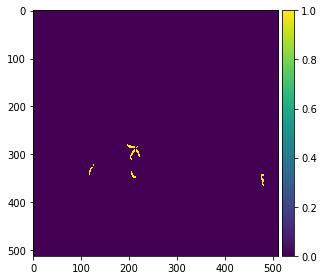

575


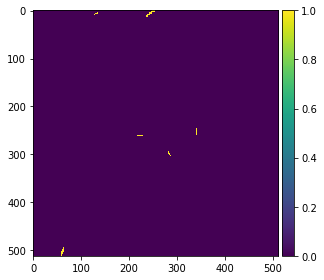

576


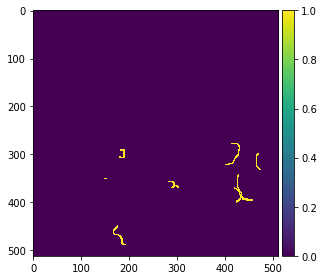

577


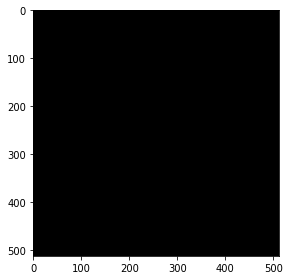

578


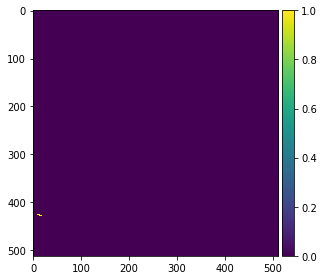

579


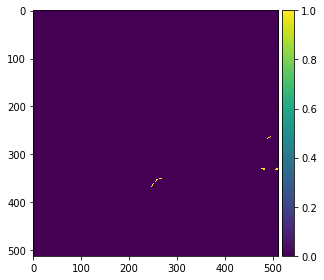

580


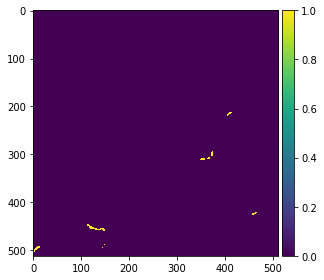

581


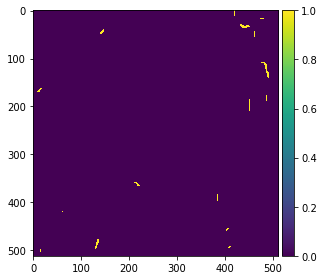

582


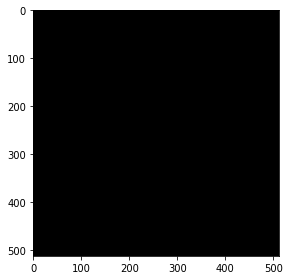

583


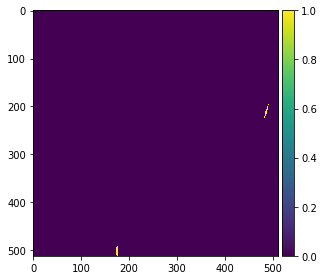

584


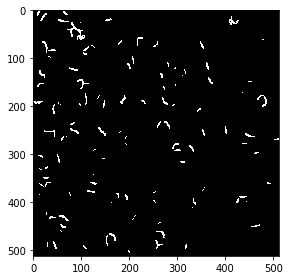

585


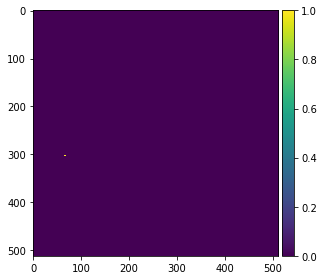

586


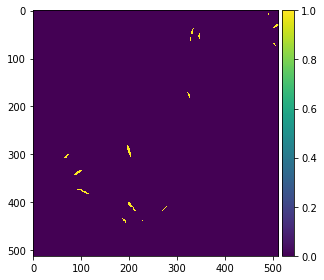

587


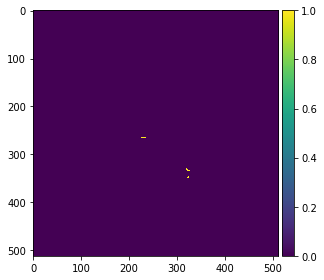

588


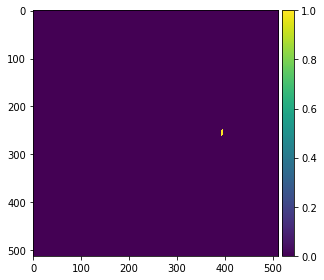

589


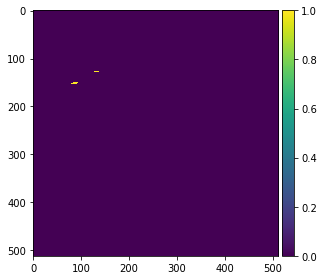

590


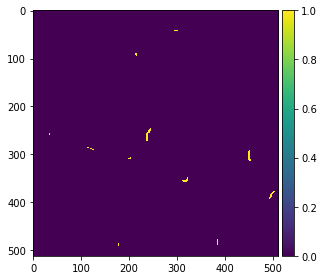

591


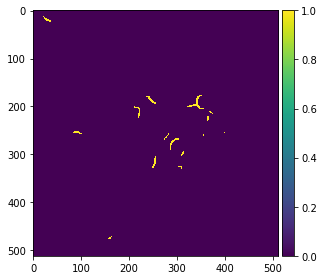

592


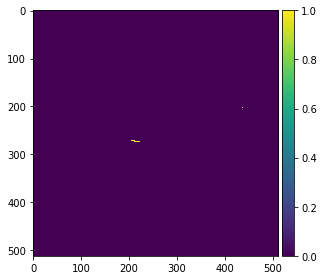

593


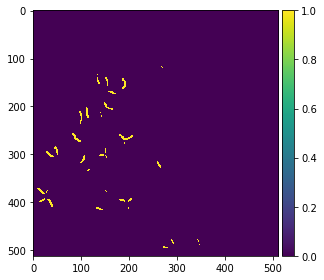

594


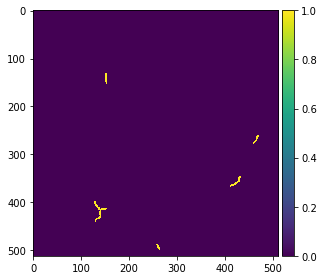

595


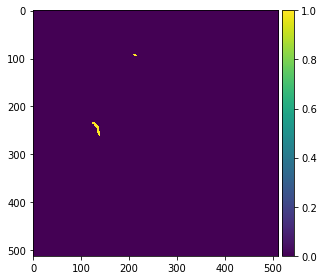

596


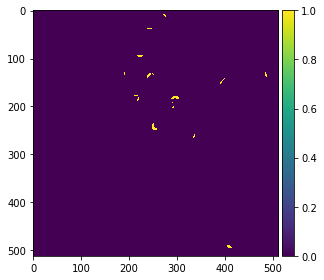

597


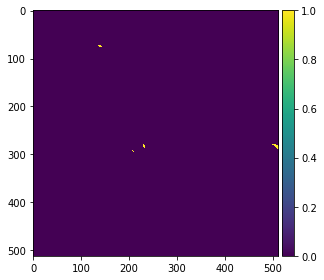

598


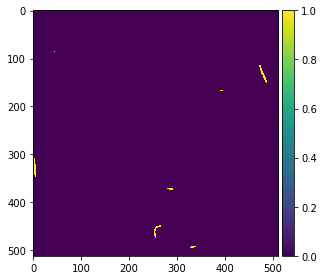

599


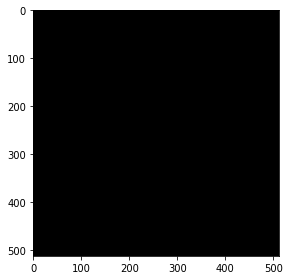

600


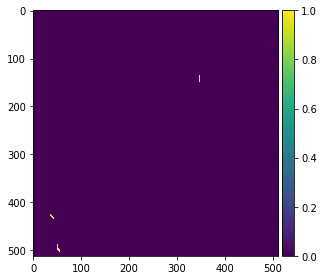

601


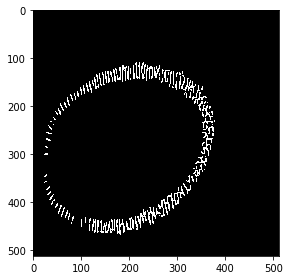

602


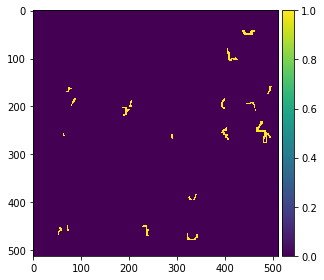

603


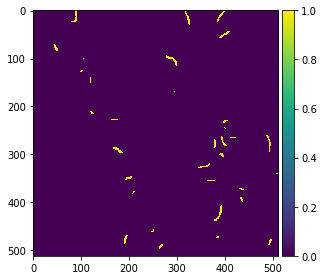

604


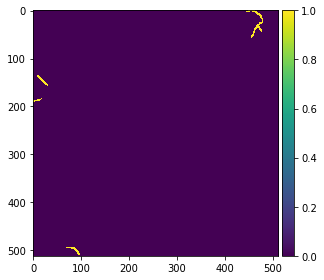

605


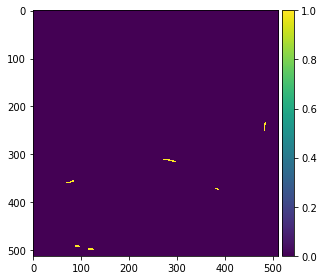

606


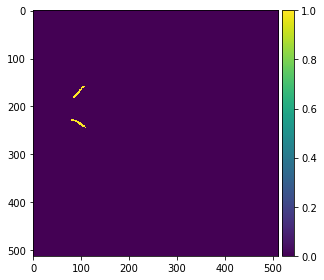

607


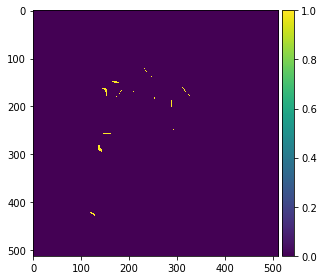

608


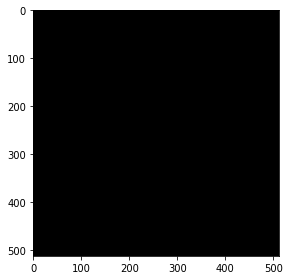

609


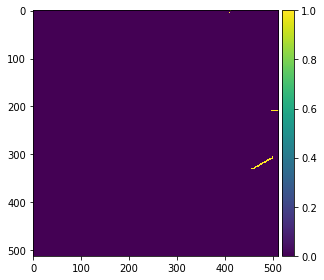

610


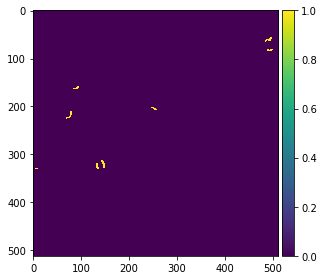

611


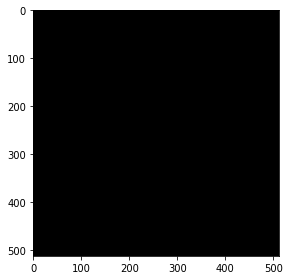

612


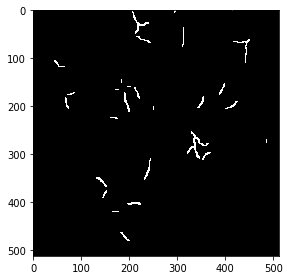

613


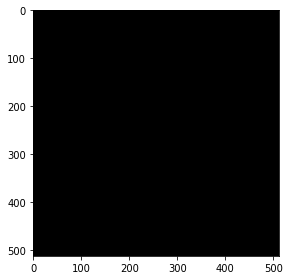

614


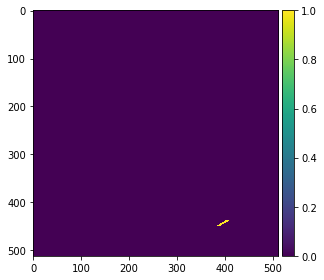

615


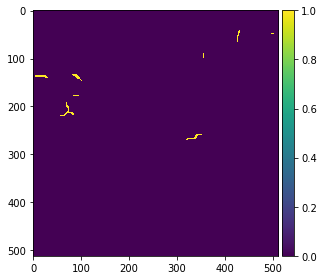

616


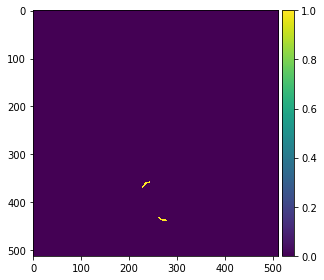

617


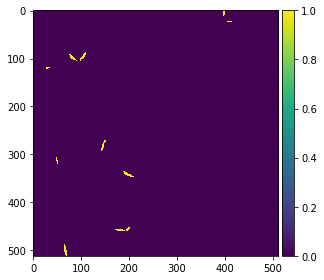

618


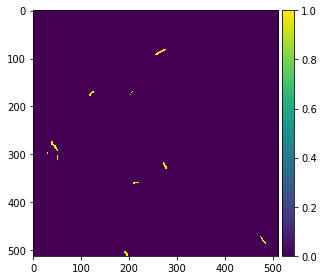

619


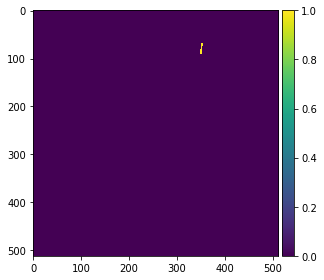

620


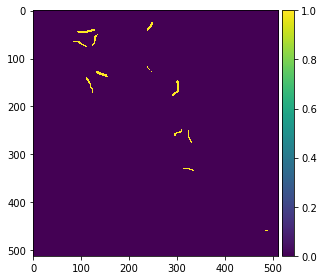

621


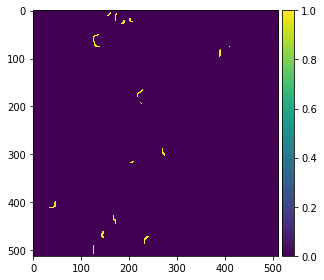

622


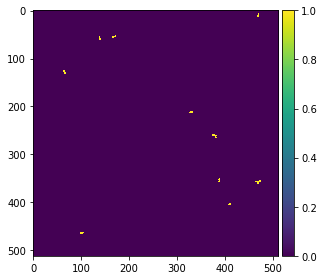

623


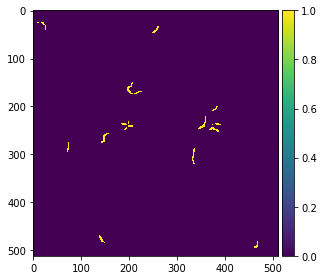

624


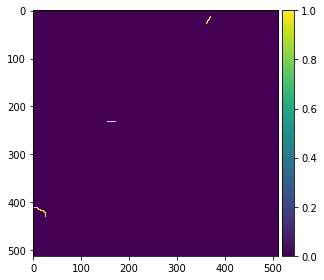

625


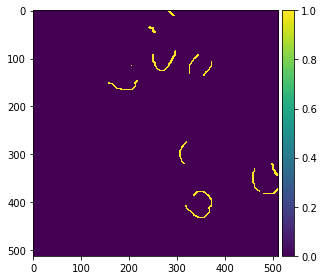

626


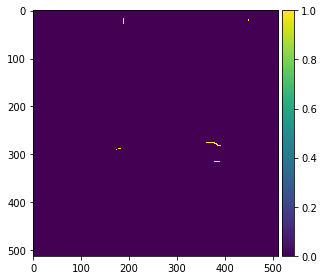

627


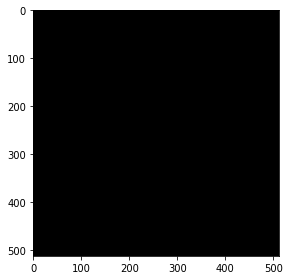

628


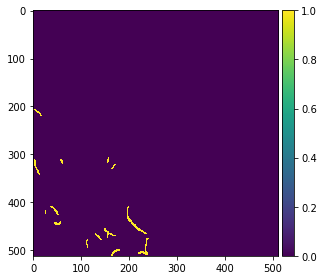

629


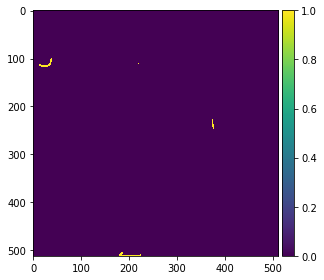

630


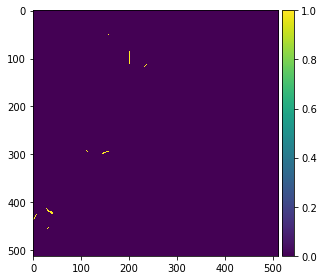

631


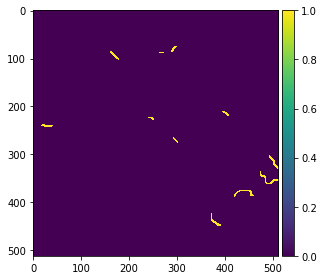

632


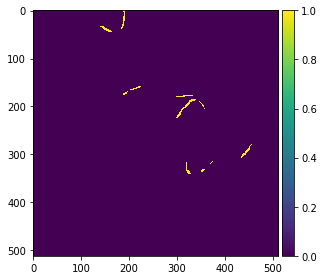

633


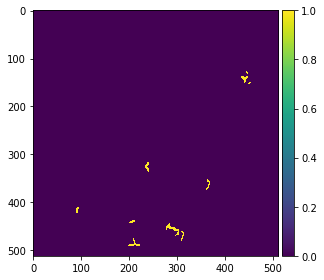

634


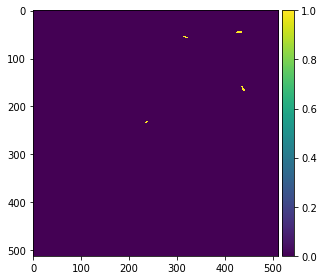

635


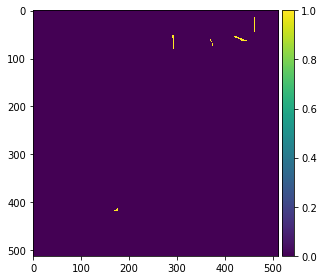

636


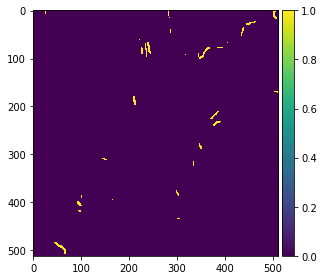

637


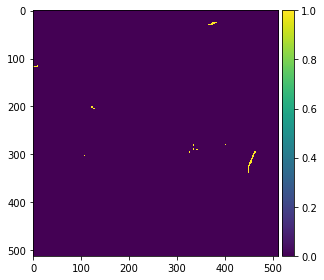

638


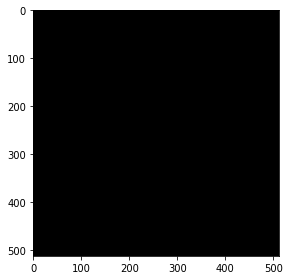

639


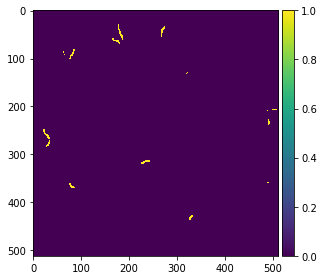

640


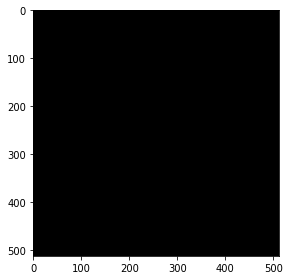

641


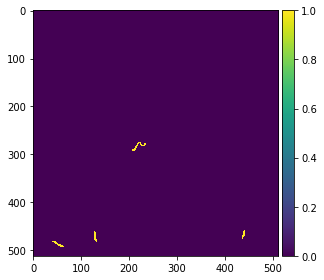

642


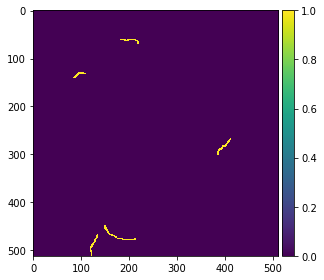

643


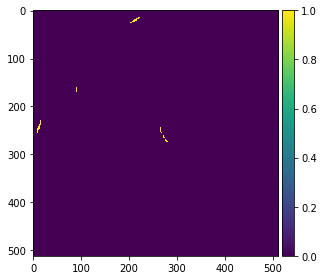

644


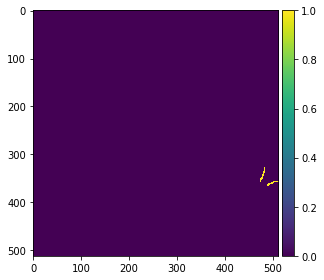

645


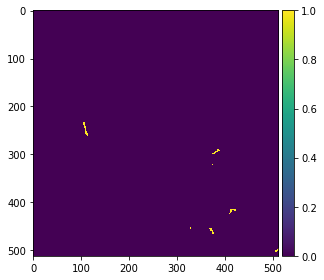

646


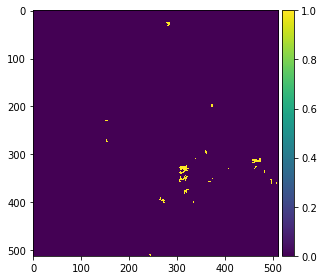

647


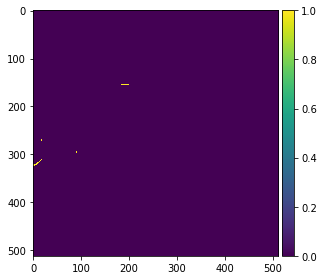

648


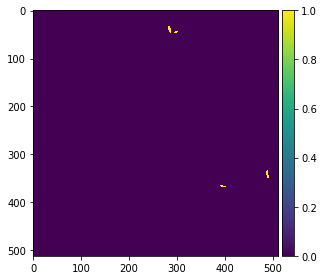

649


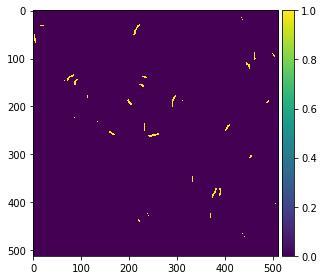

650


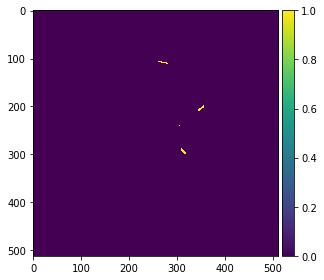

651


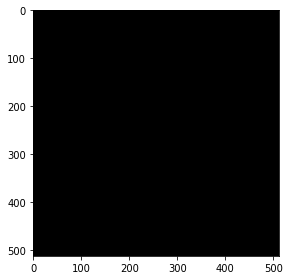

652


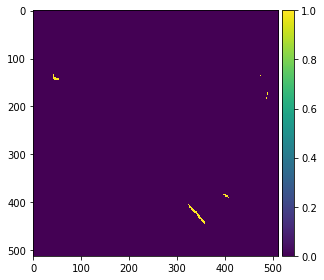

653


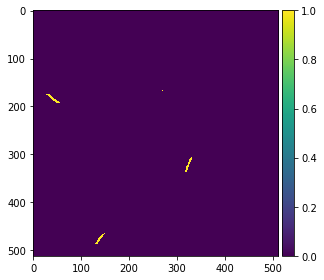

654


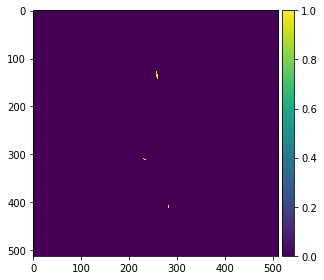

655


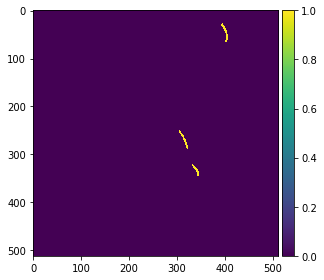

656


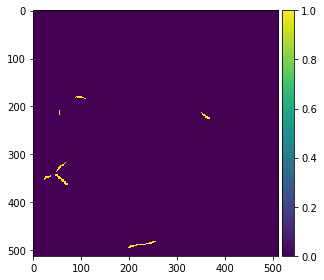

657


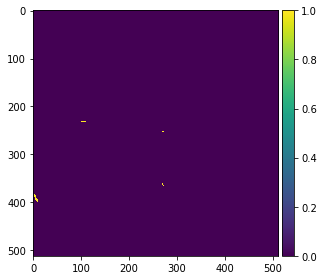

658


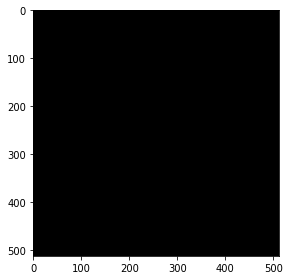

659


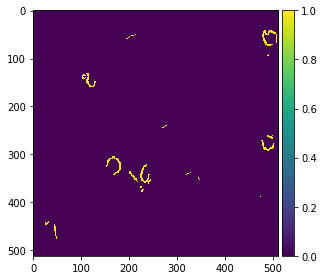

660


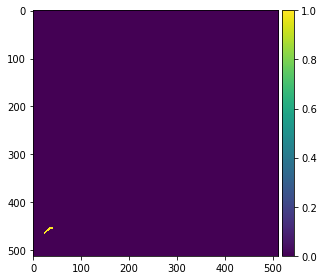

661


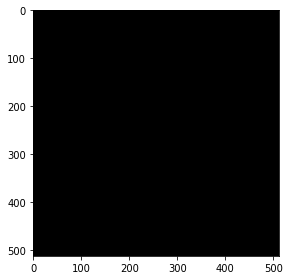

662


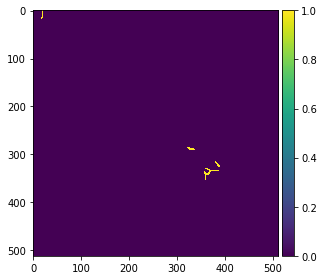

663


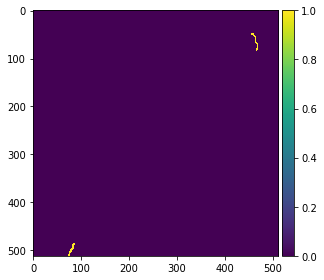

In [9]:
for i in range(0,len(spaceBetweenTrain)):
    print(i)
    imshow(np.squeeze(spaceBetweenTrain[i]))
    plt.show()


Let's see if things look all right by drawing some random images and their associated masks.


(512, 512, 3)
uint8


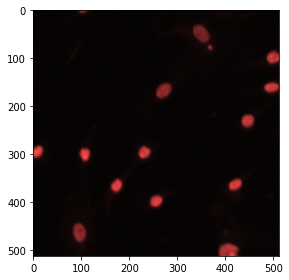

(512, 512, 1)
bool


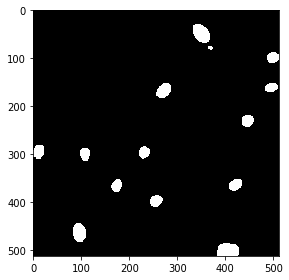

(512, 512, 1)
bool


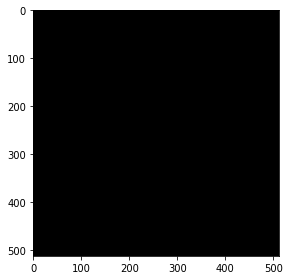

(512, 512, 2)
bool
bool


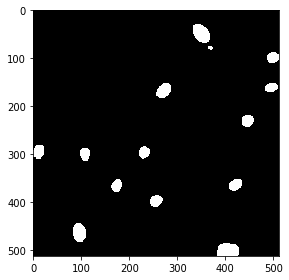

bool


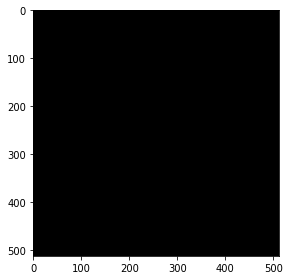

(512, 512, 3)


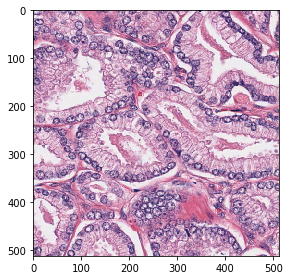

(512, 512, 1)


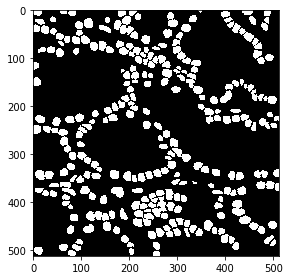

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
print(X_train[ix].shape)
print(X_train[ix].dtype)
#print(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
print(Y_train[ix].shape)
print(Y_train[ix].dtype)
plt.show()
imshow(np.squeeze(spaceBetweenTrain[ix]))
print(spaceBetweenTrain[ix].shape)
print(spaceBetweenTrain[ix].dtype)
plt.show()


print(concatenatedMasksTrain[ix].shape)
print(concatenatedMasksTrain[ix].dtype)
ma, sb = np.split(concatenatedMasksTrain, indices_or_sections = 2, axis=-1)
print(ma[ix].dtype)
imshow(np.squeeze(ma[ix]))
plt.show()
print(sb[ix].dtype)
#print(sb[ix])
imshow(np.squeeze(sb[ix]))
plt.show()


# Check if validation data looks all right
ix = random.randint(0, len(val_ids))
imshow(X_val[ix])
print(X_val[ix].shape)
plt.show()
imshow(np.squeeze(Y_val[ix]))
print(Y_val[ix].shape)
plt.show()

# Augmentation

In [20]:
augmentedImages, augmentedMasks, augmentedSpaceBetweenMasks = utils.augment(X_train, Y_train, spaceBetweenTrain, _numberOfAugmentedImages, _imgHeight, _imgWidth, _imgChannels)
augmentedConcatenatedMasks = np.concatenate([augmentedMasks, augmentedSpaceBetweenMasks], axis=-1)

20
20
20
(20, 512, 512, 2)
(512, 512, 3)


/tmp/scikit-image/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from uint64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


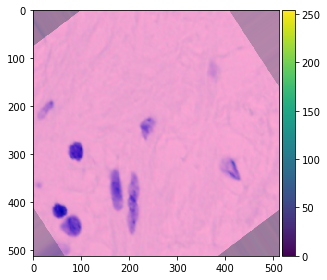

(512, 512, 1)
bool


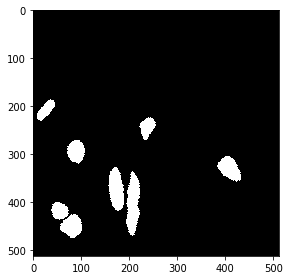

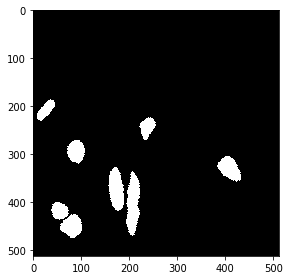

(512, 512, 1)
bool


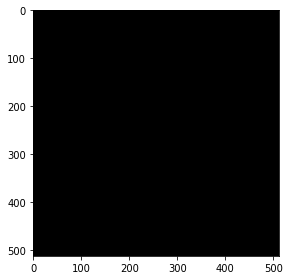

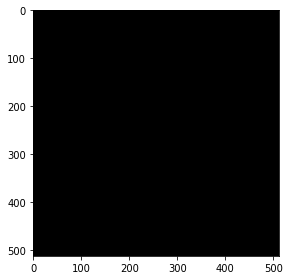

(512, 512, 3)


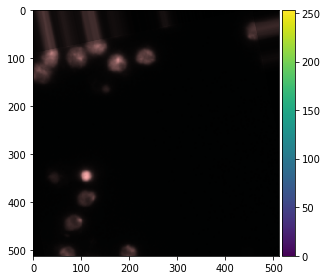

(512, 512, 1)
bool


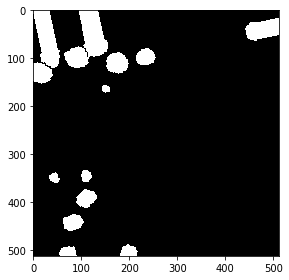

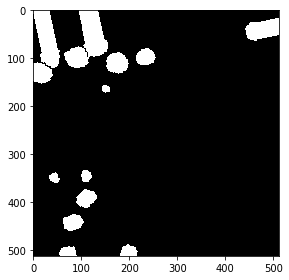

(512, 512, 1)
bool


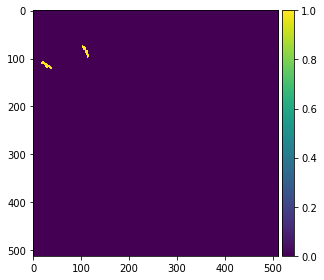

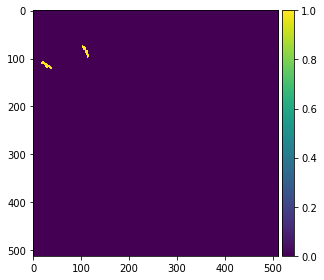

(512, 512, 3)


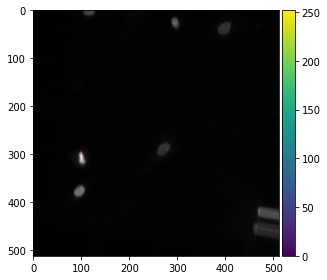

(512, 512, 1)
bool


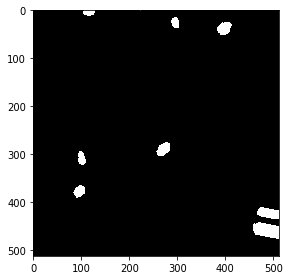

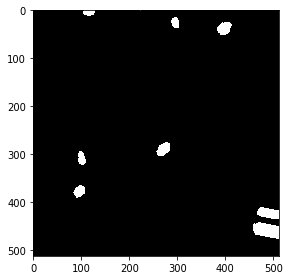

(512, 512, 1)
bool


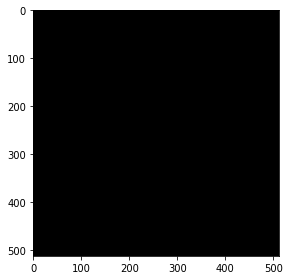

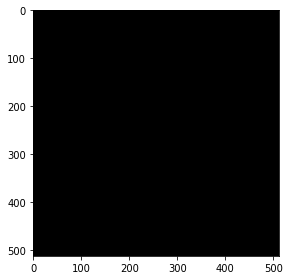

(512, 512, 3)


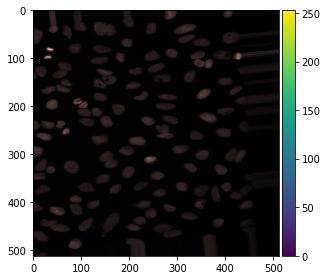

(512, 512, 1)
bool


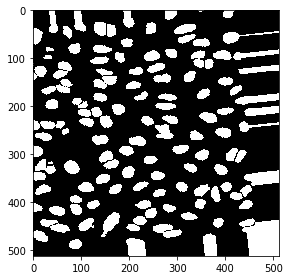

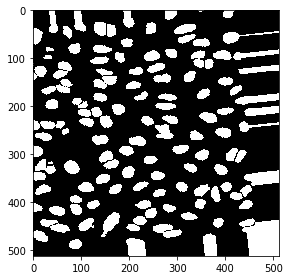

(512, 512, 1)
bool


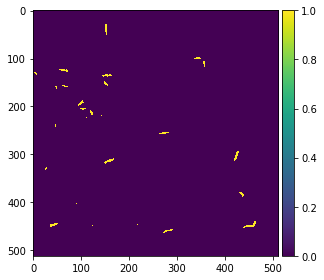

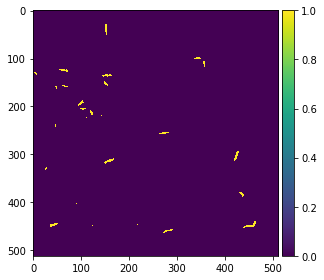

(512, 512, 3)


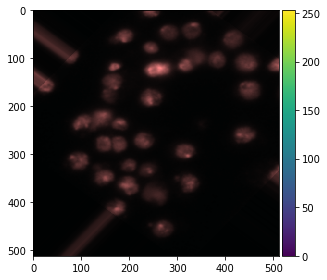

(512, 512, 1)
bool


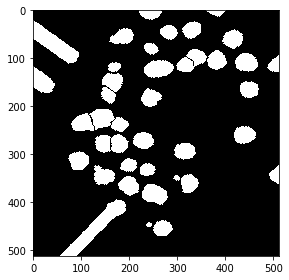

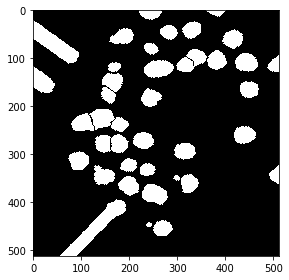

(512, 512, 1)
bool


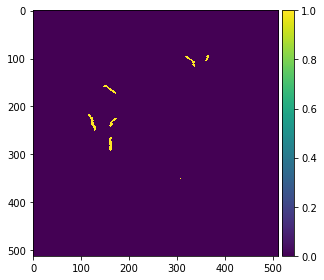

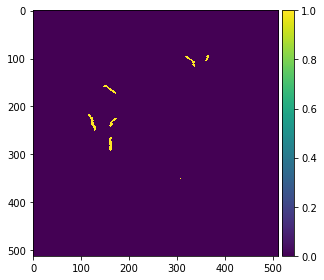

(512, 512, 3)


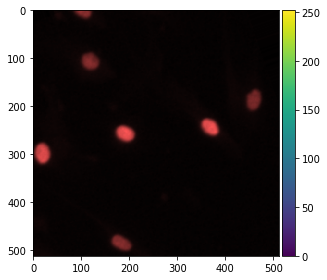

(512, 512, 1)
bool


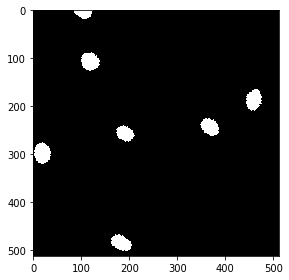

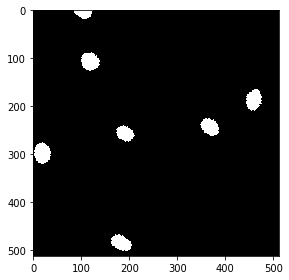

(512, 512, 1)
bool


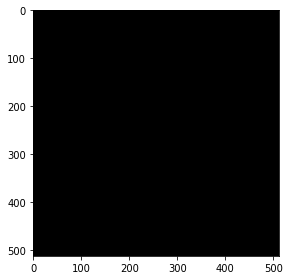

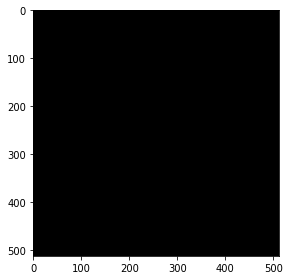

(512, 512, 3)


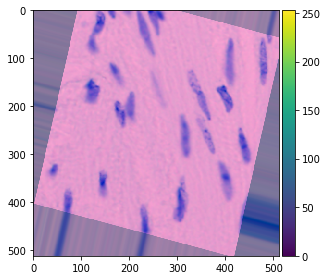

(512, 512, 1)
bool


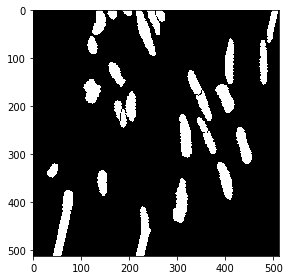

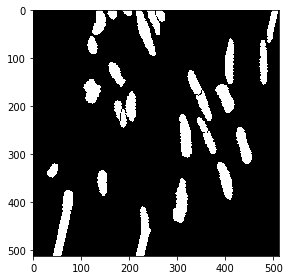

(512, 512, 1)
bool


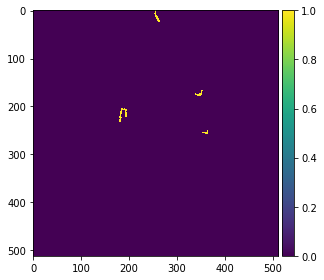

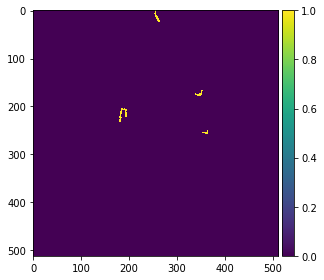

(512, 512, 3)


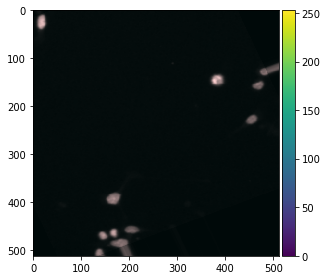

(512, 512, 1)
bool


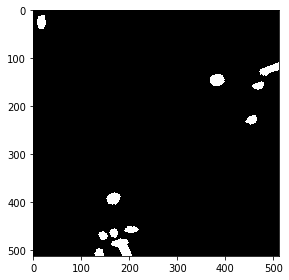

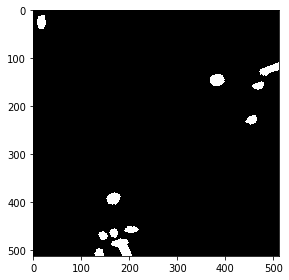

(512, 512, 1)
bool


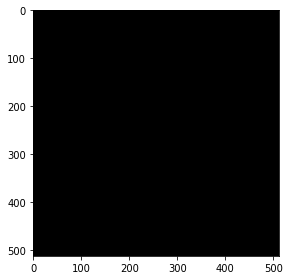

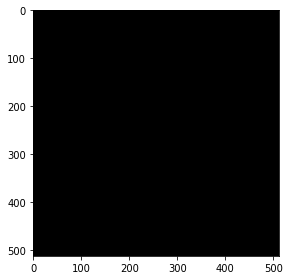

(512, 512, 3)


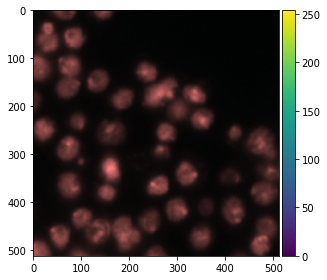

(512, 512, 1)
bool


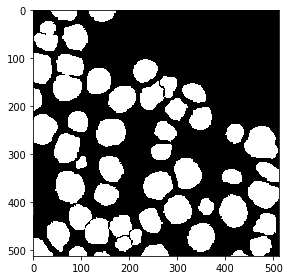

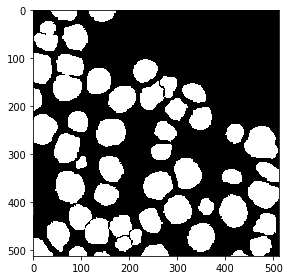

(512, 512, 1)
bool


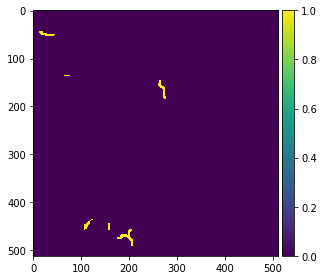

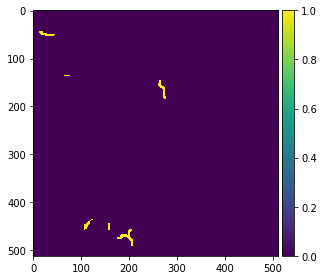

(512, 512, 3)


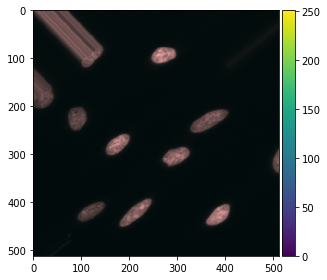

(512, 512, 1)
bool


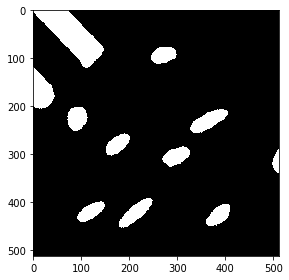

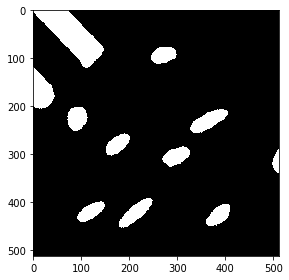

(512, 512, 1)
bool


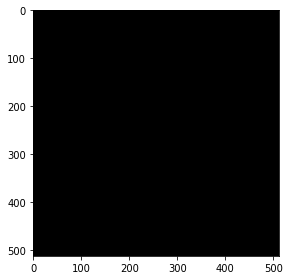

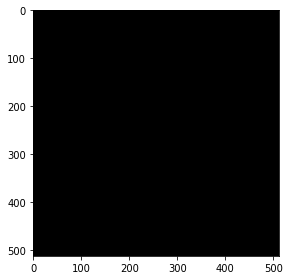

(512, 512, 3)


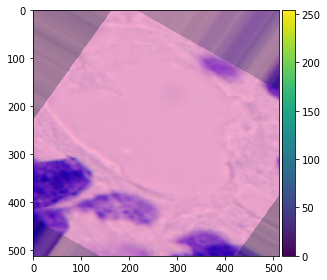

(512, 512, 1)
bool


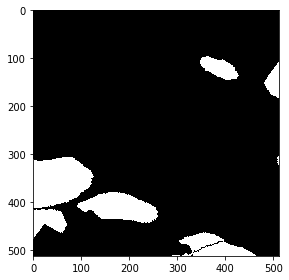

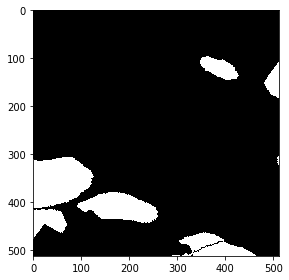

(512, 512, 1)
bool


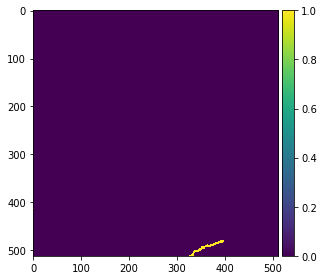

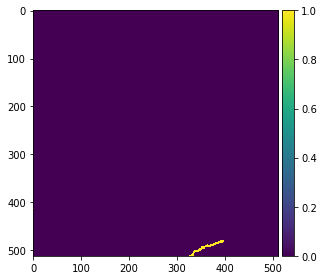

(512, 512, 3)


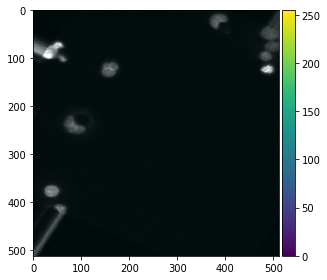

(512, 512, 1)
bool


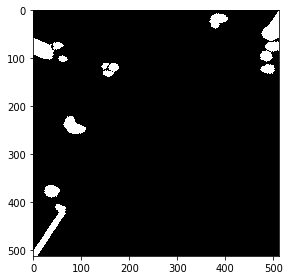

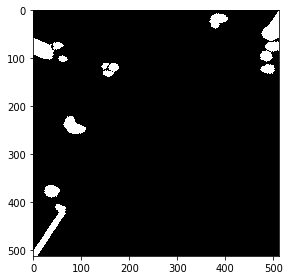

(512, 512, 1)
bool


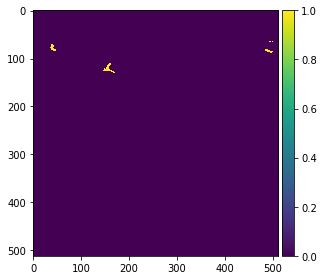

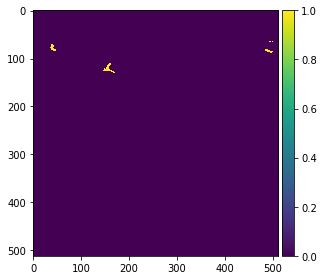

(512, 512, 3)


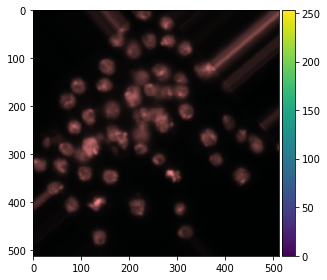

(512, 512, 1)
bool


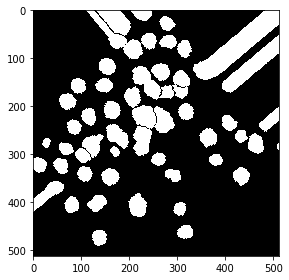

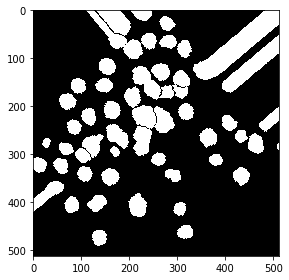

(512, 512, 1)
bool


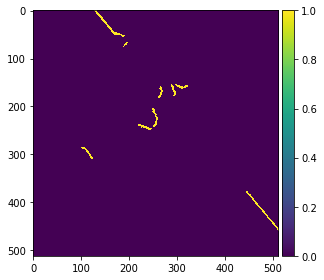

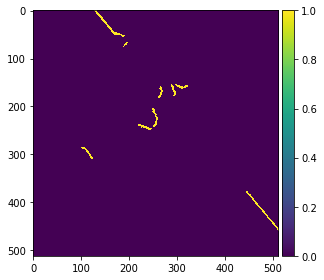

(512, 512, 3)


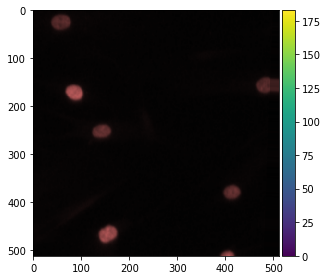

(512, 512, 1)
bool


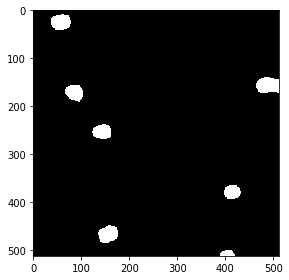

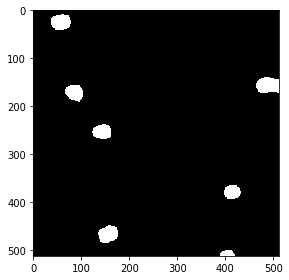

(512, 512, 1)
bool


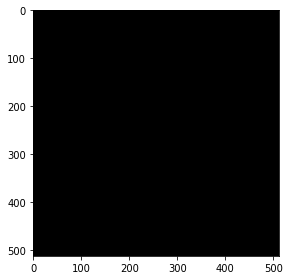

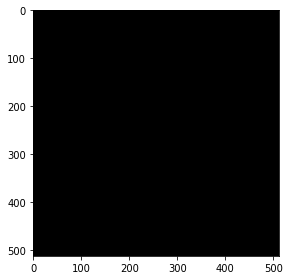

(512, 512, 3)


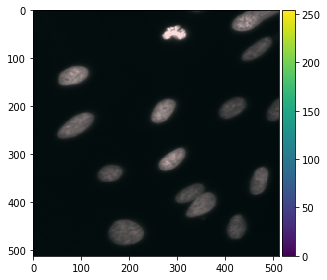

(512, 512, 1)
bool


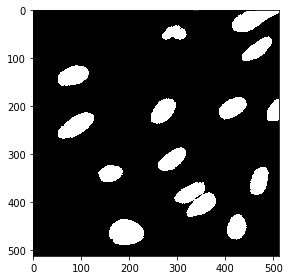

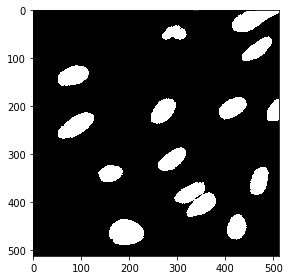

(512, 512, 1)
bool


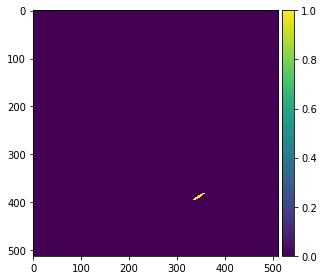

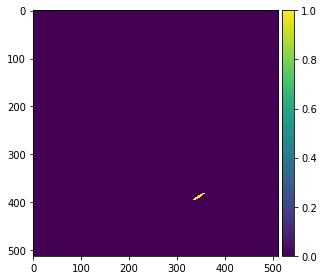

(512, 512, 3)


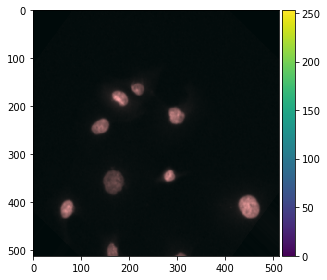

(512, 512, 1)
bool


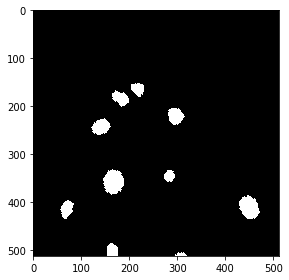

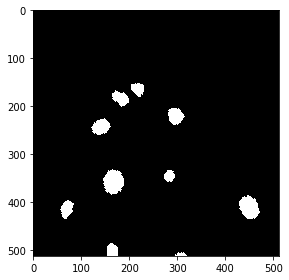

(512, 512, 1)
bool


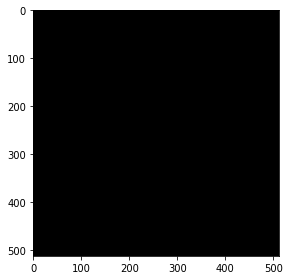

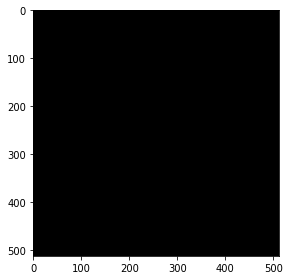

(512, 512, 3)


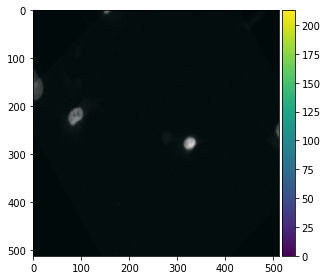

(512, 512, 1)
bool


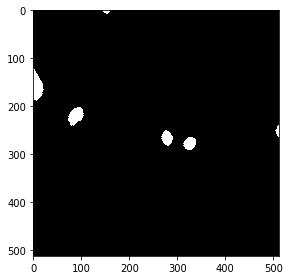

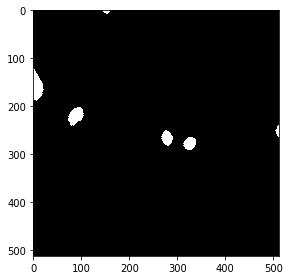

(512, 512, 1)
bool


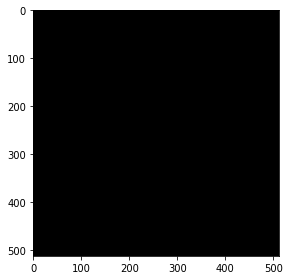

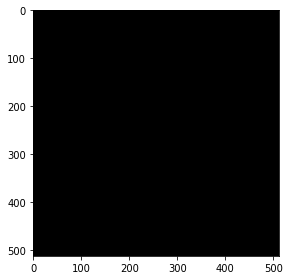

(512, 512, 3)


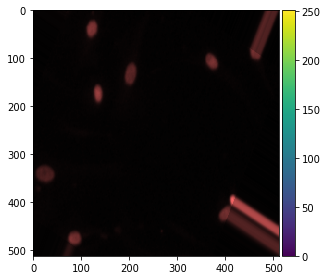

(512, 512, 1)
bool


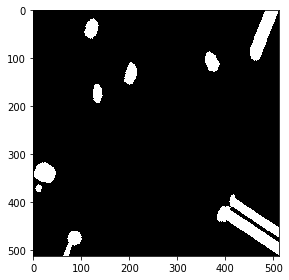

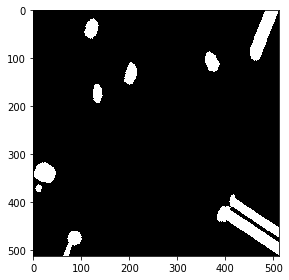

(512, 512, 1)
bool


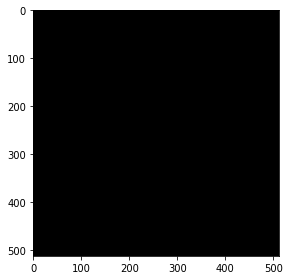

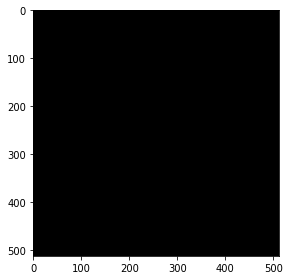

(512, 512, 3)


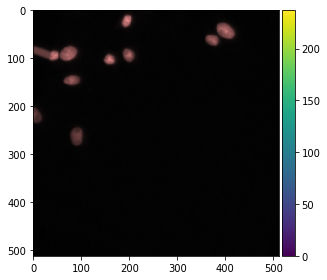

(512, 512, 1)
bool


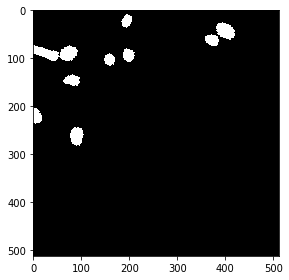

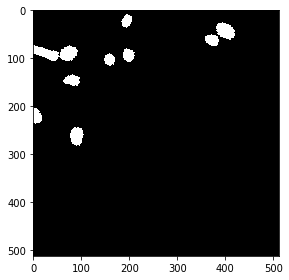

(512, 512, 1)
bool


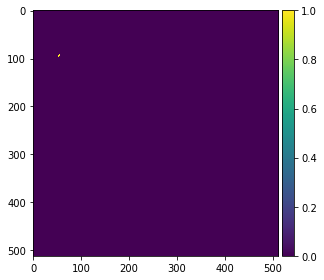

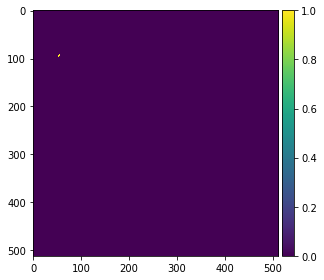

(512, 512, 3)


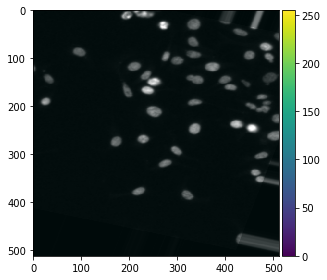

(512, 512, 1)
bool


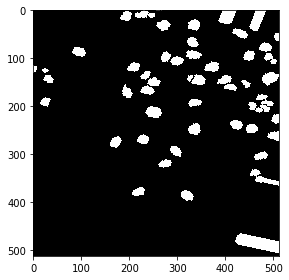

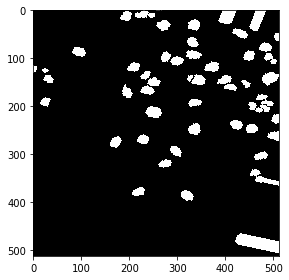

(512, 512, 1)
bool


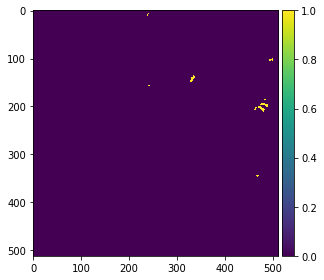

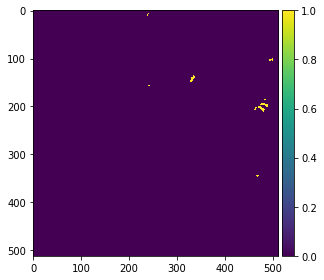

In [25]:
print(len(augmentedImages))
print(len(augmentedMasks))
print(len(augmentedSpaceBetweenMasks))
print(augmentedConcatenatedMasks.shape)
ma2, sb2 = np.split(augmentedConcatenatedMasks, 2, -1)
for i in range(0, len(augmentedImages)):
#for i in range(0, 50):
    im = augmentedImages[i]    
    print(im.shape)
    imshow(im)
    plt.show()
    
    ma = augmentedMasks[i]
    print(ma.shape)
    print(ma.dtype)
    imshow(np.squeeze(ma))
    plt.show()
    
    imshow(np.squeeze(ma2[i]))
    plt.show()
    
    sb = augmentedSpaceBetweenMasks[i]
    print(sb.shape)
    print(sb.dtype)
    imshow(np.squeeze(sb))
    plt.show()

    imshow(np.squeeze(sb2[i]))
    plt.show()

# Build and train neural network

In [4]:
u_net = model.build_unet_inception_resnet_v2((_imgWidth, _imgHeight, _imgChannels), numberOfMaskChannels = 2)

/opt/conda/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

conv2d_182 (Conv2D)             (None, 16, 16, 224)  129024      activation_181[0][0]             
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 16, 16, 224)  672         conv2d_182[0][0]                 
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 16, 16, 224)  0           batch_normalization_182[0][0]    
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 16, 16, 192)  399360      block8_4_ac[0][0]                
__________________________________________________________________________________________________
conv2d_183 (Conv2D)             (None, 16, 16, 256)  172032      activation_182[0][0]             
__________________________________________________________________________________________________
batch_norm

In [5]:
model.fit_model(u_net, _modelDir, X_train, spaceBetweenTrain, _validationSplit, _epochs, _batchSize)

Train on 597 samples, validate on 67 samples
Epoch 1/50
597/597 [==============================] - 153s 257ms/step - loss: 1.1424 - dice_coef: 0.2926 - dice_coef_loss: 0.7074 - binary_crossentropy: 0.4350 - binary_crossentropy_with_dice_coef_loss: 1.1424 - val_loss: 1.5837 - val_dice_coef: 0.3928 - val_dice_coef_loss: 0.6072 - val_binary_crossentropy: 0.9765 - val_binary_crossentropy_with_dice_coef_loss: 1.5837

Epoch 00001: val_loss improved from inf to 1.58375, saving model to /home/Deep_Learner/work/2018_dsb_u_net/logs/2018-06-17 11:16:22/epoch0001-val_loss1.58.h5
Epoch 2/50
597/597 [==============================] - 91s 152ms/step - loss: 0.6544 - dice_coef: 0.5067 - dice_coef_loss: 0.4933 - binary_crossentropy: 0.1611 - binary_crossentropy_with_dice_coef_loss: 0.6544 - val_loss: 0.5547 - val_dice_coef: 0.6170 - val_dice_coef_loss: 0.3830 - val_binary_crossentropy: 0.1717 - val_binary_crossentropy_with_dice_coef_loss: 0.5547

Epoch 00002: val_loss improved from 1.58375 to 0.55467, 


Epoch 00034: val_loss did not improve
Epoch 35/50
597/597 [==============================] - 93s 155ms/step - loss: 0.1331 - dice_coef: 0.9055 - dice_coef_loss: 0.0945 - binary_crossentropy: 0.0386 - binary_crossentropy_with_dice_coef_loss: 0.1331 - val_loss: 0.1491 - val_dice_coef: 0.8985 - val_dice_coef_loss: 0.1015 - val_binary_crossentropy: 0.0476 - val_binary_crossentropy_with_dice_coef_loss: 0.1491

Epoch 00035: val_loss did not improve

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 36/50
597/597 [==============================] - 93s 156ms/step - loss: 0.1358 - dice_coef: 0.9033 - dice_coef_loss: 0.0967 - binary_crossentropy: 0.0391 - binary_crossentropy_with_dice_coef_loss: 0.1358 - val_loss: 0.1487 - val_dice_coef: 0.8988 - val_dice_coef_loss: 0.1012 - val_binary_crossentropy: 0.0474 - val_binary_crossentropy_with_dice_coef_loss: 0.1487

Epoch 00036: val_loss did not improve
Epoch 37/50
597/597 [==============================] - 93s 15

In [16]:
u_net_spaceBetween = model.build_unet_inception_resnet_v2((_imgWidth, _imgHeight, _imgChannels), numberOfMaskChannels = 1)

/opt/conda/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

batch_normalization_179 (BatchN (None, 16, 16, 256)  768         conv2d_179[0][0]                 
__________________________________________________________________________________________________
activation_176 (Activation)     (None, 16, 16, 192)  0           batch_normalization_176[0][0]    
__________________________________________________________________________________________________
activation_179 (Activation)     (None, 16, 16, 256)  0           batch_normalization_179[0][0]    
__________________________________________________________________________________________________
block8_4_mixed (Concatenate)    (None, 16, 16, 448)  0           activation_176[0][0]             
                                                                 activation_179[0][0]             
__________________________________________________________________________________________________
block8_4_conv (Conv2D)          (None, 16, 16, 2080) 933920      block8_4_mixed[0][0]             
__________

In [17]:
model.fit_model(u_net_spaceBetween, _modelDir, X_train, spaceBetweenTrain, _validationSplit, _epochs, _batchSize)

Train on 597 samples, validate on 67 samples
Epoch 1/100
597/597 [==============================] - 153s 256ms/step - loss: 1.2738 - dice_coef: 0.0054 - dice_coef_loss: 0.9946 - binary_crossentropy: 0.2791 - binary_crossentropy_with_dice_coef_loss: 1.2738 - val_loss: 1.1175 - val_dice_coef: 0.0053 - val_dice_coef_loss: 0.9947 - val_binary_crossentropy: 0.1228 - val_binary_crossentropy_with_dice_coef_loss: 1.1175

Epoch 00001: val_loss improved from inf to 1.11755, saving model to /home/Deep_Learner/work/2018_dsb_u_net/logs/2018-06-19 07:51:15/epoch0001-val_loss1.12.h5
Epoch 2/100
597/597 [==============================] - 88s 147ms/step - loss: 1.0666 - dice_coef: 0.0069 - dice_coef_loss: 0.9931 - binary_crossentropy: 0.0735 - binary_crossentropy_with_dice_coef_loss: 1.0666 - val_loss: 1.0330 - val_dice_coef: 0.0071 - val_dice_coef_loss: 0.9929 - val_binary_crossentropy: 0.0401 - val_binary_crossentropy_with_dice_coef_loss: 1.0330

Epoch 00002: val_loss improved from 1.11755 to 1.03298

597/597 [==============================] - 91s 152ms/step - loss: 0.6140 - dice_coef: 0.4053 - dice_coef_loss: 0.5947 - binary_crossentropy: 0.0193 - binary_crossentropy_with_dice_coef_loss: 0.6140 - val_loss: 0.6659 - val_dice_coef: 0.3559 - val_dice_coef_loss: 0.6441 - val_binary_crossentropy: 0.0218 - val_binary_crossentropy_with_dice_coef_loss: 0.6659

Epoch 00034: val_loss improved from 0.66602 to 0.66594, saving model to /home/Deep_Learner/work/2018_dsb_u_net/logs/2018-06-19 07:51:15/epoch0034-val_loss0.67.h5
Epoch 35/100
597/597 [==============================] - 91s 152ms/step - loss: 0.6203 - dice_coef: 0.3990 - dice_coef_loss: 0.6010 - binary_crossentropy: 0.0193 - binary_crossentropy_with_dice_coef_loss: 0.6203 - val_loss: 0.6671 - val_dice_coef: 0.3542 - val_dice_coef_loss: 0.6458 - val_binary_crossentropy: 0.0213 - val_binary_crossentropy_with_dice_coef_loss: 0.6671

Epoch 00035: val_loss did not improve

Epoch 00035: ReduceLROnPlateau reducing learning rate to 3.125000148


Epoch 00051: val_loss did not improve
Epoch 52/100
597/597 [==============================] - 91s 152ms/step - loss: 0.6125 - dice_coef: 0.4065 - dice_coef_loss: 0.5935 - binary_crossentropy: 0.0191 - binary_crossentropy_with_dice_coef_loss: 0.6125 - val_loss: 0.6663 - val_dice_coef: 0.3556 - val_dice_coef_loss: 0.6444 - val_binary_crossentropy: 0.0219 - val_binary_crossentropy_with_dice_coef_loss: 0.6663

Epoch 00052: val_loss did not improve

Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 53/100
597/597 [==============================] - 91s 152ms/step - loss: 0.6122 - dice_coef: 0.4071 - dice_coef_loss: 0.5929 - binary_crossentropy: 0.0193 - binary_crossentropy_with_dice_coef_loss: 0.6122 - val_loss: 0.6658 - val_dice_coef: 0.3561 - val_dice_coef_loss: 0.6439 - val_binary_crossentropy: 0.0218 - val_binary_crossentropy_with_dice_coef_loss: 0.6658

Epoch 00053: val_loss did not improve
Epoch 54/100
597/597 [==============================] - 91s

# Make predictions

In [7]:
preds_train, preds_val, preds_test, preds_train_t, preds_val_t, preds_test_t = model.make_predictions('./logs/2018-06-15 09:47:45/epoch0026-val_loss0.16.h5', X_train, X_val, X_test, MaskType.nucleusMask)

3018/3018 [==============================] - 120s 40ms/step


In [8]:
preds_train_spaceBetween, preds_val_spaceBetween, preds_test_spaceBetween, preds_train_t_spaceBetween, preds_val_t_spaceBetween, preds_test_t_spaceBetween = model.make_predictions('./logs/2018-06-19 07:51:15 spaceBetween/epoch0038-val_loss0.66.h5', X_train, X_val, X_test, MaskType.spaceBetweenMask)

3018/3018 [==============================] - 116s 38ms/step


In [ ]:
### subtract predicted space between touching masks from the predicted test set masks
preds_test_t_subtracted = copy.deepcopy(preds_test_t)

for predictedMask, predictedSpaceBetween in tqdm(zip(preds_test_t_subtracted, preds_test_t_spaceBetween), total=len(preds_test_t_subtracted)):
    for i in range(0, predictedSpaceBetween.shape[0]):
            for j in range(0, predictedSpaceBetween.shape[1]):
                if predictedSpaceBetween[i][j] > 0:
                    predictedMask[i][j] = 0

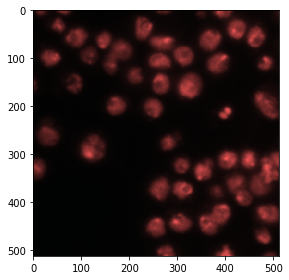

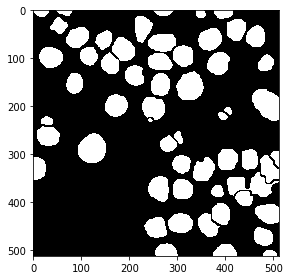

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


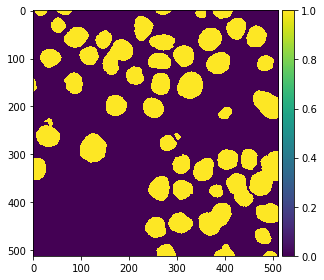

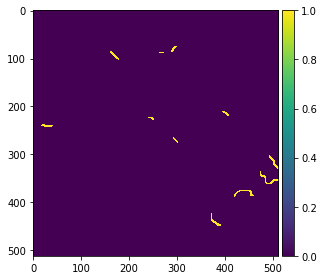

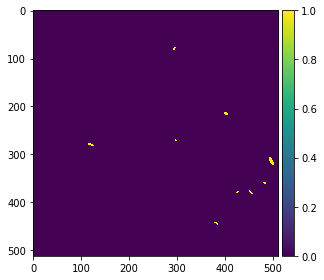

In [39]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()
imshow(np.squeeze(spaceBetweenTrain[ix]))
plt.show()
imshow(np.squeeze(preds_train_t_spaceBetween[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

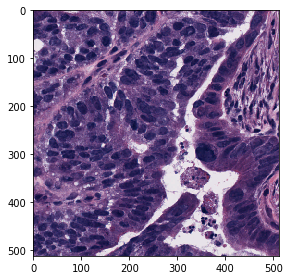

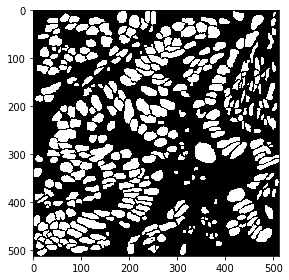

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


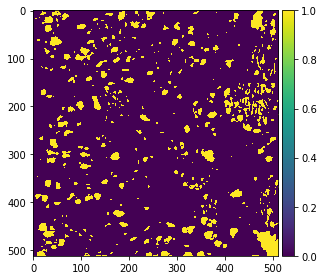

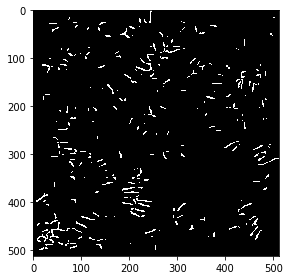

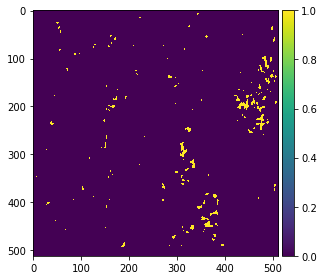

In [40]:
# Perform a sanity check on some random validation samples
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
imshow(np.squeeze(spaceBetweenVal[ix]))
plt.show()
imshow(np.squeeze(preds_val_t_spaceBetween[ix]))
plt.show()

and the test data:

# Upsample the test predictions to the original size

In [ ]:
preds_test_t_subtracted_upsampled = model.upsamplePredictionsToOriginalSize(preds_test_t_subtracted, originalSizes = sizes_test)

In [ ]:
# Perform a sanity check on some random test sample
for i in range(0,11):
    ix = random.randint(0, len(preds_test_upsampled))
    
    imshow(X_test[ix])
    plt.show()
    imshow(np.squeeze(preds_test[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t_spaceBetween[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t_subtracted[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t_subtracted_upsampled[ix]))
    plt.show()

# Encode and submit our results

Now it's time to submit our results. The implementation of run-length encoding is from [here](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [54]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(utils.prob_to_rles(preds_test_t_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [55]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submissions/sub-dsbowl2018-U-Net_12.csv', index=False)